# Setting GPU

In [1]:
import os

# PROJECT_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis"
# os.environ['PATH'] = "/sbin:/bin:/usr/bin:/usr/local/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin"
# os.environ['PATH'] = PROJECT_FOLDER+"/miniconda3/bin:" + os.environ['PATH'] 
os.environ['PATH'] 

'/data/students_home/amoscatelli/.local/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/bin:/data/students_home/amoscatelli/Desktop/actionAnalysis/miniconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/usr/local/cuda/bin:/snap/bin:/usr/lib/jvm/java-8-oracle/bin:/usr/lib/jvm/java-8-oracle/db/bin:/usr/lib/jvm/java-8-oracle/jre/bin'

In [2]:
import os
# with tf.device("/GPU:0"):
# os.environ["CUDA_VISIBLE_DEVICES"]="1,2"
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

## (Almost) Reproducible results

In [3]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

np.random.seed(42)
rn.seed(12345)
session_conf = tf.ConfigProto(intra_op_parallelism_threads=16, inter_op_parallelism_threads=16)
# session_conf = tf.ConfigProto()
session_conf.gpu_options.allow_growth = True

from keras import backend as K

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/data/student

In [4]:
# import tensorflow as tf
# tf.test.is_built_with_cuda()

In [5]:
# from keras import backend as K
# import tensorflow as tf
# # import os
# # with tf.device("/GPU:0"):
# # os.environ["CUDA_VISIBLE_DEVICES"]="0"
# K.tensorflow_backend._get_available_gpus()

In [6]:
# import tensorflow as tf
# from tensorflow.python.client import device_lib
# # gpus = tf.config.experimental.list_physical_devices('GPU')
# # tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
# device_lib.list_local_devices()

In [7]:
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# # config.log_device_placement = True  # to log device placement (on which device the operation ran)
#                                     # (nothing gets printed in Jupyter, only if you run it standalone)
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

# Setting for training

In [4]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

In [5]:
import keras
keras.__version__

'2.3.1'

## Load Dataset and count zero's

In [6]:
import numpy as np
import pickle
def getData(datasetName):
    with open(datasetName,'rb') as file_in:
#         features, labels, setups, cameras, performers, replications = pickle.load(file_in)
        train_set, val_set, test_set = pickle.load(file_in)
    
    #### stats ################################
    labels = ["train_set", "val_set", "test_set"]
    for i,dataset in enumerate([train_set, val_set, test_set]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
        print("{} shape: {}".format(labels[i], dataset[0].shape))
        print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
    return train_set, val_set, test_set

def getZeroStatsForDataset(X):
    totalsize = sum([len(x)*len(x[0])*2 for x in X])
    non_zero_elements = sum([np.count_nonzero(x) for x in X])
    zero_elements = totalsize - non_zero_elements
    return totalsize, zero_elements

## Data preprocessing functions

In [7]:
# it removes the zeros from the dataset features taking for each video the closest non-zero value 
def removeZerosFromDataset(X):
    print("removing zeros from dataset")
    for i,video in enumerate(X):
        if sum([np.count_nonzero(frame==0) for frame in video])>0:
#             print("removing zeros from video", i)
            removeZerosFromVideo(video)
    return X
    
# return the closest non zero point for the passed point
def getClosestNonZeroCoordinate(frameIdx, point, features):
    for hop in range(1,len(features)):
        previousIdx = max(0, frameIdx-hop)
        nextIdx = min(len(features)-1, frameIdx+hop)
        if all(features[previousIdx][point] != 0):
            return features[previousIdx][point]
        if all(features[nextIdx][point] != 0):
            return features[nextIdx][point]
    return [0.0,0.0] #in case that point is never found in the video
        
# it removes the zeros from the video features taking the closest non-zero values for each point
def removeZerosFromVideo(videoFeatures):
    # retrieving the index of the points which contain 0 values for each frame 
    zeroPoints = [list(set(np.where(frame == 0.)[0])) for frame in videoFeatures] 
    
    # concatenating the previous result with the frame index (discarding correct frames)
    zeroPointsCoordinates = [(i,p) for i,p in enumerate(zeroPoints) if len(p)>0]
    
    oldVideo = np.copy(videoFeatures)
    notFoundPoints = set()
    for frameIdx, pointCoordinates in zeroPointsCoordinates:
        for pointIdx in pointCoordinates:
            if pointIdx in notFoundPoints:
                videoFeatures[frameIdx][pointIdx] = [0.0,0.0]
            else:
                videoFeatures[frameIdx][pointIdx] = getClosestNonZeroCoordinate(frameIdx, pointIdx,oldVideo)
            
            if np.count_nonzero(videoFeatures[frameIdx][pointIdx]) == 0:
                notFoundPoints.add(pointIdx)

In [8]:
from sklearn.preprocessing import LabelBinarizer
def one_hot_encoding(labels):
    encoder = LabelBinarizer()
    label_strings = [str(i) for i in labels]
    oneHotLabels = encoder.fit_transform(label_strings)
    print('classes order:', encoder.classes_) 
    return oneHotLabels, encoder.classes_
    
from keras.preprocessing.sequence import pad_sequences

def paddingTrainValTest(X_train, X_val, X_test, maxLength=None):
    if maxLength is None:
         maxLength = max([len(s) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    # 17 if there is always only 1 person, 34 if there are videos with 2 people
    maxVideoHeigth = max([len(s[0]) for s in np.concatenate((X_train, X_val, X_test), axis=0)])
    
    for dataset in [X_train, X_val, X_test]:
        for i in range(len(dataset)):
            if dataset[i].shape[1] < maxVideoHeigth:
                videoShape = dataset[i].shape
                missingPart = (videoShape[0], maxVideoHeigth-videoShape[1], videoShape[2])
#                 dataset[i] = np.concatenate((dataset[i],np.zeros(dataset[i].shape)),axis=1)
                dataset[i] = np.concatenate((dataset[i], np.zeros(missingPart)), axis=1)
    
    
    X_train = pad_sequences(X_train, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_val = pad_sequences(X_val, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    X_test = pad_sequences(X_test, maxlen=maxLength, dtype='float32', padding='post', truncating='post', value=0.0)
    
    ### stats ######################################
    labels = ["train set", "val set", "test set"]
    for i, dataset in enumerate([X_train, X_val, X_test]):
        totalsize, zero_elements =  getZeroStatsForDataset(dataset)
        print("{} shape: {}".format(labels[i], dataset.shape))
        print("{} zero elements (after padding): {} ({:.2f}%)".format(labels[i],zero_elements,zero_elements*100/totalsize))
    
    return X_train, X_val, X_test

In [9]:
# def normaliseBeforePadding(X_train, X_val, X_test):
#     print("!!!! That's not correct. It normalize the datasets all in one. You should normalize each video indipendently.")
#     trainAndVal = np.concatenate((X_train, X_val), axis=0)
#     print("normalising train, val and test values BEFORE padding")
#     trainMean = np.vstack(trainAndVal).mean() # the mean and std must be calculated only on the training data
#     trainStd = np.vstack(trainAndVal).std()
#     normalized_X_train = np.array([(x - trainMean)/trainStd for x in X_train])
#     normalized_X_val = np.array([(x - trainMean)/trainStd for x in X_val])
#     normalized_X_test = np.array([(x - trainMean)/trainStd for x in X_test])

#     return normalized_X_train, normalized_X_val, normalized_X_test

In [10]:
def normalizeVideosXYInpid(dataset):
    print("normalising EACH VIDEO, considering x and y INDIPENDENTLY")

    for i in range(len(dataset)):
        xAndYVideoMean = np.mean(np.vstack(dataset[i]),axis=0)
        xAndYVideoStd = np.std(np.vstack(dataset[i]),axis=0)
        dataset[i] = (dataset[i]-xAndYVideoMean)/xAndYVideoStd

    return dataset

In [11]:
def normalizeVideos(dataset):
    print("normalising EACH VIDEO, considering x and y TOGETHER")
    for i in range(len(dataset)):
        videoMean = np.mean(np.vstack(dataset[i]))
        videoStd = np.std(np.vstack(dataset[i]))
        dataset[i] = (dataset[i]-videoMean)/videoStd

    return dataset

In [12]:
# Posenet predicts:
# 1 - nose             18
# 2 - leftEye          19
# 3 - rightEye         20
# 4 - leftEar          21
# 5 - rightEar         22

# 6 - leftShoulder     23
# 7 - rightShoulder    24
# 8 - leftElbow        25
# 9 - rightElbow       26
# 10 - leftWrist       27
# 11 - rightWrist      28

# 12 - leftHip         29
# 13 - rightHip        30
# 14 - leftKnee        31
# 15 - rightKnee       32
# 16 - leftAnkle       33
# 17 - rightAnkle      34

In [13]:
def relativeToVideoCenter(X):
    print("Adapting the data to the CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the whole video
        videoMean = np.mean([np.mean(features,axis=0) for features in frames], axis = 0) 
        X[i] = [frame-videoMean for frame in frames]

    return X

def relativeToPersonVideoCenter(X):
    print("Adapting the data to the video PERSON CENTER of each VIDEO")
    for i,frames in enumerate(X):
        # calculating the center of the frames points relative to the whole video
        videoMean = np.mean([np.mean(features[:17],axis=0) for features in frames], axis = 0) 

        if len(frames[0]) == 34:
            videoMean2 = np.mean([np.mean(features[17:],axis=0) for features in frames], axis = 0) 
            videoMean = np.vstack((videoMean, videoMean2)) 
            videoMean = np.repeat(videoMean, [17, 17], axis=0)
        
        X[i] = [frame-videoMean for frame in frames]

    return X

In [14]:
def relativeToFrameCenter(X):
    print("Adapting the data to the CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame,axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

def relativeToPersonFrameCenter(X):
    print("Adapting the data to the PERSON CENTER of each FRAME")
    for i_video, video in enumerate(X):
        for i_frame, frame in enumerate(video):
            frame_mean = np.mean(frame[:17],axis=0)
            if len(frame) == 34:
                frame_mean2 = np.mean(frame[17:],axis=0)
                frame_mean = np.vstack((frame_mean, frame_mean2)) 
                frame_mean = np.repeat(frame_mean, [17, 17], axis=0)
            X[i_video][i_frame] = frame - frame_mean

    return X

In [15]:
def relativeTo5BaricentersNTURGBofVideo(X):
    print("Adapting the data to the 5 body baricenters of each video as in NTU-RGB-60")
    for i_video,frames in enumerate(X): 
        troncoPoints = [0,1,2,3,4,5,6,11,12]
        rightArmPoints = [8,10]
        leftArmPoints = [7,9]
        rightLegPoints = [14,16]
        leftLegPoints = [13,15] 
        videoCenterFrame = np.zeros(frames[0].shape)
        for person_offset in range(0,len(frames[0]),17):
            troncoPoints = [i+person_offset for i in troncoPoints]
            rightArmPoints += [i+person_offset for i in rightArmPoints]
            leftArmPoints += [i+person_offset for i in leftArmPoints]
            rightLegPoints += [i+person_offset for i in rightLegPoints]
            leftLegPoints += [i+person_offset for i in leftLegPoints]
            troncoCenter = np.mean(np.mean(np.array(frames)[:,troncoPoints], axis=1),axis=0)
            rightArmCenter = np.mean(np.mean(np.array(frames)[:,rightArmPoints], axis=1),axis=0)
            leftArmCenter = np.mean(np.mean(np.array(frames)[:,leftArmPoints], axis=1),axis=0)
            rightLegCenter = np.mean(np.mean(np.array(frames)[:,rightLegPoints], axis=1),axis=0)
            leftLegCenter = np.mean(np.mean(np.array(frames)[:,leftLegPoints], axis=1),axis=0)

#             videoCenterFrame = np.array(frames[0],dtype=np.float)
            videoCenterFrame[troncoPoints] = troncoCenter 
            videoCenterFrame[rightArmPoints] = rightArmCenter 
            videoCenterFrame[leftArmPoints] = leftArmCenter 
            videoCenterFrame[rightLegPoints] = rightLegCenter 
            videoCenterFrame[leftLegPoints] = leftLegCenter 

        X[i_video] = frames - videoCenterFrame
    return X

def relativeTo5BaricentersNTURGBofVideoAbs(X):
    return abs(relativeTo5BaricentersNTURGBofVideo(X))

In [16]:
# # model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
# datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_TEST-dataset.pickle"

# train_set, val_set, test_set = getData(datasetName)

# train_set[0] = removeZerosFromDataset(train_set[0])
# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))

    
# X_to_test = train_set[0][0]
# X_to_test = X_to_test[:2]
# X_to_test = np.expand_dims(X_to_test, axis=0)
# print("X_to_test shape", X_to_test.shape)

In [17]:
# def relativeTo3BaricentersOfFrame(X):
#     assert False, "Va testato"
#     print("Adapting the data to the TOP-MIDDLE-BOTTOM center of each frame")
#     for i_video, video in enumerate(X):
#         for i_frame, frame in enumerate(video):
#             X[i_video][i_frame][:5] = frame[:5] - np.mean(frame[:5], axis=0)
#             X[i_video][i_frame][5:11] = frame[5:11] - np.mean(frame[5:11], axis=0)
#             X[i_video][i_frame][11:17] = frame[11:17] - np.mean(frame[11:17], axis=0)
#             if len(frame) == 34:
#                 X[i_video][i_frame][17:22] = frame[17:22] - np.mean(frame[17:22], axis=0)
#                 X[i_video][i_frame][22:28] = frame[22:28] - np.mean(frame[22:28], axis=0)
#                 X[i_video][i_frame][28:34] = frame[28:34] - np.mean(frame[28:34], axis=0)
#     return X

In [18]:
def relativeTo3BaricentersOfVideo(X):
    print("Adapting the data to the 3 BARICENTERS of each VIDEO")
    
    for i_video,frames in enumerate(X):        
        videoUpperMeanP1 = np.mean([np.mean(features[:5], axis=0) for features in frames], axis = 0) 
        videoMiddleMeanP1 = np.mean([np.mean(features[5:11], axis=0) for features in frames], axis = 0) 
        videoBottomMeanP1 = np.mean([np.mean(features[11:17], axis=0) for features in frames], axis = 0) 
        if len(frames[0]) == 34:
            videoUpperMeanP2 = np.mean([np.mean(features[17:22], axis=0) for features in frames], axis = 0) 
            videoMiddleMeanP2 = np.mean([np.mean(features[22:28], axis=0) for features in frames], axis = 0) 
            videoBottomMeanP2 = np.mean([np.mean(features[28:34], axis=0) for features in frames], axis = 0) 
        
        for i_frame, frame in enumerate(frames):
            X[i_video][i_frame][:5] = frame[:5] - videoUpperMeanP1
            X[i_video][i_frame][5:11] = frame[5:11] - videoMiddleMeanP1
            X[i_video][i_frame][11:17] = frame[11:17] - videoBottomMeanP1
            if len(frame) == 34:
                X[i_video][i_frame][17:22] = frame[17:22] - videoUpperMeanP2
                X[i_video][i_frame][22:28] = frame[22:28] - videoMiddleMeanP2
                X[i_video][i_frame][28:34] = frame[28:34] - videoBottomMeanP2
                
    return X

def relativeTo3BaricentersOfVideoAbs(X):
    return abs(relativeTo3BaricentersOfVideo(X))

In [19]:
def relativeTo17BaricentersOfVideo(X):
    print("Adapting the data as the difference to the center of EACH KEYPOINT in the VIDEO")   
    for i_video,frames in enumerate(X): 
        video_mean_by_points = np.mean(X[i_video],axis=0)
        X[i_video] = X[i_video] - video_mean_by_points
    return X

def relativeTo17BaricentersOfVideoAbs(X):
    return abs(relativeTo17BaricentersOfVideo(X))

In [20]:
# def relativeToNextFrameOLD(X):
#     print("Adapting the data to the next frame")
#     newX = []
#     for frames in X:
#         motions = []
#         for i in range(len(frames)-1):
#             motions.append(np.array(frames[i+1])-np.array(frames[i]))
#         newX.append(motions)
#     return np.array(newX)

In [21]:
# builder function which return a function to calculate the difference each N frames
def relativeToNextFrameBuilder(step):
    step = step
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def relativeToNextFrame(X):
        print("Adapting the data to the next",step,"frame")
        newX = []
        for frames in X:
            # repeat the last frame of the video as much as the number of steps
            frames = np.concatenate((frames,np.repeat(np.expand_dims(frames[-1],axis=0),step,axis=0)))
            motions = np.array([frames[i+step]-frames[i] for i in range(len(frames)-step-1)])
            newX.append(motions)
        return np.array(newX)
    
    if step>1:
        relativeToNextFrame.__name__ = "relativeToNextFrame_"+str(step)
    return relativeToNextFrame
  

In [22]:
def cumulativeDifferences(X):
        print("Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames")
        newX = []
        for frames in X:
            motions = frames - frames[0]
            newX.append(motions)
        return np.array(newX)

In [23]:
import math
def euclDistance(point1,point2):
    return math.sqrt((point2[0] - point1[0])**2 + (point2[1] - point1[1])**2)

def relativeToPointDistances(X):
    print("Adapting the data to the DISTANCES between points of each person in each FRAME")
    newX = []
    for videoIdx,video in enumerate(X):
        if videoIdx % 100 == 0:
            print("{}/{} video done".format(videoIdx,len(X)))
        
        videoDistances = np.zeros((len(video),len(video[0]),17))
        
        for fIdx, frame in enumerate(video):
            distances = [[euclDistance(frame[i],frame[j]) for j in range(17)] for i in range(17)]
            if len(frame) == 34:
                distancesP2 = [[euclDistance(frame[i],frame[j]) for j in range(17,34)] for i in range(17,34)]
                distances = np.concatenate((distances,distancesP2),axis = 0)
            videoDistances[fIdx] = distances
        
        newX.append(videoDistances)
    return np.array(newX)

In [24]:
# #ARTIFICIAL 
# # X_to_test = np.arange(2*2*17*2).reshape((2,2,17,2)) # 1 person
# X_to_test = np.arange(2*3*34*2).reshape((2,3,34,2)) # 2 people
# # X_to_test = X_to_test*0.3
# X_to_test
# # print(type(X_to_test[0][0][0][0]))

In [25]:
def preprocessData(train_set, val_set, test_set, preprocess_functions = None):
    X_train, X_val, X_test = train_set[0], val_set[0], test_set[0]
    # one hot encoding
    y_train, encoding_train = one_hot_encoding(train_set[1])
    y_val, encoding_val = one_hot_encoding(val_set[1])
    y_test, encoding_test = one_hot_encoding(test_set[1])
    
    assert all(encoding_train == encoding_val)
    assert all(encoding_val == encoding_test)

    # preprocess
    if preprocess_functions is not None:
        for preprocess_function in preprocess_functions:
            X_train = preprocess_function(X_train)
            X_val = preprocess_function(X_val)
            X_test = preprocess_function(X_test)

    #padding
    X_train, X_val, X_test = paddingTrainValTest(X_train, X_val, X_test)

    
    ## reshaping after padding ###
    X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2] * X_train.shape[3])
    X_val = X_val.reshape(X_val.shape[0],X_val.shape[1],X_val.shape[2] * X_val.shape[3])
    X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2] * X_test.shape[3])
    
#     ## reshaping without padding ###
#     for dataset in [X_train, X_val, X_test]:
#         for i in range(len(dataset)):
#             dataset[i] = dataset[i].reshape(dataset[i].shape[0], 
#                                             dataset[i].shape[1] * dataset[i].shape[2])

    encoding_train = [int(i) for i in encoding_train]

    return X_train, y_train, X_val, y_val, X_test, y_test, encoding_train

In [26]:
import scipy
from scipy import signal

# builder function which returs a Savitzky-Golay smoother function with the passed arguments
def smoothingPoints(window, order):
    movingWindow = window
    polynomialOrder = order
    
    # it smooths the dataset following the Savitzky-Golay algorithm
    def smooth(X):
        for vidIdx, video in enumerate(X):
            if vidIdx % 500 == 0:
                print("smooting video {}/{}".format(vidIdx,len(X)))
            for p in range(len(X[0][0])): # X[0][0] == 17 or 34 -> the number of points
                x, y = zip(*[(f[p][0], f[p][1]) for f in video])
                
                #     Savitzky-Golay
                smooth_x = signal.savgol_filter(x, movingWindow, polynomialOrder)
                smooth_y = signal.savgol_filter(y, movingWindow, polynomialOrder)
                
                # placing the smoothed series
                for i,frame in enumerate(video):
                    frame[p] = [smooth_x[i], smooth_y[i]]
        return X
    
    smooth.__name__ = "smooth_"+str(window)+"_"+str(order)
        
    return smooth

# Setting data

In [45]:
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

# DATASET_FOLDER = "/content/gdrive/My Drive/actionAnalysis/datasets/"
# SAVED_MODEL_FOLDER = "/content/gdrive/My Drive/actionAnalysis/savedModels/"

folder_where_save1 = "Cross_view/"        
# folder_where_save1 = "Cross_subject/"     
folder_where_save2 = "Cross_subject/"     

# folder_where_save1 = "Cross_view_lrScan/"        
# folder_where_save1 = "Cross_subject_lrScan/"     
# folder_where_save2 = "Cross_subject_lrScan/"
# SCAN_EPOCHS = 10

# folder_where_save1 = "Cross_view_tough/" 
# folder_where_save2 = "Cross_view_tough/" 

# folder_where_save1 = "Cross_subject_tough/"
# folder_where_save2 = "Cross_view_tough/"

# folder_where_save1 = "Cross_view_test/" 
# folder_where_save2 = "Cross_subject_test/"

# folder_where_save1 = "Cross_view_mini/"     
# folder_where_save2 = "Cross_subject_mini/"  

# folder_where_save1 = "Senesi/"
# folder_where_save2 = "Cross_subject/"

# folder_where_save1 = "Cross_view/"
# folder_where_save2 = "top-models/"


MODEL_NAME_VALUES = [
    "keypoint_rcnn_X_101_32x8d_FPN_3x"
    ,"PoseNet-101"
    ]

PATIENCE = 100
HIDDEN_UNITS_VALUES = [64]
LEARNING_RATE_VALUES = [0.02,0.025,0.015]
#                         [0.04,0.039,0.038,0.037,0.036,0.035,0.034,0.033,0.032,0.031,
#                         0.03,0.029,0.028,0.027,0.026,0.025,0.024,0.023,0.022,0.021,
#                         0.02,0.019,0.018,0.017,0.016,0.015,0.014,0.013,0.012,0.011,
#                         0.01,0.009,0.008,0.007,0.006,0.005,0.004,0.003,0.002,0.001]
BATCH_SIZE = 600
REFERENCE_EPOCHS = 100 #the earlystop will eventually stop the training

USE_SCHEDULER = True
###### STEP SCHEDULER ###################
# def stepScheduler(epoch, lr):
#     DECAY_RATE = 0.8
#     DECAY_STEP = 15
#     if epoch % DECAY_STEP == 0 and epoch:
#         return lr * DECAY_RATE
#     return lr
# scheduler = stepScheduler
##########################################

###### LINEAR SCHEDULER ###################
# def linearScheduler(epoch, lr):
#     return max(lr - LEARNING_RATE/EPOCHS,0)
# scheduler = linearScheduler
##########################################

###### POLYNOMIAL SCHEDULER #############
LR_OFFSET = 0.002
LR_POWER = 1.5
def polynomialScheduler(epoch, lr):
    decay = (1 - (epoch / float(EPOCHS)))  ** LR_POWER
    alpha = LEARNING_RATE * decay
    return float(alpha) + LR_OFFSET
scheduler = polynomialScheduler
##########################################

USE_LSTM = False
USE_CuDNNLSTM = not USE_LSTM

# REGULARIZER_VALUES = [1, 0.1, 0.01, 0.001, 0] 
REGULARIZER_VALUES = [0,
                      0.00001,
                      0.000001
                     ]  

DROPOUT_VALUES = [
                  0.05,0.1,0.15,0
                 ] # [] == don't load

# LOAD_FROM_PREVIOUS_DROPOUT = [0.05,0.1,0.15,0.2,0.3,0.4,0.5] # [] == don't load
LOAD_FROM_PREVIOUS_DROPOUT = [] # [] == don't load

LSTM_LAYERS_VALUES = [2
#                       ,3,4,5
                     ]
PREPROCESS_FUNCTION_TO_TEST = [
    
     (folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos])
     ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo3BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToFrameCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonFrameCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToVideoCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPersonVideoCenter,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToPointDistances,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,cumulativeDifferences,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo5BaricentersNTURGBofVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[])
#      ,(folder_where_save2,[])
#      ,(folder_where_save1,[normalizeVideos])
#      ,(folder_where_save2,[normalizeVideos])
#      ,(folder_where_save1,[normalizeVideosXYInpid])
#      ,(folder_where_save2,[normalizeVideosXYInpid])
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideos])
#      ,(folder_where_save1,[removeZerosFromDataset,normalizeVideosXYInpid])
#      ,(folder_where_save2,[removeZerosFromDataset,normalizeVideosXYInpid])

    
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideo,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeTo17BaricentersOfVideoAbs,normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(1),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(3),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(7),normalizeVideos])
    
#      ,(folder_where_save1,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
#      ,(folder_where_save2,[removeZerosFromDataset,relativeToNextFrameBuilder(15),normalizeVideos])
    
     
    # TECNIQUES

# relativeToVideoCenter
# relativeToPersonVideoCenter
# relativeToFrameCenter
# relativeToPersonFrameCenter
# relativeTo5BaricentersNTURGBofVideo
# relativeTo5BaricentersNTURGBofVideoAbs
# relativeTo3BaricentersOfVideo
# relativeTo3BaricentersOfVideoAbs
# relativeTo17BaricentersOfVideo
# relativeTo17BaricentersOfVideoAbs
# relativeToNextFrameBuilder(1)
# relativeToNextFrameBuilder(3)
# relativeToNextFrameBuilder(7)
# relativeToNextFrameBuilder(15)
# cumulativeDifferences
# relativeToPointDistances
]

if USE_LSTM:
    REGULARIZER_VALUES = [0]
if not USE_SCHEDULER:
    LR_OFFSET = 0
    LR_POWER = 0
    

print("NORMAL LSTM" if USE_LSTM else "CuDNNLSTM")
print(len(MODEL_NAME_VALUES),"MODEL_NAME_VALUES:", MODEL_NAME_VALUES)
print(len(LSTM_LAYERS_VALUES),"LSTM_LAYERS_VALUES LAYERS:", LSTM_LAYERS_VALUES)
print(len(HIDDEN_UNITS_VALUES), "HIDDEN UNITS",HIDDEN_UNITS_VALUES)
print(len(REGULARIZER_VALUES),"REGULARIZER_VALUES",REGULARIZER_VALUES)
print(len(DROPOUT_VALUES),"DROPOUT_VALUES",DROPOUT_VALUES)
print(len(PREPROCESS_FUNCTION_TO_TEST),"PREPROCESS_FUNCTION_TO_TEST")


numberOfTests = len(MODEL_NAME_VALUES)* len(LEARNING_RATE_VALUES)*len(HIDDEN_UNITS_VALUES) * len(PREPROCESS_FUNCTION_TO_TEST)*len(DROPOUT_VALUES)*len(REGULARIZER_VALUES)*len(LSTM_LAYERS_VALUES)
print()
print(len(LEARNING_RATE_VALUES),"LEARNING_RATE_VALUES",LEARNING_RATE_VALUES)
if USE_SCHEDULER:
#     print("\nUSE_SCHEDULER\n\tDECAY_RATE:", DECAY_RATE, "\n\tDECAY_STEP:", DECAY_STEP)
    print(scheduler.__name__)
    print("LR_OFFSET:",LR_OFFSET)
    print("LR_POWER:",LR_POWER)
print("\nNumber of tests:", numberOfTests)
print("PATIENCE:", PATIENCE)
print("BATCH_SIZE:", BATCH_SIZE)
print("REFERENCE_EPOCHS:", REFERENCE_EPOCHS)

SAVED_MODEL_FOLDER, folder_where_save1, folder_where_save2

CuDNNLSTM
2 MODEL_NAME_VALUES: ['keypoint_rcnn_X_101_32x8d_FPN_3x', 'PoseNet-101']
1 LSTM_LAYERS_VALUES LAYERS: [2]
1 HIDDEN UNITS [64]
3 REGULARIZER_VALUES [0, 1e-05, 1e-06]
4 DROPOUT_VALUES [0.05, 0.1, 0.15, 0]
2 PREPROCESS_FUNCTION_TO_TEST

3 LEARNING_RATE_VALUES [0.02, 0.025, 0.015]
polynomialScheduler
LR_OFFSET: 0.002
LR_POWER: 1.5

Number of tests: 144
PATIENCE: 100
BATCH_SIZE: 600
REFERENCE_EPOCHS: 100


('/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/',
 'Cross_view/',
 'Cross_subject/')

## sequential trainings

In [46]:
def getSaveFileName(modelName,preprocess_functions,learning_rate, offset, power, numberOfLSTMLayers, useCudaLSTM, hiddenUnits, regularizerValue, dropOut, recurrentDropOut):
    saveFileName = modelName+"-{}L".format(numberOfLSTMLayers+1)
    saveFileName += "-CuDNNLSTM" if useCudaLSTM else ""
    saveFileName += "-HU_"+str(hiddenUnits)
    saveFileName += "-LR_"+str(learning_rate)
    saveFileName += "-OFF_"+str(offset)
    saveFileName += "-POW_"+str(power)
    if preprocess_functions is not None:
        for function in preprocess_functions:
            saveFileName += "-{}".format(function.__name__) 
                
    saveFileName += "-drop-"+str(dropOut)
    
    if useCudaLSTM:
        saveFileName += "-reg-"+str(regularizerValue)
    else:
        saveFileName += "-rec_drop-"+str(recurrentDropOut)
    
    return saveFileName

In [47]:
from sklearn.metrics import accuracy_score
def getValTestAccuracy(model,x_val,y_val,x_test,y_test, label_order = None):
    if label_order is None:
        raise Exception("define label order for val test accuracy evaluation")
    y_val_pred = [label_order[i] for i in model.predict_classes(x_val)]
    y_val_true = [label_order[np.argmax(i)] for i in y_val]
    y_test_pred = [label_order[i] for i in model.predict_classes(x_test)]
    y_test_true = [label_order[np.argmax(i)] for i in y_test]
    val_acc = accuracy_score(y_pred=y_val_pred,y_true=y_val_true)
    test_acc = accuracy_score(y_pred=y_test_pred,y_true=y_test_true)
    return val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred

In [48]:
def cleanForExcel(text):
    replacements = (
        ("relativeToVideoCenter","VIDEO"),
        ("relativeToPersonVideoCenter","VIDEO_PERS"),        
        ("relativeToFrameCenter","FRAME"),        
        ("relativeToPersonFrameCenter","FRAME_PERS"),  
        ("relativeTo3BaricentersOfVideo","3BAR"),
        ("relativeToUpperMiddleBottomCentersOfVideo","3BAR"),        
        ("relativeTo5BaricentersNTURGBofVideo","5BAR"),
        ("relativeTo17BaricentersOfVideo","17BAR"),
        ("relativeToPointDistances","DIST_REL"),
        ("relativeToNextFrame","NEXT"),
        ("cumulativeDifferences","DIST_CUM"),
        ("removeZerosFromDataset","rimoz_0"), 
        ("normalizeVideosXYInpid","normXY"),
        ("normalizeVideos","norm"),     
        ("Abs","_ASS"),    
        ("CuDNNLSTM","cuda"),
        (".pickle",""),
        (".h5",""),
        (".",","),
        ("PoseNet-101","pos"),
        ("keypoint_rcnn_X_101_32x8d_FPN_3x","det"),
        ("-drop-0-","-"),
        ("-rec_drop-0-","-"),
        ("-reg-0#",""),
        ("-reg-0-","-"),
        ("#","")
    )
    text = text+"#"
    for r in replacements:
        text = text.replace(*r)
    return text


In [49]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from os import scandir
from os.path import exists, basename
import shutil 
import math
from numpy.random import seed
from tensorflow import set_random_seed 

import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K
import os


# earlyStop = EarlyStopping(monitor='val_acc', ## 4 COLAB 
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=PATIENCE, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)


progressCounter = 0
for LSTM_LAYERS in LSTM_LAYERS_VALUES:
    for MODEL_NAME in MODEL_NAME_VALUES:
        for LEARNING_RATE in LEARNING_RATE_VALUES:
            for HIDDEN_UNITS in HIDDEN_UNITS_VALUES:
                for dropOut_idx, dropOut in enumerate(DROPOUT_VALUES):
                    for regularizer_idx, regularizer in enumerate(REGULARIZER_VALUES):

                        DROPOUT = dropOut
                        RECURRENT_DROPOUT = dropOut
                        EPOCHS = round(REFERENCE_EPOCHS * (1+DROPOUT))

                        for i, (folder_where_to_save, preprocess_functions) in enumerate(PREPROCESS_FUNCTION_TO_TEST):
                            progressCounter += 1
                            folderPathWhereToSave = SAVED_MODEL_FOLDER+folder_where_to_save
                            if folder_where_to_save.endswith("_lrScan/"):
                                EPOCHS = SCAN_EPOCHS

                            alreadyTrainedModel = [f for f in scandir(folderPathWhereToSave) if f.path.endswith(".h5")]

                            ### SET SAVE FILE NAME ###
                            saveFileName = getSaveFileName(modelName = MODEL_NAME,
                                                           preprocess_functions = preprocess_functions,
                                                           learning_rate= LEARNING_RATE,
                                                           offset = LR_OFFSET,
                                                           power = LR_POWER,
                                                           numberOfLSTMLayers = LSTM_LAYERS,
                                                           useCudaLSTM = USE_CuDNNLSTM,
                                                           hiddenUnits = HIDDEN_UNITS,
                                                           regularizerValue = regularizer,
                                                           dropOut = DROPOUT, 
                                                           recurrentDropOut = RECURRENT_DROPOUT
                                                          )

                            print("######## {}/{} - {} - {} ########".format(progressCounter, numberOfTests, saveFileName, folder_where_to_save))

                            if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
                                print("### already done! ####")
                                continue
                            else:
                                #to avoid that someone else will start the same fitting
                                print("touching",folderPathWhereToSave+saveFileName+".h5")
                                modelFileName = saveFileName+".h5"

        #                         pathToTouch = (folderPathWhereToSave+modelFileName).replace(" ","\ ") ## 4 COLAB 
                                modelFileNamePath = folderPathWhereToSave+modelFileName
                                !touch $modelFileNamePath
                                print("## To be saved in [...]{} ###".format(folderPathWhereToSave[54:]))

                            ### LOADING DATASET ###
                            if folderPathWhereToSave.endswith("Senesi/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
                            elif folderPathWhereToSave.endswith("top-models/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"      

                            elif folderPathWhereToSave.endswith("Cross_subject_test/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TEST-dataset.pickle"            
                            elif folderPathWhereToSave.endswith("Cross_view_test/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TEST-dataset.pickle"     

                            elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_subject/","Cross_subject_lrScan/"]]):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"       
                            elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_view/","Cross_view_lrScan/"]]):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"  

                            elif folderPathWhereToSave.endswith("Cross_view_tough/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOUGH-dataset.pickle"            
                            elif folderPathWhereToSave.endswith("Cross_subject_tough/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOUGH-dataset.pickle" 

                            elif folderPathWhereToSave.endswith("Cross_view_mini/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"            
                            elif folderPathWhereToSave.endswith("Cross_subject_mini/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"    

                            elif folderPathWhereToSave.endswith("top+Senesi_Cross_view/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOP+SENESI-dataset.pickle"            
                            elif folderPathWhereToSave.endswith("top+Senesi_Cross_subject/"):
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOP+SENESI-dataset.pickle" 

                            elif folderPathWhereToSave.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
                                datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
                            else:
                                raise Exception("result folder not correct")

                            ### CHECK IF ALREADY PREPROCESSED DATASET EXISTS
                            preprocessed_datasetName = basename(datasetName).replace("-dataset.pickle","")
                            for f in preprocess_functions:
                                preprocessed_datasetName += "-"+f.__name__
                            preprocessed_datasetName += "-dataset.pickle"

                            preprocessed_datasetPath = DATASET_FOLDER+preprocessed_datasetName

                            if exists(preprocessed_datasetPath):
                                print("#### Loading preprocessed dataset: ", preprocessed_datasetPath)
                                with open(preprocessed_datasetPath,'rb') as file_in:
                                    prepDict = pickle.load(file_in)
                                    X_train = prepDict["X_train"]
                                    y_train = prepDict["y_train"]
                                    X_val = prepDict["X_val"]
                                    y_val = prepDict["y_val"]
                                    X_test = prepDict["X_test"]
                                    y_test = prepDict["y_test"]
                                    encodingLabels = prepDict["encodingLabels"]
                            else:
                                print("#### Loading dataset: ", datasetName)
                                train_set, val_set, test_set = getData(datasetName)
                                print("Preproccesing dataset...")
                                X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                                                               val_set, 
                                                                                                               test_set,  
                                                                                                               preprocess_functions)

                            # TO SOLVE THE DROPOUT LAYER SHAPE PROBLEM
                            missing_train = (BATCH_SIZE-(X_train.shape[0]%BATCH_SIZE))%BATCH_SIZE
                            X_train = np.concatenate((X_train,X_train[:missing_train]),axis=0)
                            y_train = np.concatenate((y_train,y_train[:missing_train]),axis=0)

                            ### DEFINING MODEL ###
                            inputDim = (X_train.shape[1], X_train.shape[2])
                            outputLen = len(y_train[0])

                            ## callbacks and checkpoints
                            minLossModelName = "{}-min_val_loss.hdf5".format(folderPathWhereToSave+saveFileName)
                            checkpointLoss = ModelCheckpoint(minLossModelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

                            maxAccModelName = "{}-max_val_acc.hdf5".format(folderPathWhereToSave+saveFileName)

                            checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
        #                     checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_acc', verbose=1, save_best_only=True, mode='max') ## 4 COLAB 


                            callbacks_list = [checkpointLoss, checkpointAcc]

                            if USE_SCHEDULER:
                                callbacks_list.append(LearningRateScheduler(scheduler, verbose=1))
                            else:
                                callbacks_list.append(earlyStop)


                            model = models.Sequential()
                            model.add(Dropout(DROPOUT, input_shape=inputDim, noise_shape=(BATCH_SIZE, 1, inputDim[1])))

                            if USE_LSTM:
                                if LSTM_LAYERS == 1:
                                    model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))
                                else:       
                                    model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                                    for layerIdx in range(2, LSTM_LAYERS):
                                        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
                                    model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))    

                            elif USE_CuDNNLSTM:
                                reg=l2(regularizer) if regularizer > 0 else None

                                if LSTM_LAYERS == 1:
                                    model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg))
                                else:
                                    model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))
                                    for layerIdx in range(2, LSTM_LAYERS):
                                        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))                  
                                    model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer=reg))


                            model.add(Dense(outputLen, activation='softmax'))


                            rmpsprop = RMSprop(lr=LEARNING_RATE, rho=0.9) ## 4 COLAB 
        #                     rmpsprop = RMSprop(lerning_rate=LEARNING_RATE, rho=0.9)

                            model.compile(
        #                                 optimizer='rmsprop',
                                        optimizer=rmpsprop,
                                        loss='categorical_crossentropy',
                                        metrics=['accuracy'])


                            ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                            if exists(minLossModelName):
                                print("#### Loading weights from MIN LOSS model")
                                model.load_weights(minLossModelName)

                            ## RECOVER FROM MIN LOSS MODEL IF EXISTS
                            minLossBackupModelName = "{}-min_val_loss-BACKUP.hdf5".format(folderPathWhereToSave+saveFileName)
                            if exists(maxAccModelName):
                                print("#### Loading weights from MAX ACCURACY model")
                                model.load_weights(minLossModelName)
                                if exists(minLossModelName):
                                    print("#### BACKUP of weights for previous MIN LOSS model")
                                    shutil.copyfile(minLossModelName,minLossBackupModelName)

                            ## Loading weights from previous model trained with an higher dropout rate
                            loadedFromPreviousModel = False
                            if (DROPOUT > 0 or RECURRENT_DROPOUT > 0) and LOAD_FROM_PREVIOUS_DROPOUT and USE_LSTM:
                                for prev_dropOut in LOAD_FROM_PREVIOUS_DROPOUT:
                                    if prev_dropOut <= DROPOUT:
                                        continue
                                    previousModelName = getSaveFileName(modelName = MODEL_NAME, 
                                                                        preprocess_functions = preprocess_functions, 
                                                                        learning_rate= LEARNING_RATE,
                                                                        offset = LR_OFFSET,
                                                                        power = LR_POWER,
                                                                        numberOfLSTMLayers = LSTM_LAYERS, 
                                                                        useCudaLSTM = USE_CuDNNLSTM,
                                                                        hiddenUnits = HIDDEN_UNITS,
                                                                        regularizerValue = regularizer,
                                                                        dropOut = prev_dropOut, 
                                                                        recurrentDropOut = prev_dropOut)
                                    if exists(folderPathWhereToSave+previousModelName+".h5"):
                                        print("#### Loading weights from",previousModelName)
                                        model.load_weights(folderPathWhereToSave+previousModelName+".h5")
                                        loadedFromPreviousModel = True
                                        break


                            ## FIT ###    
                            model_history = model.fit(X_train, y_train,
                                                epochs=EPOCHS,
                                                batch_size=BATCH_SIZE,
                                                callbacks=callbacks_list,
                                                validation_data=(X_val, y_val)
                                               )

                            ### SAVE MODEL ###
                            model.save(folderPathWhereToSave+saveFileName+".h5")

                            ### SAVE HISTORY AND PREPROCESS FUNCTIONS ###
                            env_functions = [one_hot_encoding, 
                                              euclDistance,
                                              paddingTrainValTest, 
                                              getClosestNonZeroCoordinate,
                                              removeZerosFromVideo,
                                              getZeroStatsForDataset,
                                              preprocessData,
                                             ]

                            historyToSave = {
                                "acc" : model_history.history['accuracy'],
                                "val_acc" : model_history.history['val_accuracy'],
                                "loss" : model_history.history['loss'],
                                "val_loss" : model_history.history['val_loss']
                            }


                            info_to_save = {"history": historyToSave,
                                            "env_fun_DILL":[dill.dumps(x) for x in env_functions],
                                            "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}

                            if loadedFromPreviousModel:
                                info_to_save["loaded_from"] = previousModelName

                            with open(folderPathWhereToSave+saveFileName+".pickle","wb") as handle:
                                pickle.dump(info_to_save, handle) 
                                print("## Saved in {} ###\n\n".format(folderPathWhereToSave+saveFileName+".pickle"))


                            ### EVALUATING MODEL ### 
                            model = load_model(maxAccModelName)
                            !mv $maxAccModelName $modelFileNamePath
                            val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
                            print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

                            if exists(minLossModelName):
                                model_minLoss = load_model(minLossModelName)
                                val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
                                print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))
                            else:
                                print("Model for MIN LOSS NOT SAVED")
                                val_acc_minLoss = math.inf

                            if exists(minLossBackupModelName):
                                model_minLoss_b = load_model(minLossBackupModelName)
                                print("#### Evaluating BACKUP min loss model ####")
                                val_acc_minLoss_b, test_acc_minLoss_b, y_val_true, y_val_pred_minLoss_b, y_test_true, y_test_pred_minLoss_b = getValTestAccuracy(model_minLoss_b,X_val,y_val,X_test,y_test,encodingLabels)
                                print("Model for BACKUP MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss_b*100,val_acc_minLoss_b*100))
                                if (val_acc_minLoss_b < val_acc_minLoss):
                                    print("### keeping BACKUP MIN LOSS model ####")
                                    val_acc_minLoss, test_acc_minLoss, y_val_pred_minLoss, y_test_pred_minLoss = val_acc_minLoss_b, test_acc_minLoss_b, y_val_pred_minLoss_b, y_test_pred_minLoss_b
                                    !mv $minLossBackupModelName $minLossModelName
                                else:
                                    !rm $minLossBackupModelName

                            ### CLEANING MAX ACC CHECKPOINT 
                            ## 4 COLAB 
        #                     patToRemove = maxAccModelName.replace(" ","\ ")
    #                         patToRemove = maxAccModelName
    #                         !rm $patToRemove

                            ### SAVING RESULTS ###
                            if EPOCHS < 10:
                                print("## SKIPPING SAVING. EPOCHS < 11")
                                continue

                            if exists(folderPathWhereToSave+"summaryResults.pickle"):
                                print("Loading previous results...")
                                with open(folderPathWhereToSave+"summaryResults.pickle","rb") as handle:
                                        results = pickle.load(handle)
                            else:
                                results = []

                            results.append({"val_acc": val_acc, 
                                            "test_acc": test_acc, 
                                            "model_name": saveFileName, 
                                            "y_val_true": y_val_true,
                                            "y_val_pred": y_val_pred,
                                            "y_test_true": y_test_true,
                                            "y_test_pred": y_test_pred,

                                            "val_acc_minLoss": val_acc_minLoss, 
                                            "test_acc_minLoss": test_acc_minLoss, 
                                            "y_val_pred_minLoss": y_val_pred_minLoss,
                                            "y_test_pred_minLoss": y_test_pred_minLoss
                                           })

                            print("Dumping results...")
                            with open(folderPathWhereToSave+"summaryResults.pickle","wb") as handle:
                                pickle.dump(results, handle)

print("DONE!")


######## 1/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0 - Cross_view/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0.h5
## To be saved in [...]/savedModels/Cross_view/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dataset.pickle
Train on 30600 samples, validate on 7584 samples
Epoch 1/105

Epoch 00001: LearningRateScheduler setting learning rate to 0.022.
30600/30600 [==============================] - 16s 523us/step - loss: 4.1350 - accuracy: 0.0165 - val_loss: 4.0966 - val_accuracy: 0.01

30600/30600 [==============================] - 12s 384us/step - loss: 2.1828 - accuracy: 0.3296 - val_loss: 2.1135 - val_accuracy: 0.3473

Epoch 00010: val_loss improved from 2.16620 to 2.11346, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00010: val_accuracy improved from 0.33518 to 0.34731, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 11/105

Epoch 00011: LearningRateScheduler setting learning rate to 0.019212004660014756.
30600/30600 [==============================] - 11s 349us/step - loss: 2.0672 - accuracy: 0.3578 - v

30600/30600 [==============================] - 12s 385us/step - loss: 1.3483 - accuracy: 0.5674 - val_loss: 1.2521 - val_accuracy: 0.5969

Epoch 00020: val_loss improved from 1.31418 to 1.25212, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00020: val_accuracy improved from 0.58109 to 0.59691, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 21/105

Epoch 00021: LearningRateScheduler setting learning rate to 0.016567144746972795.
30600/30600 [==============================] - 12s 401us/step - loss: 1.2866 - accuracy: 0.5871 - v

30600/30600 [==============================] - 12s 394us/step - loss: 0.9373 - accuracy: 0.6871 - val_loss: 0.9296 - val_accuracy: 0.6917

Epoch 00030: val_loss improved from 0.95780 to 0.92956, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00030: val_accuracy improved from 0.68697 to 0.69172, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 31/105

Epoch 00031: LearningRateScheduler setting learning rate to 0.01407363221040738.
30600/30600 [==============================] - 12s 390us/step - loss: 0.9276 - accuracy: 0.6901 - va

30600/30600 [==============================] - 12s 394us/step - loss: 0.7698 - accuracy: 0.7443 - val_loss: 0.8129 - val_accuracy: 0.7406

Epoch 00042: val_loss did not improve from 0.78500

Epoch 00042: val_accuracy did not improve from 0.74565
Epoch 43/105

Epoch 00043: LearningRateScheduler setting learning rate to 0.0112951600308978.
30600/30600 [==============================] - 12s 395us/step - loss: 0.7392 - accuracy: 0.7488 - val_loss: 0.7829 - val_accuracy: 0.7384

Epoch 00043: val_loss improved from 0.78500 to 0.78286, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00043: val_accuracy did not improve from 0.74565
Epoch 44/105

Epoch 00044: LearningRateScheduler setting learning rate to 0.011074727261638438.
30600/30600 [=========================

30600/30600 [==============================] - 12s 405us/step - loss: 0.5874 - accuracy: 0.7992 - val_loss: 0.6940 - val_accuracy: 0.7777

Epoch 00058: val_loss improved from 0.69550 to 0.69403, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00058: val_accuracy improved from 0.77281 to 0.77769, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 59/105

Epoch 00059: LearningRateScheduler setting learning rate to 0.007989531233488424.
30600/30600 [==============================] - 12s 390us/step - loss: 0.5848 - accuracy: 0.8013 - v

30600/30600 [==============================] - 12s 394us/step - loss: 0.4889 - accuracy: 0.8345 - val_loss: 0.6643 - val_accuracy: 0.7932

Epoch 00075: val_loss did not improve from 0.65867

Epoch 00075: val_accuracy improved from 0.78903 to 0.79325, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 76/105

Epoch 00076: LearningRateScheduler setting learning rate to 0.00505441419328485.
30600/30600 [==============================] - 12s 392us/step - loss: 0.4805 - accuracy: 0.8341 - val_loss: 0.6971 - val_accuracy: 0.7770

Epoch 00076: val_loss did not improve from 0.65867

Epoch 00076: val_accuracy did not improve from 0.79325
Epoch 77/105

Epoch 00077: LearningRateScheduler setting learning rate to 0.0049029733164866795.
30600/30600 [========================

30600/30600 [==============================] - 12s 397us/step - loss: 0.4236 - accuracy: 0.8570 - val_loss: 0.6574 - val_accuracy: 0.7969

Epoch 00093: val_loss did not improve from 0.64296

Epoch 00093: val_accuracy did not improve from 0.79997
Epoch 94/105

Epoch 00094: LearningRateScheduler setting learning rate to 0.002772712461466073.
30600/30600 [==============================] - 12s 389us/step - loss: 0.4115 - accuracy: 0.8601 - val_loss: 0.6678 - val_accuracy: 0.7900

Epoch 00094: val_loss did not improve from 0.64296

Epoch 00094: val_accuracy did not improve from 0.79997
Epoch 95/105

Epoch 00095: LearningRateScheduler setting learning rate to 0.002678164535683014.
30600/30600 [==============================] - 12s 392us/step - loss: 0.4114 - accuracy: 0.8611 - val_loss: 0.6538 - val_accuracy: 0.7997

Epoch 00095: val_loss did not improve from 0.64296

Epoch 00095: val_accuracy did not improve from 0.79997
Epoch 96/105

Epoch 00096: LearningRateScheduler setting learning rate

30600/30600 [==============================] - 9s 305us/step - loss: 4.1703 - accuracy: 0.0150 - val_loss: 4.1596 - val_accuracy: 0.0169

Epoch 00003: val_loss did not improve from 4.10021

Epoch 00003: val_accuracy did not improve from 0.01688
Epoch 4/105

Epoch 00004: LearningRateScheduler setting learning rate to 0.021149009063263724.
30600/30600 [==============================] - 9s 303us/step - loss: 4.1019 - accuracy: 0.0162 - val_loss: 4.0973 - val_accuracy: 0.0166

Epoch 00004: val_loss improved from 4.10021 to 4.09727, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00004: val_accuracy did not improve from 0.01688
Epoch 5/105

Epoch 00005: LearningRateScheduler setting learning rate to 0.020868097324368222.
30600/30600 [=======================


Epoch 00015: val_loss improved from 2.19259 to 2.02049, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00015: val_accuracy improved from 0.33043 to 0.39320, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 16/105

Epoch 00016: LearningRateScheduler setting learning rate to 0.0178712017103866.
30600/30600 [==============================] - 12s 399us/step - loss: 2.0336 - accuracy: 0.3828 - val_loss: 1.9231 - val_accuracy: 0.4033

Epoch 00016: val_loss improved from 2.02049 to 1.92311, saving model to /data/students_home/

30600/30600 [==============================] - 12s 392us/step - loss: 1.1952 - accuracy: 0.6329 - val_loss: 1.0828 - val_accuracy: 0.6698

Epoch 00025: val_loss improved from 1.17898 to 1.08284, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00025: val_accuracy improved from 0.63964 to 0.66983, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 26/105

Epoch 00026: LearningRateScheduler setting learning rate to 0.015300899976289058.
30600/30600 [==============================] - 12s 396us/step - loss: 1.1327 - accuracy: 0.

30600/30600 [==============================] - 12s 405us/step - loss: 0.8464 - accuracy: 0.7460 - val_loss: 0.8436 - val_accuracy: 0.7549

Epoch 00037: val_loss improved from 0.87277 to 0.84359, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00037: val_accuracy improved from 0.74209 to 0.75488, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 38/105

Epoch 00038: LearningRateScheduler setting learning rate to 0.012423400285539244.
30600/30600 [==============================] - 12s 402us/step - loss: 0.8228 - accuracy: 0.

30600/30600 [==============================] - 12s 388us/step - loss: 0.6747 - accuracy: 0.8045 - val_loss: 0.7202 - val_accuracy: 0.7977

Epoch 00049: val_loss did not improve from 0.71926

Epoch 00049: val_accuracy did not improve from 0.79800
Epoch 50/105

Epoch 00050: LearningRateScheduler setting learning rate to 0.009789831928962362.
30600/30600 [==============================] - 13s 416us/step - loss: 0.6616 - accuracy: 0.8064 - val_loss: 0.7111 - val_accuracy: 0.8074

Epoch 00050: val_loss improved from 0.71926 to 0.71113, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00050: val_accuracy improved from 0.79800 to 0.80736, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN

30600/30600 [==============================] - 12s 402us/step - loss: 0.5384 - accuracy: 0.8491 - val_loss: 0.6438 - val_accuracy: 0.8253

Epoch 00065: val_loss improved from 0.65629 to 0.64376, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00065: val_accuracy did not improve from 0.82740
Epoch 66/105

Epoch 00066: LearningRateScheduler setting learning rate to 0.006702578284558992.
30600/30600 [==============================] - 12s 393us/step - loss: 0.5321 - accuracy: 0.8558 - val_loss: 0.6543 - val_accuracy: 0.8248

Epoch 00066: val_loss did not improve from 0.64376

Epoch 00066: val_accuracy did not improve from 0.82740
Epoch 67/105

Epoch 00067: LearningRateScheduler setting learning rate to 0.006527338401634613.
30600/30600 [===================

30600/30600 [==============================] - 14s 460us/step - loss: 0.4215 - accuracy: 0.8897 - val_loss: 0.6522 - val_accuracy: 0.8336

Epoch 00084: val_loss did not improve from 0.63333

Epoch 00084: val_accuracy did not improve from 0.83663
Epoch 85/105

Epoch 00085: LearningRateScheduler setting learning rate to 0.0037888543819998314.
30600/30600 [==============================] - 13s 430us/step - loss: 0.4275 - accuracy: 0.8878 - val_loss: 0.6422 - val_accuracy: 0.8316

Epoch 00085: val_loss did not improve from 0.63333

Epoch 00085: val_accuracy did not improve from 0.83663
Epoch 86/105

Epoch 00086: LearningRateScheduler setting learning rate to 0.0036626124970361323.
30600/30600 [==============================] - 13s 438us/step - loss: 0.4233 - accuracy: 0.8914 - val_loss: 0.6368 - val_accuracy: 0.8368

Epoch 00086: val_loss did not improve from 0.63333

Epoch 00086: val_accuracy improved from 0.83663 to 0.83676, saving model to /data/students_home/amoscatelli/Desktop/actionA

30600/30600 [==============================] - 13s 429us/step - loss: 0.3813 - accuracy: 0.9053 - val_loss: 0.6336 - val_accuracy: 0.8418

Epoch 00103: val_loss did not improve from 0.63333

Epoch 00103: val_accuracy improved from 0.84138 to 0.84177, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 104/105

Epoch 00104: LearningRateScheduler setting learning rate to 0.0020525764235689416.
30600/30600 [==============================] - 13s 438us/step - loss: 0.3720 - accuracy: 0.9080 - val_loss: 0.6427 - val_accuracy: 0.8393

Epoch 00104: val_loss did not improve from 0.63333

Epoch 00104: val_accuracy did not improve from 0.84177
Epoch 105/105

Epoch 00105: LearningRateScheduler setting learning rate to 0.0020185885728180673.
30600/30600 [================

30600/30600 [==============================] - 14s 443us/step - loss: 2.6289 - accuracy: 0.2162 - val_loss: 2.4825 - val_accuracy: 0.2431

Epoch 00008: val_loss improved from 2.87376 to 2.48253, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00008: val_accuracy improved from 0.17273 to 0.24314, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 9/105

Epoch 00009: LearningRateScheduler setting learning rate to 0.019758392411077283.
30600/30600 [==============================] - 13s 438us/step - loss: 2.3903 - accuracy: 0.2

30600/30600 [==============================] - 12s 400us/step - loss: 1.3628 - accuracy: 0.5680 - val_loss: 1.3301 - val_accuracy: 0.5703

Epoch 00018: val_loss improved from 1.43767 to 1.33007, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00018: val_accuracy improved from 0.54760 to 0.57028, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 19/105

Epoch 00019: LearningRateScheduler setting learning rate to 0.017084291831514963.
30600/30600 [==============================] - 14s 452us/step - loss: 1.2929 - accuracy: 0.

30600/30600 [==============================] - 14s 451us/step - loss: 0.8976 - accuracy: 0.7084 - val_loss: 0.9128 - val_accuracy: 0.7120

Epoch 00030: val_loss did not improve from 0.86709

Epoch 00030: val_accuracy did not improve from 0.72402
Epoch 31/105

Epoch 00031: LearningRateScheduler setting learning rate to 0.01407363221040738.
30600/30600 [==============================] - 13s 422us/step - loss: 0.8665 - accuracy: 0.7204 - val_loss: 0.8473 - val_accuracy: 0.7288

Epoch 00031: val_loss improved from 0.86709 to 0.84733, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00031: val_accuracy improved from 0.72402 to 0.72877, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_

30600/30600 [==============================] - 13s 435us/step - loss: 0.7177 - accuracy: 0.7666 - val_loss: 0.7582 - val_accuracy: 0.7605

Epoch 00044: val_loss did not improve from 0.72452

Epoch 00044: val_accuracy did not improve from 0.77242
Epoch 45/105

Epoch 00045: LearningRateScheduler setting learning rate to 0.010856065084500518.
30600/30600 [==============================] - 13s 410us/step - loss: 0.6954 - accuracy: 0.7741 - val_loss: 0.7110 - val_accuracy: 0.7770

Epoch 00045: val_loss improved from 0.72452 to 0.71102, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00045: val_accuracy improved from 0.77242 to 0.77703, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN

30600/30600 [==============================] - 13s 426us/step - loss: 0.5733 - accuracy: 0.8128 - val_loss: 0.6556 - val_accuracy: 0.7905

Epoch 00059: val_loss did not improve from 0.65490

Epoch 00059: val_accuracy did not improve from 0.79259
Epoch 60/105

Epoch 00060: LearningRateScheduler setting learning rate to 0.00779939639930432.
30600/30600 [==============================] - 13s 432us/step - loss: 0.5654 - accuracy: 0.8188 - val_loss: 0.6869 - val_accuracy: 0.7820

Epoch 00060: val_loss did not improve from 0.65490

Epoch 00060: val_accuracy did not improve from 0.79259
Epoch 61/105

Epoch 00061: LearningRateScheduler setting learning rate to 0.007611317177496947.
30600/30600 [==============================] - 14s 449us/step - loss: 0.5569 - accuracy: 0.8185 - val_loss: 0.6505 - val_accuracy: 0.7979

Epoch 00061: val_loss improved from 0.65490 to 0.65051, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FP

30600/30600 [==============================] - 13s 438us/step - loss: 0.4696 - accuracy: 0.8476 - val_loss: 0.6439 - val_accuracy: 0.8063

Epoch 00075: val_loss did not improve from 0.63295

Epoch 00075: val_accuracy did not improve from 0.80723
Epoch 76/105

Epoch 00076: LearningRateScheduler setting learning rate to 0.00505441419328485.
30600/30600 [==============================] - 13s 423us/step - loss: 0.4696 - accuracy: 0.8497 - val_loss: 0.6407 - val_accuracy: 0.8063

Epoch 00076: val_loss did not improve from 0.63295

Epoch 00076: val_accuracy did not improve from 0.80723
Epoch 77/105

Epoch 00077: LearningRateScheduler setting learning rate to 0.0049029733164866795.
30600/30600 [==============================] - 14s 468us/step - loss: 0.4598 - accuracy: 0.8514 - val_loss: 0.6297 - val_accuracy: 0.8084

Epoch 00077: val_loss improved from 0.63295 to 0.62965, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_F

30600/30600 [==============================] - 13s 431us/step - loss: 0.4074 - accuracy: 0.8707 - val_loss: 0.6324 - val_accuracy: 0.8175

Epoch 00092: val_loss did not improve from 0.61023

Epoch 00092: val_accuracy did not improve from 0.81922
Epoch 93/105

Epoch 00093: LearningRateScheduler setting learning rate to 0.0028712866816320913.
30600/30600 [==============================] - 13s 434us/step - loss: 0.4032 - accuracy: 0.8729 - val_loss: 0.6226 - val_accuracy: 0.8191

Epoch 00093: val_loss did not improve from 0.61023

Epoch 00093: val_accuracy did not improve from 0.81922
Epoch 94/105

Epoch 00094: LearningRateScheduler setting learning rate to 0.002772712461466073.
30600/30600 [==============================] - 14s 450us/step - loss: 0.4069 - accuracy: 0.8702 - val_loss: 0.6108 - val_accuracy: 0.8184

Epoch 00094: val_loss did not improve from 0.61023

Epoch 00094: val_accuracy did not improve from 0.81922
Epoch 95/105

Epoch 00095: LearningRateScheduler setting learning rat

30600/30600 [==============================] - 14s 460us/step - loss: 4.0964 - accuracy: 0.0159 - val_loss: 4.0954 - val_accuracy: 0.0166

Epoch 00004: val_loss did not improve from 4.09505

Epoch 00004: val_accuracy did not improve from 0.01675
Epoch 5/110

Epoch 00005: LearningRateScheduler setting learning rate to 0.020919069204488827.
30600/30600 [==============================] - 13s 423us/step - loss: 4.0967 - accuracy: 0.0151 - val_loss: 4.0950 - val_accuracy: 0.0167

Epoch 00005: val_loss improved from 4.09505 to 4.09504, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00005: val_accuracy did not improve from 0.01675
Epoch 6/110

Epoch 00006: LearningRateScheduler setting learning rate to 0.020651978944805714.
30600/30600 [==========================

30600/30600 [==============================] - 14s 455us/step - loss: 4.0962 - accuracy: 0.0155 - val_loss: 4.0948 - val_accuracy: 0.0166

Epoch 00022: val_loss did not improve from 4.09469

Epoch 00022: val_accuracy did not improve from 0.01675
Epoch 23/110

Epoch 00023: LearningRateScheduler setting learning rate to 0.016310835055998656.
30600/30600 [==============================] - 14s 444us/step - loss: 4.0961 - accuracy: 0.0159 - val_loss: 4.0948 - val_accuracy: 0.0166

Epoch 00023: val_loss did not improve from 4.09469

Epoch 00023: val_accuracy did not improve from 0.01675
Epoch 24/110

Epoch 00024: LearningRateScheduler setting learning rate to 0.016067594681936095.
30600/30600 [==============================] - 14s 448us/step - loss: 4.0962 - accuracy: 0.0156 - val_loss: 4.0948 - val_accuracy: 0.0167

Epoch 00024: val_loss did not improve from 4.09469

Epoch 00024: val_accuracy did not improve from 0.01675
Epoch 25/110

Epoch 00025: LearningRateScheduler setting learning rate

30600/30600 [==============================] - 14s 459us/step - loss: 2.9387 - accuracy: 0.1386 - val_loss: 2.7962 - val_accuracy: 0.1610

Epoch 00038: val_loss improved from 3.12132 to 2.79624, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00038: val_accuracy improved from 0.10601 to 0.16100, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 39/110

Epoch 00039: LearningRateScheduler setting learning rate to 0.012591066930331659.
30600/30600 [==============================] - 14s 443us/step - loss: 2.7281 - accuracy: 0.1912 - val

30600/30600 [==============================] - 13s 434us/step - loss: 1.6788 - accuracy: 0.4671 - val_loss: 1.5561 - val_accuracy: 0.4963

Epoch 00048: val_loss improved from 1.64654 to 1.55611, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00048: val_accuracy improved from 0.47917 to 0.49631, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 49/110

Epoch 00049: LearningRateScheduler setting learning rate to 0.010463081090696729.
30600/30600 [==============================] - 13s 431us/step - loss: 1.6171 - accuracy: 0.4839 - val

30600/30600 [==============================] - 14s 456us/step - loss: 1.1826 - accuracy: 0.6134 - val_loss: 1.0940 - val_accuracy: 0.6432

Epoch 00058: val_loss improved from 1.12195 to 1.09402, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00058: val_accuracy improved from 0.63924 to 0.64320, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 59/110

Epoch 00059: LearningRateScheduler setting learning rate to 0.008500488336276563.
30600/30600 [==============================] - 14s 450us/step - loss: 1.1435 - accuracy: 0.6292 - val

30600/30600 [==============================] - 14s 449us/step - loss: 0.8694 - accuracy: 0.7143 - val_loss: 0.8367 - val_accuracy: 0.7244

Epoch 00070: val_loss did not improve from 0.83399

Epoch 00070: val_accuracy did not improve from 0.72574
Epoch 71/110

Epoch 00071: LearningRateScheduler setting learning rate to 0.006385619557494744.
30600/30600 [==============================] - 13s 433us/step - loss: 0.8615 - accuracy: 0.7131 - val_loss: 0.8225 - val_accuracy: 0.7289

Epoch 00071: val_loss improved from 0.83399 to 0.82254, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00071: val_accuracy improved from 0.72574 to 0.72890, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3

30600/30600 [==============================] - 14s 443us/step - loss: 0.7113 - accuracy: 0.7635 - val_loss: 0.7109 - val_accuracy: 0.7714

Epoch 00083: val_loss did not improve from 0.70792

Epoch 00083: val_accuracy improved from 0.76912 to 0.77136, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 84/110

Epoch 00084: LearningRateScheduler setting learning rate to 0.004432129044779142.
30600/30600 [==============================] - 14s 468us/step - loss: 0.6906 - accuracy: 0.7674 - val_loss: 0.7207 - val_accuracy: 0.7666

Epoch 00084: val_loss did not improve from 0.70792

Epoch 00084: val_accuracy did not improve from 0.77136
Epoch 85/110

Epoch 00085: LearningRateScheduler setting learning rate to 0.004298269691802607.
30600/30600 [=========================

30600/30600 [==============================] - 13s 430us/step - loss: 0.5908 - accuracy: 0.8004 - val_loss: 0.6456 - val_accuracy: 0.7909

Epoch 00098: val_loss did not improve from 0.64435

Epoch 00098: val_accuracy did not improve from 0.79312
Epoch 99/110

Epoch 00099: LearningRateScheduler setting learning rate to 0.002720630828082709.
30600/30600 [==============================] - 14s 460us/step - loss: 0.5746 - accuracy: 0.8039 - val_loss: 0.6419 - val_accuracy: 0.7930

Epoch 00099: val_loss improved from 0.64435 to 0.64185, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00099: val_accuracy did not improve from 0.79312
Epoch 100/110

Epoch 00100: LearningRateScheduler setting learning rate to 0.0026324555320336755.
30600/30600 [======================


Epoch 00001: val_accuracy improved from -inf to 0.01661, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 2/110

Epoch 00002: LearningRateScheduler setting learning rate to 0.021727893504343232.
30600/30600 [==============================] - 12s 385us/step - loss: 4.1003 - accuracy: 0.0147 - val_loss: 4.0968 - val_accuracy: 0.0166

Epoch 00002: val_loss improved from 4.09887 to 4.09684, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00002: val_accuracy did not improve from 0.01661
Epoch 3/110

Epoch 00003: LearningRateSch

30600/30600 [==============================] - 13s 426us/step - loss: 4.0969 - accuracy: 0.0156 - val_loss: 4.0948 - val_accuracy: 0.0167

Epoch 00019: val_loss improved from 4.09484 to 4.09480, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00019: val_accuracy did not improve from 0.01675
Epoch 20/110

Epoch 00020: LearningRateScheduler setting learning rate to 0.01704884109598082.
30600/30600 [==============================] - 13s 434us/step - loss: 4.0971 - accuracy: 0.0169 - val_loss: 4.0949 - val_accuracy: 0.0167

Epoch 00020: val_loss did not improve from 4.09480

Epoch 00020: val_accuracy did not improve from 0.01675
Epoch 21/110

Epoch 00021: LearningRateScheduler setting learning rate to 0.01680146600654476.
30600/30600 [======================

30600/30600 [==============================] - 12s 400us/step - loss: 4.0959 - accuracy: 0.0152 - val_loss: 4.0946 - val_accuracy: 0.0166

Epoch 00039: val_loss improved from 4.09456 to 4.09455, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00039: val_accuracy did not improve from 0.01675
Epoch 40/110

Epoch 00040: LearningRateScheduler setting learning rate to 0.01237118762158866.
30600/30600 [==============================] - 12s 401us/step - loss: 4.0959 - accuracy: 0.0148 - val_loss: 4.0946 - val_accuracy: 0.0166

Epoch 00040: val_loss did not improve from 4.09455

Epoch 00040: val_accuracy did not improve from 0.01675
Epoch 41/110

Epoch 00041: LearningRateScheduler setting learning rate to 0.012152851357313199.
30600/30600 [=====================

30600/30600 [==============================] - 12s 385us/step - loss: 4.0954 - accuracy: 0.0151 - val_loss: 4.0945 - val_accuracy: 0.0166

Epoch 00058: val_loss did not improve from 4.09443

Epoch 00058: val_accuracy did not improve from 0.01675
Epoch 59/110

Epoch 00059: LearningRateScheduler setting learning rate to 0.008500488336276563.
30600/30600 [==============================] - 12s 391us/step - loss: 4.0954 - accuracy: 0.0154 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00059: val_loss did not improve from 4.09443

Epoch 00059: val_accuracy did not improve from 0.01675
Epoch 60/110

Epoch 00060: LearningRateScheduler setting learning rate to 0.008313878670180325.
30600/30600 [==============================] - 12s 399us/step - loss: 4.0954 - accuracy: 0.0151 - val_loss: 4.0945 - val_accuracy: 0.0166

Epoch 00060: val_loss did not improve from 4.09443

Epoch 00060: val_accuracy did not improve from 0.01675
Epoch 61/110

Epoch 00061: LearningRateScheduler setting learning rate

30600/30600 [==============================] - 13s 429us/step - loss: 4.0951 - accuracy: 0.0150 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00077: val_loss improved from 4.09439 to 4.09438, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00077: val_accuracy did not improve from 0.01675
Epoch 78/110

Epoch 00078: LearningRateScheduler setting learning rate to 0.005286335345030997.
30600/30600 [==============================] - 13s 410us/step - loss: 4.0950 - accuracy: 0.0152 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00078: val_loss did not improve from 4.09438

Epoch 00078: val_accuracy did not improve from 0.01675
Epoch 79/110

Epoch 00079: LearningRateScheduler setting learning rate to 0.005138093905283454.
30600/30600 [====================

30600/30600 [==============================] - 13s 411us/step - loss: 4.0948 - accuracy: 0.0160 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00097: val_loss did not improve from 4.09436

Epoch 00097: val_accuracy did not improve from 0.01675
Epoch 98/110

Epoch 00098: LearningRateScheduler setting learning rate to 0.00281256104203457.
30600/30600 [==============================] - 13s 409us/step - loss: 4.0947 - accuracy: 0.0150 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00098: val_loss did not improve from 4.09436

Epoch 00098: val_accuracy did not improve from 0.01675
Epoch 99/110

Epoch 00099: LearningRateScheduler setting learning rate to 0.002720630828082709.
30600/30600 [==============================] - 12s 394us/step - loss: 4.0947 - accuracy: 0.0147 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00099: val_loss did not improve from 4.09436

Epoch 00099: val_accuracy did not improve from 0.01675
Epoch 100/110

Epoch 00100: LearningRateScheduler setting learning rate


Epoch 00004: val_loss improved from 4.09701 to 3.51427, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00004: val_accuracy improved from 0.01688 to 0.04958, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 5/110

Epoch 00005: LearningRateScheduler setting learning rate to 0.020919069204488827.
30600/30600 [==============================] - 12s 407us/step - loss: 3.3410 - accuracy: 0.0733 - val_loss: 3.1136 - val_accuracy: 0.1163

Epoch 00005: val_loss improved from 3.51427 to 3.11364, saving model to /data/students_home/a

30600/30600 [==============================] - 14s 441us/step - loss: 1.7548 - accuracy: 0.4468 - val_loss: 1.6732 - val_accuracy: 0.4805

Epoch 00014: val_loss improved from 1.76956 to 1.67321, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00014: val_accuracy improved from 0.44976 to 0.48049, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 15/110

Epoch 00015: LearningRateScheduler setting learning rate to 0.018306014248619537.
30600/30600 [==============================] - 12s 395us/step - loss: 1.6628 - accuracy: 0.47

30600/30600 [==============================] - 13s 418us/step - loss: 1.2476 - accuracy: 0.6003 - val_loss: 1.0885 - val_accuracy: 0.6460

Epoch 00025: val_loss improved from 1.10484 to 1.08849, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00025: val_accuracy did not improve from 0.64702
Epoch 26/110

Epoch 00026: LearningRateScheduler setting learning rate to 0.015585303855323685.
30600/30600 [==============================] - 14s 452us/step - loss: 1.1746 - accuracy: 0.6174 - val_loss: 1.1168 - val_accuracy: 0.6329

Epoch 00026: val_loss did not improve from 1.08849

Epoch 00026: val_accuracy did not improve from 0.64702
Epoch 27/110

Epoch 00027: LearningRateScheduler setting learning rate to 0.01534626970735372.
30600/30600 [=====================

30600/30600 [==============================] - 14s 453us/step - loss: 0.9020 - accuracy: 0.7052 - val_loss: 0.8975 - val_accuracy: 0.7035

Epoch 00039: val_loss did not improve from 0.86024

Epoch 00039: val_accuracy did not improve from 0.72719
Epoch 40/110

Epoch 00040: LearningRateScheduler setting learning rate to 0.01237118762158866.
30600/30600 [==============================] - 14s 459us/step - loss: 0.8894 - accuracy: 0.7119 - val_loss: 0.8240 - val_accuracy: 0.7367

Epoch 00040: val_loss improved from 0.86024 to 0.82402, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00040: val_accuracy improved from 0.72719 to 0.73668, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3

30600/30600 [==============================] - 14s 444us/step - loss: 0.7464 - accuracy: 0.7577 - val_loss: 0.7506 - val_accuracy: 0.7569

Epoch 00055: val_loss improved from 0.75969 to 0.75063, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00055: val_accuracy did not improve from 0.75712
Epoch 56/110

Epoch 00056: LearningRateScheduler setting learning rate to 0.009071067811865476.
30600/30600 [==============================] - 13s 422us/step - loss: 0.7359 - accuracy: 0.7590 - val_loss: 0.7814 - val_accuracy: 0.7488

Epoch 00056: val_loss did not improve from 0.75063

Epoch 00056: val_accuracy did not improve from 0.75712
Epoch 57/110

Epoch 00057: LearningRateScheduler setting learning rate to 0.008879099761136367.
30600/30600 [====================

30600/30600 [==============================] - 13s 419us/step - loss: 0.6287 - accuracy: 0.7956 - val_loss: 0.6883 - val_accuracy: 0.7873

Epoch 00071: val_loss did not improve from 0.68598

Epoch 00071: val_accuracy improved from 0.78151 to 0.78732, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 72/110

Epoch 00072: LearningRateScheduler setting learning rate to 0.006222191027164957.
30600/30600 [==============================] - 13s 431us/step - loss: 0.6294 - accuracy: 0.7970 - val_loss: 0.6822 - val_accuracy: 0.7878

Epoch 00072: val_loss improved from 0.68598 to 0.68222, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZer

30600/30600 [==============================] - 14s 460us/step - loss: 0.5509 - accuracy: 0.8212 - val_loss: 0.6600 - val_accuracy: 0.7985

Epoch 00087: val_loss did not improve from 0.64757

Epoch 00087: val_accuracy did not improve from 0.80235
Epoch 88/110

Epoch 00088: LearningRateScheduler setting learning rate to 0.0039121973938450495.
30600/30600 [==============================] - 13s 421us/step - loss: 0.5517 - accuracy: 0.8223 - val_loss: 0.6544 - val_accuracy: 0.7961

Epoch 00088: val_loss did not improve from 0.64757

Epoch 00088: val_accuracy did not improve from 0.80235
Epoch 89/110

Epoch 00089: LearningRateScheduler setting learning rate to 0.0037888543819998314.
30600/30600 [==============================] - 13s 424us/step - loss: 0.5419 - accuracy: 0.8271 - val_loss: 0.6596 - val_accuracy: 0.7965

Epoch 00089: val_loss did not improve from 0.64757

Epoch 00089: val_accuracy did not improve from 0.80235
Epoch 90/110

Epoch 00090: LearningRateScheduler setting learning ra


Epoch 00104: val_loss did not improve from 0.63077

Epoch 00104: val_accuracy did not improve from 0.80947
Epoch 105/110

Epoch 00105: LearningRateScheduler setting learning rate to 0.0022547814726346805.
30600/30600 [==============================] - 13s 414us/step - loss: 0.5002 - accuracy: 0.8405 - val_loss: 0.6467 - val_accuracy: 0.8054

Epoch 00105: val_loss did not improve from 0.63077

Epoch 00105: val_accuracy did not improve from 0.80947
Epoch 106/110

Epoch 00106: LearningRateScheduler setting learning rate to 0.002193818833050555.
30600/30600 [==============================] - 14s 444us/step - loss: 0.4902 - accuracy: 0.8426 - val_loss: 0.6370 - val_accuracy: 0.8051

Epoch 00106: val_loss did not improve from 0.63077

Epoch 00106: val_accuracy did not improve from 0.80947
Epoch 107/110

Epoch 00107: LearningRateScheduler setting learning rate to 0.0021386854675266315.
30600/30600 [==============================] - 13s 440us/step - loss: 0.4874 - accuracy: 0.8419 - val_loss:

30600/30600 [==============================] - 13s 434us/step - loss: 2.9115 - accuracy: 0.1529 - val_loss: 2.7061 - val_accuracy: 0.2031

Epoch 00008: val_loss improved from 3.03679 to 2.70606, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00008: val_accuracy improved from 0.10891 to 0.20306, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 9/115

Epoch 00009: LearningRateScheduler setting learning rate to 0.019949770560396367.
30600/30600 [==============================] - 14s 459us/step - loss: 2.6211 - accuracy: 0.2174 - va

30600/30600 [==============================] - 11s 348us/step - loss: 1.5383 - accuracy: 0.5049 - val_loss: 1.3365 - val_accuracy: 0.5628

Epoch 00018: val_loss improved from 1.41067 to 1.33651, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00018: val_accuracy improved from 0.53969 to 0.56276, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 19/115

Epoch 00019: LearningRateScheduler setting learning rate to 0.017493189631607817.
30600/30600 [==============================] - 13s 441us/step - loss: 1.4767 - accuracy: 0.5227 - v

30600/30600 [==============================] - 14s 470us/step - loss: 1.1242 - accuracy: 0.6335 - val_loss: 0.9954 - val_accuracy: 0.6859

Epoch 00030: val_loss improved from 1.02276 to 0.99542, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00030: val_accuracy improved from 0.66812 to 0.68592, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 31/115

Epoch 00031: LearningRateScheduler setting learning rate to 0.014709007140485753.
30600/30600 [==============================] - 13s 420us/step - loss: 1.1042 - accuracy: 0.6404 - v

30600/30600 [==============================] - 14s 448us/step - loss: 0.8749 - accuracy: 0.7095 - val_loss: 0.9012 - val_accuracy: 0.6991

Epoch 00045: val_loss did not improve from 0.82061

Epoch 00045: val_accuracy did not improve from 0.72310
Epoch 46/115

Epoch 00046: LearningRateScheduler setting learning rate to 0.011497959101284275.
30600/30600 [==============================] - 14s 446us/step - loss: 0.8614 - accuracy: 0.7151 - val_loss: 0.8201 - val_accuracy: 0.7296

Epoch 00046: val_loss improved from 0.82061 to 0.82006, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00046: val_accuracy improved from 0.72310 to 0.72956, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-

30600/30600 [==============================] - 14s 471us/step - loss: 0.7598 - accuracy: 0.7484 - val_loss: 0.7074 - val_accuracy: 0.7634

Epoch 00061: val_loss improved from 0.71628 to 0.70738, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00061: val_accuracy did not improve from 0.76371
Epoch 62/115

Epoch 00062: LearningRateScheduler setting learning rate to 0.00843537523455068.
30600/30600 [==============================] - 14s 473us/step - loss: 0.7161 - accuracy: 0.7614 - val_loss: 0.6936 - val_accuracy: 0.7714

Epoch 00062: val_loss improved from 0.70738 to 0.69361, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosF

30600/30600 [==============================] - 14s 471us/step - loss: 0.7447 - accuracy: 0.7522 - val_loss: 0.6937 - val_accuracy: 0.7698

Epoch 00083: val_loss did not improve from 0.69361

Epoch 00083: val_accuracy did not improve from 0.77136
Epoch 84/115

Epoch 00084: LearningRateScheduler setting learning rate to 0.0049356765424229815.
30600/30600 [==============================] - 15s 497us/step - loss: 0.7398 - accuracy: 0.7559 - val_loss: 0.7346 - val_accuracy: 0.7566

Epoch 00084: val_loss did not improve from 0.69361

Epoch 00084: val_accuracy did not improve from 0.77136
Epoch 85/115

Epoch 00085: LearningRateScheduler setting learning rate to 0.004799147447376173.
30600/30600 [==============================] - 14s 471us/step - loss: 0.7160 - accuracy: 0.7605 - val_loss: 0.7282 - val_accuracy: 0.7634

Epoch 00085: val_loss did not improve from 0.69361

Epoch 00085: val_accuracy did not improve from 0.77136
Epoch 86/115

Epoch 00086: LearningRateScheduler setting learning rat


Epoch 00100: val_loss improved from 0.63481 to 0.62937, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00100: val_accuracy did not improve from 0.79048
Epoch 101/115

Epoch 00101: LearningRateScheduler setting learning rate to 0.0029421501545842813.
30600/30600 [==============================] - 15s 492us/step - loss: 0.6085 - accuracy: 0.7944 - val_loss: 0.6271 - val_accuracy: 0.7914

Epoch 00101: val_loss improved from 0.62937 to 0.62713, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00101: val_accuracy improved from 0.7

Model for MAX ACCURACY test_acc: 83.249 val_acc: 79.866
Model for MIN LOSS test_acc: 83.249 val_acc: 79.866
Loading previous results...
Dumping results...
######## 14/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0 - Cross_subject/ ########
### already done! ####
######## 15/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05 - Cross_view/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05.h5
## To be saved in [...]/savedModels/Cross_view/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/dataset

30600/30600 [==============================] - 13s 437us/step - loss: 3.0395 - accuracy: 0.1169 - val_loss: 2.8895 - val_accuracy: 0.1454

Epoch 00010: val_loss improved from 3.04794 to 2.88950, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00010: val_accuracy improved from 0.10232 to 0.14544, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 11/115

Epoch 00011: LearningRateScheduler setting learning rate to 0.019448865046977473.
30600/30600 [==============================] - 14s 463us/step - loss: 2.9019 - accuracy: 0.

30600/30600 [==============================] - 10s 327us/step - loss: 1.6779 - accuracy: 0.4841 - val_loss: 1.4953 - val_accuracy: 0.5236

Epoch 00020: val_loss improved from 1.63132 to 1.49531, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00020: val_accuracy improved from 0.50488 to 0.52360, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 21/115

Epoch 00021: LearningRateScheduler setting learning rate to 0.017016497325027243.
30600/30600 [==============================] - 12s 396us/step - loss: 1.6082 - accuracy: 0.

30600/30600 [==============================] - 13s 424us/step - loss: 1.1520 - accuracy: 0.6511 - val_loss: 0.9814 - val_accuracy: 0.7000

Epoch 00031: val_loss improved from 1.01917 to 0.98142, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00031: val_accuracy improved from 0.68486 to 0.70003, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 32/115

Epoch 00032: LearningRateScheduler setting learning rate to 0.01448539148008374.
30600/30600 [==============================] - 12s 403us/step - loss: 1.1185 - accuracy: 0.6

30600/30600 [==============================] - 13s 438us/step - loss: 0.8984 - accuracy: 0.7329 - val_loss: 0.8433 - val_accuracy: 0.7450

Epoch 00044: val_loss did not improve from 0.81868

Epoch 00044: val_accuracy did not improve from 0.75897
Epoch 45/115

Epoch 00045: LearningRateScheduler setting learning rate to 0.011702211959465022.
30600/30600 [==============================] - 13s 425us/step - loss: 0.8827 - accuracy: 0.7363 - val_loss: 0.8414 - val_accuracy: 0.7516

Epoch 00045: val_loss did not improve from 0.81868

Epoch 00045: val_accuracy did not improve from 0.75897
Epoch 46/115

Epoch 00046: LearningRateScheduler setting learning rate to 0.011497959101284275.
30600/30600 [==============================] - 13s 431us/step - loss: 0.8732 - accuracy: 0.7388 - val_loss: 0.7705 - val_accuracy: 0.7743

Epoch 00046: val_loss improved from 0.81868 to 0.77053, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_F

30600/30600 [==============================] - 13s 430us/step - loss: 0.7161 - accuracy: 0.7892 - val_loss: 0.7184 - val_accuracy: 0.7917

Epoch 00062: val_loss improved from 0.72234 to 0.71840, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00062: val_accuracy did not improve from 0.79457
Epoch 63/115

Epoch 00063: LearningRateScheduler setting learning rate to 0.00825744497812892.
30600/30600 [==============================] - 13s 410us/step - loss: 0.7079 - accuracy: 0.7928 - val_loss: 0.7375 - val_accuracy: 0.7860

Epoch 00063: val_loss did not improve from 0.71840

Epoch 00063: val_accuracy did not improve from 0.79457
Epoch 64/115

Epoch 00064: LearningRateScheduler setting learning rate to 0.008081185490010875.
30600/30600 [====================

30600/30600 [==============================] - 12s 408us/step - loss: 0.6040 - accuracy: 0.8272 - val_loss: 0.6798 - val_accuracy: 0.8075

Epoch 00079: val_loss did not improve from 0.65598

Epoch 00079: val_accuracy did not improve from 0.81527
Epoch 80/115

Epoch 00080: LearningRateScheduler setting learning rate to 0.0055029745839983955.
30600/30600 [==============================] - 12s 408us/step - loss: 0.5993 - accuracy: 0.8258 - val_loss: 0.6676 - val_accuracy: 0.8150

Epoch 00080: val_loss did not improve from 0.65598

Epoch 00080: val_accuracy did not improve from 0.81527
Epoch 81/115

Epoch 00081: LearningRateScheduler setting learning rate to 0.005358035643975299.
30600/30600 [==============================] - 13s 437us/step - loss: 0.5955 - accuracy: 0.8277 - val_loss: 0.6597 - val_accuracy: 0.8178

Epoch 00081: val_loss did not improve from 0.65598

Epoch 00081: val_accuracy improved from 0.81527 to 0.81777, saving model to /data/students_home/amoscatelli/Desktop/actionAn

30600/30600 [==============================] - 13s 440us/step - loss: 0.5342 - accuracy: 0.8494 - val_loss: 0.6315 - val_accuracy: 0.8259

Epoch 00097: val_loss did not improve from 0.62580

Epoch 00097: val_accuracy did not improve from 0.82964
Epoch 98/115

Epoch 00098: LearningRateScheduler setting learning rate to 0.0032384885413346953.
30600/30600 [==============================] - 14s 451us/step - loss: 0.5174 - accuracy: 0.8546 - val_loss: 0.6529 - val_accuracy: 0.8213

Epoch 00098: val_loss did not improve from 0.62580

Epoch 00098: val_accuracy did not improve from 0.82964
Epoch 99/115

Epoch 00099: LearningRateScheduler setting learning rate to 0.0031367281557062553.
30600/30600 [==============================] - 14s 467us/step - loss: 0.5145 - accuracy: 0.8562 - val_loss: 0.6272 - val_accuracy: 0.8304

Epoch 00099: val_loss did not improve from 0.62580

Epoch 00099: val_accuracy improved from 0.82964 to 0.83043, saving model to /data/students_home/amoscatelli/Desktop/actionA

30600/30600 [==============================] - 13s 424us/step - loss: 0.4773 - accuracy: 0.8667 - val_loss: 0.6044 - val_accuracy: 0.8365

Epoch 00114: val_loss improved from 0.61185 to 0.60444, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00114: val_accuracy did not improve from 0.83703
Epoch 115/115

Epoch 00115: LearningRateScheduler setting learning rate to 0.0020162174749259183.
30600/30600 [==============================] - 13s 433us/step - loss: 0.4780 - accuracy: 0.8679 - val_loss: 0.6157 - val_accuracy: 0.8318

Epoch 00115: val_loss did not improve from 0.60444

Epoch 00115: val_accuracy did not improve from 0.83703
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-

30600/30600 [==============================] - 12s 400us/step - loss: 2.5515 - accuracy: 0.2314 - val_loss: 2.3859 - val_accuracy: 0.2743

Epoch 00009: val_loss improved from 2.53121 to 2.38590, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00009: val_accuracy improved from 0.22389 to 0.27426, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 10/115

Epoch 00010: LearningRateScheduler setting learning rate to 0.019698727107746665.
30600/30600 [==============================] - 14s 444us/step - loss: 2.3839 - accuracy: 0.

30600/30600 [==============================] - 14s 454us/step - loss: 1.5852 - accuracy: 0.4994 - val_loss: 1.4061 - val_accuracy: 0.5513

Epoch 00019: val_loss improved from 1.41384 to 1.40611, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00019: val_accuracy improved from 0.54826 to 0.55129, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 20/115

Epoch 00020: LearningRateScheduler setting learning rate to 0.01725422277819421.
30600/30600 [==============================] - 13s 426us/step - loss: 1.5344 - accuracy: 0.5

30600/30600 [==============================] - 10s 323us/step - loss: 1.1672 - accuracy: 0.6253 - val_loss: 1.0151 - val_accuracy: 0.6755

Epoch 00030: val_loss improved from 1.06113 to 1.01514, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00030: val_accuracy improved from 0.65994 to 0.67550, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 31/115

Epoch 00031: LearningRateScheduler setting learning rate to 0.014709007140485753.
30600/30600 [==============================] - 10s 337us/step - loss: 1.1555 - accuracy: 0.

30600/30600 [==============================] - 14s 452us/step - loss: 0.9348 - accuracy: 0.7005 - val_loss: 0.8383 - val_accuracy: 0.7246

Epoch 00043: val_loss improved from 0.84514 to 0.83830, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00043: val_accuracy did not improve from 0.72811
Epoch 44/115

Epoch 00044: LearningRateScheduler setting learning rate to 0.011907908330677563.
30600/30600 [==============================] - 15s 480us/step - loss: 0.9292 - accuracy: 0.7004 - val_loss: 0.8873 - val_accuracy: 0.7070

Epoch 00044: val_loss did not improve from 0.83830

Epoch 00044: val_accuracy did not improve from 0.72811
Epoch 45/115

Epoch 00045: LearningRateScheduler setting learning rate to 0.011702211959465022.
30600/30600 [===================

30600/30600 [==============================] - 13s 421us/step - loss: 0.7740 - accuracy: 0.7499 - val_loss: 0.7278 - val_accuracy: 0.7674

Epoch 00059: val_loss improved from 0.72844 to 0.72782, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00059: val_accuracy did not improve from 0.76978
Epoch 60/115

Epoch 00060: LearningRateScheduler setting learning rate to 0.008796186303355023.
30600/30600 [==============================] - 13s 417us/step - loss: 0.7716 - accuracy: 0.7499 - val_loss: 0.7506 - val_accuracy: 0.7565

Epoch 00060: val_loss did not improve from 0.72782

Epoch 00060: val_accuracy did not improve from 0.76978
Epoch 61/115

Epoch 00061: LearningRateScheduler setting learning rate to 0.008614960715555975.
30600/30600 [===================

30600/30600 [==============================] - 14s 442us/step - loss: 0.6641 - accuracy: 0.7855 - val_loss: 0.7163 - val_accuracy: 0.7729

Epoch 00076: val_loss did not improve from 0.68549

Epoch 00076: val_accuracy did not improve from 0.78481
Epoch 77/115

Epoch 00077: LearningRateScheduler setting learning rate to 0.0059498458396060536.
30600/30600 [==============================] - 13s 428us/step - loss: 0.6683 - accuracy: 0.7847 - val_loss: 0.7027 - val_accuracy: 0.7801

Epoch 00077: val_loss did not improve from 0.68549

Epoch 00077: val_accuracy did not improve from 0.78481
Epoch 78/115

Epoch 00078: LearningRateScheduler setting learning rate to 0.005798906721992949.
30600/30600 [==============================] - 13s 425us/step - loss: 0.6537 - accuracy: 0.7874 - val_loss: 0.6715 - val_accuracy: 0.7885

Epoch 00078: val_loss improved from 0.68549 to 0.67148, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_

30600/30600 [==============================] - 13s 421us/step - loss: 0.5821 - accuracy: 0.8094 - val_loss: 0.6599 - val_accuracy: 0.7961

Epoch 00094: val_loss did not improve from 0.65207

Epoch 00094: val_accuracy did not improve from 0.79641
Epoch 95/115

Epoch 00095: LearningRateScheduler setting learning rate to 0.003560673935010467.
30600/30600 [==============================] - 13s 413us/step - loss: 0.5822 - accuracy: 0.8134 - val_loss: 0.7001 - val_accuracy: 0.7798

Epoch 00095: val_loss did not improve from 0.65207

Epoch 00095: val_accuracy did not improve from 0.79641
Epoch 96/115

Epoch 00096: LearningRateScheduler setting learning rate to 0.0034505350543100853.
30600/30600 [==============================] - 15s 475us/step - loss: 0.5725 - accuracy: 0.8153 - val_loss: 0.6673 - val_accuracy: 0.7867

Epoch 00096: val_loss did not improve from 0.65207

Epoch 00096: val_accuracy did not improve from 0.79641
Epoch 97/115

Epoch 00097: LearningRateScheduler setting learning rat

30600/30600 [==============================] - 13s 441us/step - loss: 0.5327 - accuracy: 0.8272 - val_loss: 0.6291 - val_accuracy: 0.8064

Epoch 00111: val_loss did not improve from 0.62827

Epoch 00111: val_accuracy improved from 0.80578 to 0.80643, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 112/115

Epoch 00112: LearningRateScheduler setting learning rate to 0.0021297397994073483.
30600/30600 [==============================] - 13s 438us/step - loss: 0.5336 - accuracy: 0.8303 - val_loss: 0.6530 - val_accuracy: 0.7987

Epoch 00112: val_loss did not improve from 0.62827

Epoch 00112: val_accuracy did not improve from 0.80643
Epoch 113/115

Epoch 00113: LearningRateScheduler setting learning rate to 0.0020842684716264955.
30600/30600 [================

30600/30600 [==============================] - 12s 402us/step - loss: 2.7150 - accuracy: 0.1846 - val_loss: 2.4720 - val_accuracy: 0.2330

Epoch 00007: val_loss improved from 2.87051 to 2.47202, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00007: val_accuracy improved from 0.15018 to 0.23299, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 8/100

Epoch 00008: LearningRateScheduler setting learning rate to 0.019937190415446893.
30600/30600 [==============================] - 13s 424us/step - loss: 2.3820 - accuracy: 0.2649 - val_loss

30600/30600 [==============================] - 13s 422us/step - loss: 1.1404 - accuracy: 0.6226 - val_loss: 1.1415 - val_accuracy: 0.6320

Epoch 00017: val_loss improved from 1.24464 to 1.14148, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00017: val_accuracy improved from 0.59546 to 0.63199, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 18/100

Epoch 00018: LearningRateScheduler setting learning rate to 0.017123319741379536.
30600/30600 [==============================] - 12s 407us/step - loss: 1.0719 - accuracy: 0.6455 - val_los

30600/30600 [==============================] - 13s 426us/step - loss: 0.6641 - accuracy: 0.7725 - val_loss: 0.8350 - val_accuracy: 0.7410

Epoch 00029: val_loss did not improve from 0.81990

Epoch 00029: val_accuracy improved from 0.73642 to 0.74103, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 30/100

Epoch 00030: LearningRateScheduler setting learning rate to 0.013965132677910429.
30600/30600 [==============================] - 14s 456us/step - loss: 0.6360 - accuracy: 0.7839 - val_loss: 0.7941 - val_accuracy: 0.7447

Epoch 00030: val_loss improved from 0.81990 to 0.79407, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFrom

30600/30600 [==============================] - 12s 403us/step - loss: 0.4226 - accuracy: 0.8530 - val_loss: 0.7489 - val_accuracy: 0.7712

Epoch 00043: val_loss did not improve from 0.71594

Epoch 00043: val_accuracy did not improve from 0.78626
Epoch 44/100

Epoch 00044: LearningRateScheduler setting learning rate to 0.010606811256208656.
30600/30600 [==============================] - 14s 451us/step - loss: 0.4129 - accuracy: 0.8558 - val_loss: 0.7193 - val_accuracy: 0.7840

Epoch 00044: val_loss did not improve from 0.71594

Epoch 00044: val_accuracy did not improve from 0.78626
Epoch 45/100

Epoch 00045: LearningRateScheduler setting learning rate to 0.01038131254637363.
30600/30600 [==============================] - 13s 436us/step - loss: 0.3976 - accuracy: 0.8601 - val_loss: 0.7253 - val_accuracy: 0.7848

Epoch 00045: val_loss did not improve from 0.71594

Epoch 00045: val_accuracy did not improve from 0.78626
Epoch 46/100

Epoch 00046: LearningRateScheduler setting learning rate 

30600/30600 [==============================] - 14s 470us/step - loss: 0.2149 - accuracy: 0.9265 - val_loss: 0.8102 - val_accuracy: 0.7896

Epoch 00063: val_loss did not improve from 0.71395

Epoch 00063: val_accuracy did not improve from 0.79285
Epoch 64/100

Epoch 00064: LearningRateScheduler setting learning rate to 0.006501244272420683.
30600/30600 [==============================] - 14s 459us/step - loss: 0.2141 - accuracy: 0.9257 - val_loss: 0.8329 - val_accuracy: 0.7873

Epoch 00064: val_loss did not improve from 0.71395

Epoch 00064: val_accuracy did not improve from 0.79285
Epoch 65/100

Epoch 00065: LearningRateScheduler setting learning rate to 0.00632.
30600/30600 [==============================] - 12s 407us/step - loss: 0.2043 - accuracy: 0.9303 - val_loss: 0.8169 - val_accuracy: 0.7942

Epoch 00065: val_loss did not improve from 0.71395

Epoch 00065: val_accuracy improved from 0.79285 to 0.79417, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedMo


Epoch 00085: val_loss did not improve from 0.71395

Epoch 00085: val_accuracy did not improve from 0.79786
Epoch 86/100

Epoch 00086: LearningRateScheduler setting learning rate to 0.0031618950038622253.
30600/30600 [==============================] - 13s 423us/step - loss: 0.0894 - accuracy: 0.9728 - val_loss: 1.0390 - val_accuracy: 0.7927

Epoch 00086: val_loss did not improve from 0.71395

Epoch 00086: val_accuracy did not improve from 0.79786
Epoch 87/100

Epoch 00087: LearningRateScheduler setting learning rate to 0.0030476640682967036.
30600/30600 [==============================] - 14s 469us/step - loss: 0.0859 - accuracy: 0.9746 - val_loss: 1.0514 - val_accuracy: 0.7885

Epoch 00087: val_loss did not improve from 0.71395

Epoch 00087: val_accuracy did not improve from 0.79786
Epoch 88/100

Epoch 00088: LearningRateScheduler setting learning rate to 0.0029374433316206373.
30600/30600 [==============================] - 14s 464us/step - loss: 0.0813 - accuracy: 0.9766 - val_loss: 1

30600/30600 [==============================] - 14s 455us/step - loss: 4.1146 - accuracy: 0.0163 - val_loss: 4.0991 - val_accuracy: 0.0166

Epoch 00003: val_loss did not improve from 4.09795

Epoch 00003: val_accuracy did not improve from 0.01727
Epoch 4/100

Epoch 00004: LearningRateScheduler setting learning rate to 0.02110678413548444.
30600/30600 [==============================] - 13s 440us/step - loss: 4.0996 - accuracy: 0.0158 - val_loss: 4.0974 - val_accuracy: 0.0167

Epoch 00004: val_loss improved from 4.09795 to 4.09742, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00004: val_accuracy did not improve from 0.01727
Epoch 5/100

Epoch 00005: LearningRateScheduler setting learning rate to 0.020812081224574806.
30600/30600 [=========================

30600/30600 [==============================] - 13s 427us/step - loss: 4.0962 - accuracy: 0.0141 - val_loss: 4.0948 - val_accuracy: 0.0166

Epoch 00021: val_loss did not improve from 4.09472

Epoch 00021: val_accuracy did not improve from 0.01727
Epoch 22/100

Epoch 00022: LearningRateScheduler setting learning rate to 0.01604334717935863.
30600/30600 [==============================] - 13s 425us/step - loss: 4.0960 - accuracy: 0.0156 - val_loss: 4.0949 - val_accuracy: 0.0167

Epoch 00022: val_loss did not improve from 4.09472

Epoch 00022: val_accuracy did not improve from 0.01727
Epoch 23/100

Epoch 00023: LearningRateScheduler setting learning rate to 0.015777546951471443.
30600/30600 [==============================] - 13s 422us/step - loss: 4.0962 - accuracy: 0.0151 - val_loss: 4.0948 - val_accuracy: 0.0166

Epoch 00023: val_loss did not improve from 4.09472

Epoch 00023: val_accuracy did not improve from 0.01727
Epoch 24/100

Epoch 00024: LearningRateScheduler setting learning rate 


Epoch 00038: val_loss did not improve from 4.09452

Epoch 00038: val_accuracy did not improve from 0.01727
Epoch 39/100

Epoch 00039: LearningRateScheduler setting learning rate to 0.011763769763774646.
30600/30600 [==============================] - 13s 421us/step - loss: 4.0958 - accuracy: 0.0148 - val_loss: 4.0945 - val_accuracy: 0.0166

Epoch 00039: val_loss improved from 4.09452 to 4.09450, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00039: val_accuracy did not improve from 0.01727
Epoch 40/100

Epoch 00040: LearningRateScheduler setting learning rate to 0.011528504604606119.
30600/30600 [==============================] - 11s 346us/step - loss: 4.0957 - accuracy: 0.0148 - val_loss: 4.0946 - val_accuracy: 0.0167

Epoch 00040: val_loss did not impr

30600/30600 [==============================] - 12s 381us/step - loss: 4.0953 - accuracy: 0.0154 - val_loss: 4.0945 - val_accuracy: 0.0167

Epoch 00057: val_loss did not improve from 4.09440

Epoch 00057: val_accuracy did not improve from 0.01727
Epoch 58/100

Epoch 00058: LearningRateScheduler setting learning rate to 0.007639397130899722.
30600/30600 [==============================] - 12s 396us/step - loss: 4.0953 - accuracy: 0.0163 - val_loss: 4.0945 - val_accuracy: 0.0166

Epoch 00058: val_loss did not improve from 4.09440

Epoch 00058: val_accuracy did not improve from 0.01727
Epoch 59/100

Epoch 00059: LearningRateScheduler setting learning rate to 0.007443822186662604.
30600/30600 [==============================] - 12s 389us/step - loss: 4.0953 - accuracy: 0.0153 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00059: val_loss did not improve from 4.09440

Epoch 00059: val_accuracy did not improve from 0.01727
Epoch 60/100

Epoch 00060: LearningRateScheduler setting learning rate

30600/30600 [==============================] - 12s 379us/step - loss: 4.0950 - accuracy: 0.0158 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00076: val_loss did not improve from 4.09438

Epoch 00076: val_accuracy did not improve from 0.01727
Epoch 77/100

Epoch 00077: LearningRateScheduler setting learning rate to 0.0043515101530718515.
30600/30600 [==============================] - 12s 377us/step - loss: 4.0949 - accuracy: 0.0159 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00077: val_loss did not improve from 4.09438

Epoch 00077: val_accuracy did not improve from 0.01727
Epoch 78/100

Epoch 00078: LearningRateScheduler setting learning rate to 0.004206082500723851.
30600/30600 [==============================] - 12s 384us/step - loss: 4.0949 - accuracy: 0.0156 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00078: val_loss did not improve from 4.09438

Epoch 00078: val_accuracy did not improve from 0.01727
Epoch 79/100

Epoch 00079: LearningRateScheduler setting learning rat

30600/30600 [==============================] - 12s 395us/step - loss: 4.0947 - accuracy: 0.0156 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00095: val_loss did not improve from 4.09436

Epoch 00095: val_accuracy did not improve from 0.01727
Epoch 96/100

Epoch 00096: LearningRateScheduler setting learning rate to 0.0022236067977499793.
30600/30600 [==============================] - 12s 391us/step - loss: 4.0947 - accuracy: 0.0156 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00096: val_loss did not improve from 4.09436

Epoch 00096: val_accuracy did not improve from 0.01727
Epoch 97/100

Epoch 00097: LearningRateScheduler setting learning rate to 0.0021600000000000005.
30600/30600 [==============================] - 12s 388us/step - loss: 4.0946 - accuracy: 0.0143 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00097: val_loss did not improve from 4.09436

Epoch 00097: val_accuracy did not improve from 0.01727
Epoch 98/100

Epoch 00098: LearningRateScheduler setting learning ra

30600/30600 [==============================] - 13s 441us/step - loss: 2.6205 - accuracy: 0.2023 - val_loss: 2.5430 - val_accuracy: 0.2242

Epoch 00008: val_loss improved from 2.63079 to 2.54299, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00008: val_accuracy improved from 0.20715 to 0.22416, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 9/100

Epoch 00009: LearningRateScheduler setting learning rate to 0.01964866000579081.
30600/30600 [==============================] - 12s 394us/step - loss: 2.5064 - accuracy: 0.2263 - v

30600/30600 [==============================] - 12s 397us/step - loss: 1.4385 - accuracy: 0.5457 - val_loss: 1.4062 - val_accuracy: 0.5550

Epoch 00019: val_loss improved from 1.45839 to 1.40618, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00019: val_accuracy improved from 0.53956 to 0.55498, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 20/100

Epoch 00020: LearningRateScheduler setting learning rate to 0.016580000000000004.
30600/30600 [==============================] - 12s 390us/step - loss: 1.3593 - accuracy: 0.5672 -

30600/30600 [==============================] - 14s 464us/step - loss: 0.9250 - accuracy: 0.6927 - val_loss: 1.1187 - val_accuracy: 0.6515

Epoch 00030: val_loss did not improve from 1.02753

Epoch 00030: val_accuracy did not improve from 0.66785
Epoch 31/100

Epoch 00031: LearningRateScheduler setting learning rate to 0.013713240371477057.
30600/30600 [==============================] - 13s 426us/step - loss: 0.8962 - accuracy: 0.7071 - val_loss: 1.0018 - val_accuracy: 0.6802

Epoch 00031: val_loss improved from 1.02753 to 1.00180, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00031: val_accuracy improved from 0.66785 to 0.68025, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x

30600/30600 [==============================] - 13s 418us/step - loss: 0.6380 - accuracy: 0.7859 - val_loss: 0.8679 - val_accuracy: 0.7333

Epoch 00044: val_loss did not improve from 0.86660

Epoch 00044: val_accuracy improved from 0.73075 to 0.73325, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 45/100

Epoch 00045: LearningRateScheduler setting learning rate to 0.01038131254637363.
30600/30600 [==============================] - 13s 430us/step - loss: 0.6237 - accuracy: 0.7909 - val_loss: 0.8721 - val_accuracy: 0.7380

Epoch 00045: val_loss did not improve from 0.86660

Epoch 00045: val_accuracy improved from 0.73325 to 0.73800, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3

30600/30600 [==============================] - 12s 408us/step - loss: 0.4373 - accuracy: 0.8541 - val_loss: 0.8368 - val_accuracy: 0.7627

Epoch 00061: val_loss did not improve from 0.83274

Epoch 00061: val_accuracy improved from 0.75382 to 0.76266, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 62/100

Epoch 00062: LearningRateScheduler setting learning rate to 0.006871098438750751.
30600/30600 [==============================] - 12s 389us/step - loss: 0.4300 - accuracy: 0.8563 - val_loss: 0.8712 - val_accuracy: 0.7615

Epoch 00062: val_loss did not improve from 0.83274

Epoch 00062: val_accuracy did not improve from 0.76266
Epoch 63/100

Epoch 00063: LearningRateScheduler setting learning rate to 0.006684954642256422.
30600/30600 [=======================

30600/30600 [==============================] - 13s 410us/step - loss: 0.2735 - accuracy: 0.9141 - val_loss: 0.9815 - val_accuracy: 0.7664

Epoch 00082: val_loss did not improve from 0.83274

Epoch 00082: val_accuracy did not improve from 0.77189
Epoch 83/100

Epoch 00083: LearningRateScheduler setting learning rate to 0.0035273506473629435.
30600/30600 [==============================] - 14s 450us/step - loss: 0.2728 - accuracy: 0.9139 - val_loss: 0.9906 - val_accuracy: 0.7695

Epoch 00083: val_loss did not improve from 0.83274

Epoch 00083: val_accuracy did not improve from 0.77189
Epoch 84/100

Epoch 00084: LearningRateScheduler setting learning rate to 0.0034018559127100053.
30600/30600 [==============================] - 13s 436us/step - loss: 0.2692 - accuracy: 0.9157 - val_loss: 0.9952 - val_accuracy: 0.7682

Epoch 00084: val_loss did not improve from 0.83274

Epoch 00084: val_accuracy did not improve from 0.77189
Epoch 85/100

Epoch 00085: LearningRateScheduler setting learning ra


Epoch 00001: val_accuracy improved from -inf to 0.01675, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 2/105

Epoch 00002: LearningRateScheduler setting learning rate to 0.026643708837583054.
30600/30600 [==============================] - 14s 458us/step - loss: 4.0979 - accuracy: 0.0167 - val_loss: 4.0951 - val_accuracy: 0.0169

Epoch 00002: val_loss improved from 4.09556 to 4.09512, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00002: val_accuracy improved from 0.01675 to 0.01688, saving model to /data/students_home/amos

30600/30600 [==============================] - 13s 440us/step - loss: 1.9012 - accuracy: 0.4136 - val_loss: 1.7370 - val_accuracy: 0.4587

Epoch 00012: val_loss improved from 1.94340 to 1.73696, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00012: val_accuracy improved from 0.37909 to 0.45873, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 13/105

Epoch 00013: LearningRateScheduler setting learning rate to 0.02283917313681709.
30600/30600 [==============================] - 14s 459us/step - loss: 1.7744 - accuracy: 0.4485 - 

30600/30600 [==============================] - 13s 428us/step - loss: 1.1885 - accuracy: 0.6109 - val_loss: 1.2751 - val_accuracy: 0.5845

Epoch 00023: val_loss did not improve from 1.15236

Epoch 00023: val_accuracy did not improve from 0.62487
Epoch 24/105

Epoch 00024: LearningRateScheduler setting learning rate to 0.019253485318680957.
30600/30600 [==============================] - 13s 429us/step - loss: 1.1758 - accuracy: 0.6147 - val_loss: 1.1713 - val_accuracy: 0.6159

Epoch 00024: val_loss did not improve from 1.15236

Epoch 00024: val_accuracy did not improve from 0.62487
Epoch 25/105

Epoch 00025: LearningRateScheduler setting learning rate to 0.01893883698046383.
30600/30600 [==============================] - 13s 434us/step - loss: 1.1559 - accuracy: 0.6227 - val_loss: 1.1049 - val_accuracy: 0.6361

Epoch 00025: val_loss improved from 1.15236 to 1.10488, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FP

30600/30600 [==============================] - 13s 415us/step - loss: 0.8890 - accuracy: 0.7037 - val_loss: 0.8574 - val_accuracy: 0.7158

Epoch 00038: val_loss improved from 0.87317 to 0.85743, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00038: val_accuracy improved from 0.71031 to 0.71585, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 39/105

Epoch 00039: LearningRateScheduler setting learning rate to 0.014742899680977303.
30600/30600 [==============================] - 13s 418us/step - loss: 0.8706 - accuracy: 0.7120 -

30600/30600 [==============================] - 13s 435us/step - loss: 0.7352 - accuracy: 0.7529 - val_loss: 0.8659 - val_accuracy: 0.7137

Epoch 00052: val_loss did not improve from 0.78382

Epoch 00052: val_accuracy did not improve from 0.74697
Epoch 53/105

Epoch 00053: LearningRateScheduler setting learning rate to 0.01096540399802801.
30600/30600 [==============================] - 13s 417us/step - loss: 0.7448 - accuracy: 0.7488 - val_loss: 0.8028 - val_accuracy: 0.7354

Epoch 00053: val_loss did not improve from 0.78382

Epoch 00053: val_accuracy did not improve from 0.74697
Epoch 54/105

Epoch 00054: LearningRateScheduler setting learning rate to 0.010712866816320913.
30600/30600 [==============================] - 13s 441us/step - loss: 0.7145 - accuracy: 0.7602 - val_loss: 0.7702 - val_accuracy: 0.7511

Epoch 00054: val_loss improved from 0.78382 to 0.77016, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FP

30600/30600 [==============================] - 12s 399us/step - loss: 0.6026 - accuracy: 0.7942 - val_loss: 0.7071 - val_accuracy: 0.7758

Epoch 00068: val_loss improved from 0.71126 to 0.70715, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00068: val_accuracy improved from 0.77334 to 0.77584, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 69/105

Epoch 00069: LearningRateScheduler setting learning rate to 0.007229481683112513.
30600/30600 [==============================] - 12s 382us/step - loss: 0.6042 - accuracy: 0.7945 -


Epoch 00085: val_loss did not improve from 0.68484

Epoch 00085: val_accuracy did not improve from 0.78099
Epoch 86/105

Epoch 00086: LearningRateScheduler setting learning rate to 0.004078265621295166.
30600/30600 [==============================] - 11s 374us/step - loss: 0.5174 - accuracy: 0.8271 - val_loss: 0.6836 - val_accuracy: 0.7812

Epoch 00086: val_loss improved from 0.68484 to 0.68364, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00086: val_accuracy improved from 0.78099 to 0.78125, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_va

30600/30600 [==============================] - 12s 379us/step - loss: 0.4673 - accuracy: 0.8418 - val_loss: 0.6688 - val_accuracy: 0.7871

Epoch 00101: val_loss improved from 0.66930 to 0.66879, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00101: val_accuracy did not improve from 0.79074
Epoch 102/105

Epoch 00102: LearningRateScheduler setting learning rate to 0.0021858857281806727.
30600/30600 [==============================] - 12s 386us/step - loss: 0.4621 - accuracy: 0.8434 - val_loss: 0.6810 - val_accuracy: 0.7847

Epoch 00102: val_loss did not improve from 0.66879

Epoch 00102: val_accuracy did not improve from 0.79074
Epoch 103/105

Epoch 00103: LearningRateScheduler setting learning rate to 0.002120736322104074.
30600/30600 [===================

30600/30600 [==============================] - 11s 373us/step - loss: 4.0982 - accuracy: 0.0159 - val_loss: 4.1105 - val_accuracy: 0.0167

Epoch 00009: val_loss did not improve from 4.09598

Epoch 00009: val_accuracy did not improve from 0.01675
Epoch 10/105

Epoch 00010: LearningRateScheduler setting learning rate to 0.02385560885640034.
30600/30600 [==============================] - 11s 355us/step - loss: 4.0985 - accuracy: 0.0143 - val_loss: 4.0958 - val_accuracy: 0.0166

Epoch 00010: val_loss improved from 4.09598 to 4.09583, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00010: val_accuracy did not improve from 0.01675
Epoch 11/105

Epoch 00011: LearningRateScheduler setting learning rate to 0.023515005825018448.
30600/30600 [===================

30600/30600 [==============================] - 12s 388us/step - loss: 4.0963 - accuracy: 0.0143 - val_loss: 4.0951 - val_accuracy: 0.0167

Epoch 00028: val_loss did not improve from 4.09482

Epoch 00028: val_accuracy did not improve from 0.01675
Epoch 29/105

Epoch 00029: LearningRateScheduler setting learning rate to 0.017699728707257383.
30600/30600 [==============================] - 13s 410us/step - loss: 4.0963 - accuracy: 0.0165 - val_loss: 4.0950 - val_accuracy: 0.0166

Epoch 00029: val_loss did not improve from 4.09482

Epoch 00029: val_accuracy did not improve from 0.01675
Epoch 30/105

Epoch 00030: LearningRateScheduler setting learning rate to 0.017394884979534463.
30600/30600 [==============================] - 11s 371us/step - loss: 4.0962 - accuracy: 0.0148 - val_loss: 4.0950 - val_accuracy: 0.0166

Epoch 00030: val_loss did not improve from 4.09482

Epoch 00030: val_accuracy did not improve from 0.01675
Epoch 31/105

Epoch 00031: LearningRateScheduler setting learning rate

30600/30600 [==============================] - 12s 395us/step - loss: 4.0959 - accuracy: 0.0166 - val_loss: 4.0945 - val_accuracy: 0.0167

Epoch 00046: val_loss improved from 4.09459 to 4.09455, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00046: val_accuracy did not improve from 0.01675
Epoch 47/105

Epoch 00047: LearningRateScheduler setting learning rate to 0.012530138358207718.
30600/30600 [==============================] - 12s 393us/step - loss: 4.0958 - accuracy: 0.0162 - val_loss: 4.0946 - val_accuracy: 0.0166

Epoch 00047: val_loss did not improve from 4.09455

Epoch 00047: val_accuracy did not improve from 0.01675
Epoch 48/105

Epoch 00048: LearningRateScheduler setting learning rate to 0.012263560588456663.
30600/30600 [==================

30600/30600 [==============================] - 11s 367us/step - loss: 4.0953 - accuracy: 0.0140 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00068: val_loss did not improve from 4.09442

Epoch 00068: val_accuracy did not improve from 0.01675
Epoch 69/105

Epoch 00069: LearningRateScheduler setting learning rate to 0.007229481683112513.
30600/30600 [==============================] - 13s 418us/step - loss: 4.0953 - accuracy: 0.0149 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00069: val_loss did not improve from 4.09442

Epoch 00069: val_accuracy did not improve from 0.01675
Epoch 70/105

Epoch 00070: LearningRateScheduler setting learning rate to 0.007018914660878171.
30600/30600 [==============================] - 12s 376us/step - loss: 4.0952 - accuracy: 0.0157 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00070: val_loss did not improve from 4.09442

Epoch 00070: val_accuracy did not improve from 0.01675
Epoch 71/105

Epoch 00071: LearningRateScheduler setting learning rate

30600/30600 [==============================] - 12s 379us/step - loss: 4.0949 - accuracy: 0.0151 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00087: val_loss did not improve from 4.09436

Epoch 00087: val_accuracy did not improve from 0.01675
Epoch 88/105

Epoch 00088: LearningRateScheduler setting learning rate to 0.0037744542954517672.
30600/30600 [==============================] - 8s 276us/step - loss: 4.0948 - accuracy: 0.0144 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00088: val_loss did not improve from 4.09436

Epoch 00088: val_accuracy did not improve from 0.01675
Epoch 89/105

Epoch 00089: LearningRateScheduler setting learning rate to 0.003628656294615507.
30600/30600 [==============================] - 9s 295us/step - loss: 4.0949 - accuracy: 0.0164 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00089: val_loss did not improve from 4.09436

Epoch 00089: val_accuracy did not improve from 0.01675
Epoch 90/105

Epoch 00090: LearningRateScheduler setting learning rate 

30600/30600 [==============================] - 12s 385us/step - loss: 4.0946 - accuracy: 0.0158 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00105: val_loss did not improve from 4.09436

Epoch 00105: val_accuracy did not improve from 0.01675
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05.pickle ###


Model for MAX ACCURACY test_acc: 1.667 val_acc: 1.675
Model for MIN LOSS test_acc: 1.667 val_acc: 1.661
Loading previous results...
Dumping results...
######## 28/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05 - Cross_subject/ ########
### already done! ####
######## 29/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-

30600/30600 [==============================] - 13s 416us/step - loss: 2.2260 - accuracy: 0.3103 - val_loss: 2.1230 - val_accuracy: 0.3372

Epoch 00009: val_loss improved from 2.42705 to 2.12302, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00009: val_accuracy improved from 0.25356 to 0.33716, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 10/105

Epoch 00010: LearningRateScheduler setting learning rate to 0.02385560885640034.
30600/30600 [==============================] - 13s 426us/step - loss: 2.0485 - accuracy: 0

30600/30600 [==============================] - 13s 428us/step - loss: 1.2754 - accuracy: 0.5893 - val_loss: 1.1694 - val_accuracy: 0.6203

Epoch 00020: val_loss improved from 1.26661 to 1.16943, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00020: val_accuracy improved from 0.59164 to 0.62025, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 21/105

Epoch 00021: LearningRateScheduler setting learning rate to 0.020208930933715993.
30600/30600 [==============================] - 14s 451us/step - loss: 1.2271 - accuracy: 

30600/30600 [==============================] - 14s 464us/step - loss: 0.9730 - accuracy: 0.6847 - val_loss: 0.9495 - val_accuracy: 0.6974

Epoch 00034: val_loss improved from 0.97398 to 0.94945, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00034: val_accuracy improved from 0.69053 to 0.69739, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 35/105

Epoch 00035: LearningRateScheduler setting learning rate to 0.015900921253823416.
30600/30600 [==============================] - 14s 444us/step - loss: 0.9316 - accuracy: 

30600/30600 [==============================] - 13s 420us/step - loss: 0.8618 - accuracy: 0.7193 - val_loss: 0.8811 - val_accuracy: 0.7153

Epoch 00048: val_loss did not improve from 0.85820

Epoch 00048: val_accuracy did not improve from 0.72930
Epoch 49/105

Epoch 00049: LearningRateScheduler setting learning rate to 0.011999271110462244.
30600/30600 [==============================] - 13s 412us/step - loss: 0.8344 - accuracy: 0.7300 - val_loss: 0.8384 - val_accuracy: 0.7310

Epoch 00049: val_loss improved from 0.85820 to 0.83837, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00049: val_accuracy improved from 0.72930 to 0.73101, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FP

30600/30600 [==============================] - 12s 401us/step - loss: 0.7176 - accuracy: 0.7661 - val_loss: 0.7753 - val_accuracy: 0.7576

Epoch 00062: val_loss did not improve from 0.76569

Epoch 00062: val_accuracy did not improve from 0.75989
Epoch 63/105

Epoch 00063: LearningRateScheduler setting learning rate to 0.00855177151360808.
30600/30600 [==============================] - 14s 465us/step - loss: 0.7210 - accuracy: 0.7678 - val_loss: 0.7682 - val_accuracy: 0.7652

Epoch 00063: val_loss did not improve from 0.76569

Epoch 00063: val_accuracy improved from 0.75989 to 0.76516, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 64/105

Epoch 00064: LearningRateScheduler setting learning rate to 0.00832455532033676.
30600/30600 [=====================

30600/30600 [==============================] - 13s 426us/step - loss: 0.6192 - accuracy: 0.8020 - val_loss: 0.7024 - val_accuracy: 0.7857

Epoch 00075: val_loss did not improve from 0.69829

Epoch 00075: val_accuracy did not improve from 0.78732
Epoch 76/105

Epoch 00076: LearningRateScheduler setting learning rate to 0.005818017741606063.
30600/30600 [==============================] - 13s 423us/step - loss: 0.6191 - accuracy: 0.8025 - val_loss: 0.7110 - val_accuracy: 0.7814

Epoch 00076: val_loss did not improve from 0.69829

Epoch 00076: val_accuracy did not improve from 0.78732
Epoch 77/105

Epoch 00077: LearningRateScheduler setting learning rate to 0.0056287166456083495.
30600/30600 [==============================] - 14s 447us/step - loss: 0.6203 - accuracy: 0.8010 - val_loss: 0.7234 - val_accuracy: 0.7806

Epoch 00077: val_loss did not improve from 0.69829

Epoch 00077: val_accuracy did not improve from 0.78732
Epoch 78/105

Epoch 00078: LearningRateScheduler setting learning rat

30600/30600 [==============================] - 12s 398us/step - loss: 0.5444 - accuracy: 0.8260 - val_loss: 0.6766 - val_accuracy: 0.8001

Epoch 00093: val_loss improved from 0.68064 to 0.67660, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00093: val_accuracy did not improve from 0.80024
Epoch 94/105

Epoch 00094: LearningRateScheduler setting learning rate to 0.002965890576832591.
30600/30600 [==============================] - 13s 410us/step - loss: 0.5369 - accuracy: 0.8272 - val_loss: 0.6807 - val_accuracy: 0.7976

Epoch 00094: val_loss did not improve from 0.67660

Epoch 00094: val_accuracy did not improve from 0.80024
Epoch 95/105

Epoch 00095: LearningRateScheduler setting learning rate to 0.002847705669603767.
30600/30600 [==================

30600/30600 [==============================] - 20s 666us/step - loss: 4.1496 - accuracy: 0.0157 - val_loss: 4.0959 - val_accuracy: 0.0171

Epoch 00001: val_loss improved from inf to 4.09592, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.01714, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 2/110

Epoch 00002: LearningRateScheduler setting learning rate to 0.02665986688042904.
30600/30600 [==============================] - 12s 386us/step - loss: 4.0964 - accuracy: 0.0148 - val_loss: 

30600/30600 [==============================] - 14s 455us/step - loss: 1.9653 - accuracy: 0.3880 - val_loss: 1.8067 - val_accuracy: 0.4334

Epoch 00011: val_loss improved from 2.05572 to 1.80670, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00011: val_accuracy improved from 0.36814 to 0.43341, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 12/110

Epoch 00012: LearningRateScheduler setting learning rate to 0.02334537420613656.
30600/30600 [==============================] - 11s 363us/step - loss: 1.8393 - accuracy: 0.4234 - va

30600/30600 [==============================] - 11s 363us/step - loss: 1.3014 - accuracy: 0.5816 - val_loss: 1.1787 - val_accuracy: 0.6189

Epoch 00022: val_loss improved from 1.22427 to 1.17869, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00022: val_accuracy improved from 0.60575 to 0.61893, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 23/110

Epoch 00023: LearningRateScheduler setting learning rate to 0.01988854381999832.
30600/30600 [==============================] - 12s 380us/step - loss: 1.2590 - accuracy: 0.5921 - va

30600/30600 [==============================] - 12s 395us/step - loss: 1.0140 - accuracy: 0.6660 - val_loss: 0.9502 - val_accuracy: 0.6850

Epoch 00035: val_loss did not improve from 0.89511

Epoch 00035: val_accuracy did not improve from 0.70517
Epoch 36/110

Epoch 00036: LearningRateScheduler setting learning rate to 0.016074820860990408.
30600/30600 [==============================] - 12s 376us/step - loss: 0.9775 - accuracy: 0.6766 - val_loss: 0.8990 - val_accuracy: 0.7035

Epoch 00036: val_loss did not improve from 0.89511

Epoch 00036: val_accuracy did not improve from 0.70517
Epoch 37/110

Epoch 00037: LearningRateScheduler setting learning rate to 0.01579426486081582.
30600/30600 [==============================] - 12s 382us/step - loss: 0.9635 - accuracy: 0.6812 - val_loss: 0.9793 - val_accuracy: 0.6756

Epoch 00037: val_loss did not improve from 0.89511

Epoch 00037: val_accuracy did not improve from 0.70517
Epoch 38/110

Epoch 00038: LearningRateScheduler setting learning rate 

30600/30600 [==============================] - 11s 362us/step - loss: 0.9110 - accuracy: 0.7024 - val_loss: 0.8604 - val_accuracy: 0.7182

Epoch 00054: val_loss did not improve from 0.83628

Epoch 00054: val_accuracy did not improve from 0.72851
Epoch 55/110

Epoch 00055: LearningRateScheduler setting learning rate to 0.011080986320161326.
30600/30600 [==============================] - 12s 394us/step - loss: 0.8857 - accuracy: 0.7070 - val_loss: 0.8208 - val_accuracy: 0.7298

Epoch 00055: val_loss improved from 0.83628 to 0.82076, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00055: val_accuracy improved from 0.72851 to 0.72983, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-

30600/30600 [==============================] - 12s 393us/step - loss: 0.7576 - accuracy: 0.7469 - val_loss: 0.7913 - val_accuracy: 0.7387

Epoch 00069: val_loss did not improve from 0.77326

Epoch 00069: val_accuracy did not improve from 0.74657
Epoch 70/110

Epoch 00070: LearningRateScheduler setting learning rate to 0.007688879909137301.
30600/30600 [==============================] - 11s 367us/step - loss: 0.7556 - accuracy: 0.7470 - val_loss: 0.7666 - val_accuracy: 0.7468

Epoch 00070: val_loss improved from 0.77326 to 0.76657, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00070: val_accuracy improved from 0.74657 to 0.74684, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-

30600/30600 [==============================] - 14s 474us/step - loss: 0.7286 - accuracy: 0.7546 - val_loss: 0.7427 - val_accuracy: 0.7579

Epoch 00085: val_loss did not improve from 0.72778

Epoch 00085: val_accuracy did not improve from 0.76108
Epoch 86/110

Epoch 00086: LearningRateScheduler setting learning rate to 0.004708700537629524.
30600/30600 [==============================] - 12s 378us/step - loss: 0.7199 - accuracy: 0.7575 - val_loss: 0.7534 - val_accuracy: 0.7542

Epoch 00086: val_loss did not improve from 0.72778

Epoch 00086: val_accuracy did not improve from 0.76108
Epoch 87/110

Epoch 00087: LearningRateScheduler setting learning rate to 0.004547814726346802.
30600/30600 [==============================] - 12s 382us/step - loss: 0.7140 - accuracy: 0.7626 - val_loss: 0.7451 - val_accuracy: 0.7563

Epoch 00087: val_loss did not improve from 0.72778

Epoch 00087: val_accuracy did not improve from 0.76108
Epoch 88/110

Epoch 00088: LearningRateScheduler setting learning rate

30600/30600 [==============================] - 12s 401us/step - loss: 0.6310 - accuracy: 0.7860 - val_loss: 0.7016 - val_accuracy: 0.7704

Epoch 00101: val_loss did not improve from 0.69462

Epoch 00101: val_accuracy did not improve from 0.77611
Epoch 102/110

Epoch 00102: LearningRateScheduler setting learning rate to 0.0025850793161279768.
30600/30600 [==============================] - 12s 391us/step - loss: 0.6279 - accuracy: 0.7866 - val_loss: 0.6936 - val_accuracy: 0.7744

Epoch 00102: val_loss improved from 0.69462 to 0.69363, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00102: val_accuracy did not improve from 0.77611
Epoch 103/110

Epoch 00103: LearningRateScheduler setting learning rate to 0.00249032717270054.
30600/30600 [=====================

32400/32400 [==============================] - 10s 320us/step - loss: 2.9963 - accuracy: 0.1351 - val_loss: 2.7423 - val_accuracy: 0.1994

Epoch 00005: val_loss improved from 3.12548 to 2.74226, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00005: val_accuracy improved from 0.13318 to 0.19940, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 6/110

Epoch 00006: LearningRateScheduler setting learning rate to 0.025314973681007144.
32400/32400 [==============================] - 14s 422us/step - loss: 2.7006 - accuracy: 0.202

32400/32400 [==============================] - 13s 407us/step - loss: 1.4333 - accuracy: 0.5372 - val_loss: 1.3427 - val_accuracy: 0.5590

Epoch 00016: val_loss did not improve from 1.33088

Epoch 00016: val_accuracy did not improve from 0.56783
Epoch 17/110

Epoch 00017: LearningRateScheduler setting learning rate to 0.021748893206203296.
32400/32400 [==============================] - 15s 458us/step - loss: 1.3611 - accuracy: 0.5626 - val_loss: 1.2129 - val_accuracy: 0.6037

Epoch 00017: val_loss improved from 1.33088 to 1.21291, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00017: val_accuracy improved from 0.56783 to 0.60367, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_F

32400/32400 [==============================] - 14s 429us/step - loss: 0.9710 - accuracy: 0.6743 - val_loss: 0.8610 - val_accuracy: 0.7087

Epoch 00029: val_loss improved from 0.90752 to 0.86098, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00029: val_accuracy improved from 0.70362 to 0.70871, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 30/110

Epoch 00030: LearningRateScheduler setting learning rate to 0.017797141535455384.
32400/32400 [==============================] - 14s 436us/step - loss: 0.9611 - accuracy: 0.68

32400/32400 [==============================] - 14s 440us/step - loss: 0.7846 - accuracy: 0.7323 - val_loss: 0.8119 - val_accuracy: 0.7323

Epoch 00043: val_loss did not improve from 0.74418

Epoch 00043: val_accuracy did not improve from 0.74926
Epoch 44/110

Epoch 00044: LearningRateScheduler setting learning rate to 0.013884014827268006.
32400/32400 [==============================] - 15s 451us/step - loss: 0.8051 - accuracy: 0.7296 - val_loss: 0.7475 - val_accuracy: 0.7488

Epoch 00044: val_loss did not improve from 0.74418

Epoch 00044: val_accuracy did not improve from 0.74926
Epoch 45/110

Epoch 00045: LearningRateScheduler setting learning rate to 0.01361895003862225.
32400/32400 [==============================] - 14s 431us/step - loss: 0.7806 - accuracy: 0.7366 - val_loss: 0.7008 - val_accuracy: 0.7662

Epoch 00045: val_loss improved from 0.74418 to 0.70075, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d

32400/32400 [==============================] - 14s 437us/step - loss: 0.6856 - accuracy: 0.7694 - val_loss: 0.6708 - val_accuracy: 0.7731

Epoch 00059: val_loss improved from 0.67216 to 0.67082, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00059: val_accuracy did not improve from 0.77641
Epoch 60/110

Epoch 00060: LearningRateScheduler setting learning rate to 0.009892348337725407.
32400/32400 [==============================] - 15s 459us/step - loss: 0.6704 - accuracy: 0.7726 - val_loss: 0.6620 - val_accuracy: 0.7783

Epoch 00060: val_loss improved from 0.67082 to 0.66198, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-remo

32400/32400 [==============================] - 15s 449us/step - loss: 0.6229 - accuracy: 0.7873 - val_loss: 0.6169 - val_accuracy: 0.7974

Epoch 00071: val_loss did not improve from 0.61628

Epoch 00071: val_accuracy improved from 0.79725 to 0.79737, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 72/110

Epoch 00072: LearningRateScheduler setting learning rate to 0.007277738783956196.
32400/32400 [==============================] - 14s 443us/step - loss: 0.6026 - accuracy: 0.7934 - val_loss: 0.6118 - val_accuracy: 0.8020

Epoch 00072: val_loss improved from 0.61628 to 0.61182, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-remov

32400/32400 [==============================] - 14s 417us/step - loss: 0.5526 - accuracy: 0.8095 - val_loss: 0.5784 - val_accuracy: 0.8126

Epoch 00086: val_loss did not improve from 0.57080

Epoch 00086: val_accuracy did not improve from 0.81399
Epoch 87/110

Epoch 00087: LearningRateScheduler setting learning rate to 0.004547814726346802.
32400/32400 [==============================] - 15s 473us/step - loss: 0.5459 - accuracy: 0.8125 - val_loss: 0.5946 - val_accuracy: 0.8032

Epoch 00087: val_loss did not improve from 0.57080

Epoch 00087: val_accuracy did not improve from 0.81399
Epoch 88/110

Epoch 00088: LearningRateScheduler setting learning rate to 0.004390246742306312.
32400/32400 [==============================] - 14s 430us/step - loss: 0.5611 - accuracy: 0.8072 - val_loss: 0.6175 - val_accuracy: 0.7996

Epoch 00088: val_loss did not improve from 0.57080

Epoch 00088: val_accuracy did not improve from 0.81399
Epoch 89/110

Epoch 00089: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 14s 441us/step - loss: 0.5163 - accuracy: 0.8222 - val_loss: 0.5721 - val_accuracy: 0.8095

Epoch 00105: val_loss did not improve from 0.55020

Epoch 00105: val_accuracy did not improve from 0.81932
Epoch 106/110

Epoch 00106: LearningRateScheduler setting learning rate to 0.0022422735413131934.
32400/32400 [==============================] - 15s 478us/step - loss: 0.5116 - accuracy: 0.8237 - val_loss: 0.5693 - val_accuracy: 0.8108

Epoch 00106: val_loss did not improve from 0.55020

Epoch 00106: val_accuracy did not improve from 0.81932
Epoch 107/110

Epoch 00107: LearningRateScheduler setting learning rate to 0.00217335683440829.
32400/32400 [==============================] - 15s 466us/step - loss: 0.5146 - accuracy: 0.8251 - val_loss: 0.5620 - val_accuracy: 0.8134

Epoch 00107: val_loss did not improve from 0.55020

Epoch 00107: val_accuracy did not improve from 0.81932
Epoch 108/110

Epoch 00108: LearningRateScheduler setting learning r


Epoch 00006: val_loss improved from 3.27378 to 3.03058, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00006: val_accuracy improved from 0.09499 to 0.12723, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 7/110

Epoch 00007: LearningRateScheduler setting learning rate to 0.024982696918026077.
32400/32400 [==============================] - 15s 450us/step - loss: 2.8872 - accuracy: 0.1454 - val_loss: 2.8275 - val_accuracy: 0.1572

Epoch 00007: val_loss improved from 3.03058 to 2.82749, saving model to /data/student

32400/32400 [==============================] - 14s 434us/step - loss: 1.6087 - accuracy: 0.5177 - val_loss: 1.4686 - val_accuracy: 0.5673

Epoch 00016: val_loss improved from 1.53222 to 1.46858, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00016: val_accuracy improved from 0.53162 to 0.56734, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 17/110

Epoch 00017: LearningRateScheduler setting learning rate to 0.021748893206203296.
32400/32400 [==============================] - 14s 440us/step - loss: 1.5414 - accura

32400/32400 [==============================] - 15s 453us/step - loss: 1.1664 - accuracy: 0.6490 - val_loss: 1.0436 - val_accuracy: 0.6813

Epoch 00026: val_loss improved from 1.08093 to 1.04362, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00026: val_accuracy improved from 0.67758 to 0.68130, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 27/110

Epoch 00027: LearningRateScheduler setting learning rate to 0.01868283713419215.
32400/32400 [==============================] - 15s 462us/step - loss: 1.1444 - accurac

32400/32400 [==============================] - 14s 429us/step - loss: 0.9433 - accuracy: 0.7206 - val_loss: 0.9506 - val_accuracy: 0.7183

Epoch 00037: val_loss did not improve from 0.85840

Epoch 00037: val_accuracy did not improve from 0.74157
Epoch 38/110

Epoch 00038: LearningRateScheduler setting learning rate to 0.01551559816245495.
32400/32400 [==============================] - 14s 425us/step - loss: 0.9394 - accuracy: 0.7208 - val_loss: 0.8650 - val_accuracy: 0.7460

Epoch 00038: val_loss did not improve from 0.85840

Epoch 00038: val_accuracy improved from 0.74157 to 0.74603, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-max_val_acc.hdf5
Epoch 39/110

Epoch 00039: LearningRateScheduler setting learning rate to 0.015238833662914574.
32400/32400 [==================

32400/32400 [==============================] - 14s 444us/step - loss: 1.7304 - accuracy: 0.5179 - val_loss: 1.6519 - val_accuracy: 0.5420

Epoch 00054: val_loss did not improve from 0.77729

Epoch 00054: val_accuracy did not improve from 0.77307
Epoch 55/110

Epoch 00055: LearningRateScheduler setting learning rate to 0.011080986320161326.
32400/32400 [==============================] - 14s 427us/step - loss: 1.6813 - accuracy: 0.5325 - val_loss: 1.6120 - val_accuracy: 0.5433

Epoch 00055: val_loss did not improve from 0.77729

Epoch 00055: val_accuracy did not improve from 0.77307
Epoch 56/110

Epoch 00056: LearningRateScheduler setting learning rate to 0.010838834764831846.
32400/32400 [==============================] - 14s 432us/step - loss: 1.6598 - accuracy: 0.5332 - val_loss: 1.5874 - val_accuracy: 0.5534

Epoch 00056: val_loss did not improve from 0.77729

Epoch 00056: val_accuracy did not improve from 0.77307
Epoch 57/110

Epoch 00057: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 13s 407us/step - loss: 0.7208 - accuracy: 0.7923 - val_loss: 0.7164 - val_accuracy: 0.7923

Epoch 00073: val_loss did not improve from 0.69853

Epoch 00073: val_accuracy did not improve from 0.80246
Epoch 74/110

Epoch 00074: LearningRateScheduler setting learning rate to 0.006877009112283086.
32400/32400 [==============================] - 14s 439us/step - loss: 0.7140 - accuracy: 0.7961 - val_loss: 0.6860 - val_accuracy: 0.8011

Epoch 00074: val_loss improved from 0.69853 to 0.68604, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00074: val_accuracy did not improve from 0.80246
Epoch 75/110

Epoch 00075: LearningRateScheduler setting learning rate to 0.0066806345290238165.
32400/32400 [===============

32400/32400 [==============================] - 14s 426us/step - loss: 0.6136 - accuracy: 0.8257 - val_loss: 0.6266 - val_accuracy: 0.8222

Epoch 00086: val_loss did not improve from 0.61678

Epoch 00086: val_accuracy did not improve from 0.82515
Epoch 87/110

Epoch 00087: LearningRateScheduler setting learning rate to 0.004547814726346802.
32400/32400 [==============================] - 14s 422us/step - loss: 0.6067 - accuracy: 0.8270 - val_loss: 0.6285 - val_accuracy: 0.8216

Epoch 00087: val_loss did not improve from 0.61678

Epoch 00087: val_accuracy did not improve from 0.82515
Epoch 88/110

Epoch 00088: LearningRateScheduler setting learning rate to 0.004390246742306312.
32400/32400 [==============================] - 13s 415us/step - loss: 0.6051 - accuracy: 0.8283 - val_loss: 0.6094 - val_accuracy: 0.8274

Epoch 00088: val_loss improved from 0.61678 to 0.60935, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8

32400/32400 [==============================] - 14s 439us/step - loss: 0.5481 - accuracy: 0.8456 - val_loss: 0.5802 - val_accuracy: 0.8354

Epoch 00100: val_loss did not improve from 0.57224

Epoch 00100: val_accuracy did not improve from 0.84189
Epoch 101/110

Epoch 00101: LearningRateScheduler setting learning rate to 0.002685253055858554.
32400/32400 [==============================] - 14s 443us/step - loss: 0.5373 - accuracy: 0.8501 - val_loss: 0.5692 - val_accuracy: 0.8404

Epoch 00101: val_loss improved from 0.57224 to 0.56915, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00101: val_accuracy did not improve from 0.84189
Epoch 102/110

Epoch 00102: LearningRateScheduler setting learning rate to 0.0025850793161279768.
32400/32400 [=============

30600/30600 [==============================] - 11s 347us/step - loss: 4.0922 - accuracy: 0.0175 - val_loss: 4.2965 - val_accuracy: 0.0167

Epoch 00003: val_loss did not improve from 4.10070

Epoch 00003: val_accuracy did not improve from 0.02215
Epoch 4/115

Epoch 00004: LearningRateScheduler setting learning rate to 0.026028147106547363.
30600/30600 [==============================] - 11s 361us/step - loss: 3.6702 - accuracy: 0.0480 - val_loss: 3.4284 - val_accuracy: 0.0672

Epoch 00004: val_loss improved from 4.10070 to 3.42842, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00004: val_accuracy improved from 0.02215 to 0.06725, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-

30600/30600 [==============================] - 11s 356us/step - loss: 2.0411 - accuracy: 0.3779 - val_loss: 1.8656 - val_accuracy: 0.4268

Epoch 00014: val_loss improved from 1.98991 to 1.86560, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00014: val_accuracy improved from 0.39267 to 0.42682, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 15/115

Epoch 00015: LearningRateScheduler setting learning rate to 0.022576680244133618.
30600/30600 [==============================] - 11s 351us/step - loss: 1.9327 - accuracy: 0.4112 -

30600/30600 [==============================] - 11s 358us/step - loss: 1.4131 - accuracy: 0.5533 - val_loss: 1.2408 - val_accuracy: 0.5970

Epoch 00024: val_loss improved from 1.26383 to 1.24075, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00024: val_accuracy improved from 0.59177 to 0.59705, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 25/115

Epoch 00025: LearningRateScheduler setting learning rate to 0.019597676778306664.
30600/30600 [==============================] - 11s 350us/step - loss: 1.3814 - accuracy: 0.5586 -

30600/30600 [==============================] - 11s 345us/step - loss: 1.1116 - accuracy: 0.6392 - val_loss: 1.0304 - val_accuracy: 0.6617

Epoch 00037: val_loss did not improve from 0.96640

Epoch 00037: val_accuracy did not improve from 0.68117
Epoch 38/115

Epoch 00038: LearningRateScheduler setting learning rate to 0.015964813889134566.
30600/30600 [==============================] - 11s 362us/step - loss: 1.1145 - accuracy: 0.6380 - val_loss: 0.9749 - val_accuracy: 0.6847

Epoch 00038: val_loss did not improve from 0.96640

Epoch 00038: val_accuracy improved from 0.68117 to 0.68473, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 39/115

Epoch 00039: LearningRateScheduler setting learning rate to 0.015697122374354607.
30600/30600 [=======================

30600/30600 [==============================] - 12s 380us/step - loss: 0.9187 - accuracy: 0.6953 - val_loss: 0.8557 - val_accuracy: 0.7136

Epoch 00052: val_loss did not improve from 0.83620

Epoch 00052: val_accuracy did not improve from 0.72205
Epoch 53/115

Epoch 00053: LearningRateScheduler setting learning rate to 0.012136874560574667.
30600/30600 [==============================] - 12s 378us/step - loss: 0.9059 - accuracy: 0.7014 - val_loss: 0.8352 - val_accuracy: 0.7255

Epoch 00053: val_loss improved from 0.83620 to 0.83515, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00053: val_accuracy improved from 0.72205 to 0.72547, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x

30600/30600 [==============================] - 11s 352us/step - loss: 0.8085 - accuracy: 0.7313 - val_loss: 0.7744 - val_accuracy: 0.7404

Epoch 00068: val_loss did not improve from 0.75036

Epoch 00068: val_accuracy did not improve from 0.75158
Epoch 69/115

Epoch 00069: LearningRateScheduler setting learning rate to 0.008531907636737253.
30600/30600 [==============================] - 11s 373us/step - loss: 0.8012 - accuracy: 0.7325 - val_loss: 0.7640 - val_accuracy: 0.7426

Epoch 00069: val_loss did not improve from 0.75036

Epoch 00069: val_accuracy did not improve from 0.75158
Epoch 70/115

Epoch 00070: LearningRateScheduler setting learning rate to 0.00832455532033676.
30600/30600 [==============================] - 11s 347us/step - loss: 0.7885 - accuracy: 0.7357 - val_loss: 0.7581 - val_accuracy: 0.7483

Epoch 00070: val_loss did not improve from 0.75036

Epoch 00070: val_accuracy did not improve from 0.75158
Epoch 71/115

Epoch 00071: LearningRateScheduler setting learning rate 

30600/30600 [==============================] - 12s 385us/step - loss: 0.7145 - accuracy: 0.7595 - val_loss: 0.7077 - val_accuracy: 0.7607

Epoch 00085: val_loss did not improve from 0.69302

Epoch 00085: val_accuracy did not improve from 0.76780
Epoch 86/115

Epoch 00086: LearningRateScheduler setting learning rate to 0.005331003816012496.
30600/30600 [==============================] - 12s 382us/step - loss: 0.7121 - accuracy: 0.7628 - val_loss: 0.7190 - val_accuracy: 0.7605

Epoch 00086: val_loss did not improve from 0.69302

Epoch 00086: val_accuracy did not improve from 0.76780
Epoch 87/115

Epoch 00087: LearningRateScheduler setting learning rate to 0.0051658493521470426.
30600/30600 [==============================] - 12s 376us/step - loss: 0.7008 - accuracy: 0.7639 - val_loss: 0.7030 - val_accuracy: 0.7638

Epoch 00087: val_loss did not improve from 0.69302

Epoch 00087: val_accuracy did not improve from 0.76780
Epoch 88/115

Epoch 00088: LearningRateScheduler setting learning rat

30600/30600 [==============================] - 11s 356us/step - loss: 0.6482 - accuracy: 0.7804 - val_loss: 0.6811 - val_accuracy: 0.7736

Epoch 00104: val_loss did not improve from 0.67020

Epoch 00104: val_accuracy did not improve from 0.77360
Epoch 105/115

Epoch 00105: LearningRateScheduler setting learning rate to 0.002739575091423691.
30600/30600 [==============================] - 11s 372us/step - loss: 0.6457 - accuracy: 0.7816 - val_loss: 0.6804 - val_accuracy: 0.7718

Epoch 00105: val_loss did not improve from 0.67020

Epoch 00105: val_accuracy did not improve from 0.77360
Epoch 106/115

Epoch 00106: LearningRateScheduler setting learning rate to 0.002641051983282162.
30600/30600 [==============================] - 11s 353us/step - loss: 0.6458 - accuracy: 0.7848 - val_loss: 0.6893 - val_accuracy: 0.7706

Epoch 00106: val_loss did not improve from 0.67020

Epoch 00106: val_accuracy did not improve from 0.77360
Epoch 107/115

Epoch 00107: LearningRateScheduler setting learning r

32400/32400 [==============================] - 14s 420us/step - loss: 3.5187 - accuracy: 0.0443 - val_loss: 3.2862 - val_accuracy: 0.0636

Epoch 00004: val_loss improved from 3.63854 to 3.28624, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00004: val_accuracy improved from 0.03646 to 0.06362, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 5/115

Epoch 00005: LearningRateScheduler setting learning rate to 0.025707060953400473.
32400/32400 [==============================] - 14s 426us/step - loss: 3.2048 - accuracy: 0.0

32400/32400 [==============================] - 12s 374us/step - loss: 1.6590 - accuracy: 0.4682 - val_loss: 1.5705 - val_accuracy: 0.4898

Epoch 00014: val_loss did not improve from 1.55478

Epoch 00014: val_accuracy did not improve from 0.49368
Epoch 15/115

Epoch 00015: LearningRateScheduler setting learning rate to 0.022576680244133618.
32400/32400 [==============================] - 10s 310us/step - loss: 1.6032 - accuracy: 0.4870 - val_loss: 1.4727 - val_accuracy: 0.5268

Epoch 00015: val_loss improved from 1.55478 to 1.47266, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00015: val_accuracy improved from 0.49368 to 0.52679, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_

32400/32400 [==============================] - 14s 426us/step - loss: 1.1082 - accuracy: 0.6371 - val_loss: 0.9371 - val_accuracy: 0.6833

Epoch 00026: val_loss improved from 0.96824 to 0.93706, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00026: val_accuracy improved from 0.67622 to 0.68328, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 27/115

Epoch 00027: LearningRateScheduler setting learning rate to 0.01902073296125468.
32400/32400 [==============================] - 15s 455us/step - loss: 1.0724 - accuracy: 0.6

32400/32400 [==============================] - 14s 426us/step - loss: 0.8529 - accuracy: 0.7171 - val_loss: 0.7599 - val_accuracy: 0.7440

Epoch 00040: val_loss did not improve from 0.74783

Epoch 00040: val_accuracy did not improve from 0.74591
Epoch 41/115

Epoch 00041: LearningRateScheduler setting learning rate to 0.015166948691639918.
32400/32400 [==============================] - 14s 418us/step - loss: 0.8473 - accuracy: 0.7208 - val_loss: 0.7855 - val_accuracy: 0.7406

Epoch 00041: val_loss did not improve from 0.74783

Epoch 00041: val_accuracy did not improve from 0.74591
Epoch 42/115

Epoch 00042: LearningRateScheduler setting learning rate to 0.014904489474864457.
32400/32400 [==============================] - 13s 393us/step - loss: 0.8271 - accuracy: 0.7236 - val_loss: 0.8189 - val_accuracy: 0.7256

Epoch 00042: val_loss did not improve from 0.74783

Epoch 00042: val_accuracy did not improve from 0.74591
Epoch 43/115

Epoch 00043: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 14s 424us/step - loss: 0.7351 - accuracy: 0.7565 - val_loss: 0.6840 - val_accuracy: 0.7690

Epoch 00054: val_loss did not improve from 0.66181

Epoch 00054: val_accuracy did not improve from 0.78051
Epoch 55/115

Epoch 00055: LearningRateScheduler setting learning rate to 0.01165801778166867.
32400/32400 [==============================] - 14s 419us/step - loss: 0.7216 - accuracy: 0.7587 - val_loss: 0.6622 - val_accuracy: 0.7747

Epoch 00055: val_loss did not improve from 0.66181

Epoch 00055: val_accuracy did not improve from 0.78051
Epoch 56/115

Epoch 00056: LearningRateScheduler setting learning rate to 0.011421501545842807.
32400/32400 [==============================] - 14s 423us/step - loss: 0.7062 - accuracy: 0.7614 - val_loss: 0.6404 - val_accuracy: 0.7810

Epoch 00056: val_loss improved from 0.66181 to 0.64035, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d

32400/32400 [==============================] - 13s 395us/step - loss: 0.6285 - accuracy: 0.7885 - val_loss: 0.5989 - val_accuracy: 0.7953

Epoch 00071: val_loss did not improve from 0.59282

Epoch 00071: val_accuracy did not improve from 0.79936
Epoch 72/115

Epoch 00072: LearningRateScheduler setting learning rate to 0.007916600731389525.
32400/32400 [==============================] - 13s 416us/step - loss: 0.6206 - accuracy: 0.7899 - val_loss: 0.5793 - val_accuracy: 0.8028

Epoch 00072: val_loss improved from 0.59282 to 0.57926, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00072: val_accuracy improved from 0.79936 to 0.80283, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_

32400/32400 [==============================] - 14s 433us/step - loss: 0.5554 - accuracy: 0.8127 - val_loss: 0.5758 - val_accuracy: 0.8053

Epoch 00087: val_loss did not improve from 0.55157

Epoch 00087: val_accuracy did not improve from 0.81436
Epoch 88/115

Epoch 00088: LearningRateScheduler setting learning rate to 0.005003518388318421.
32400/32400 [==============================] - 15s 452us/step - loss: 0.5506 - accuracy: 0.8163 - val_loss: 0.5376 - val_accuracy: 0.8211

Epoch 00088: val_loss improved from 0.55157 to 0.53759, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00088: val_accuracy improved from 0.81436 to 0.82106, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_

32400/32400 [==============================] - 13s 408us/step - loss: 0.4938 - accuracy: 0.8326 - val_loss: 0.5306 - val_accuracy: 0.8268

Epoch 00106: val_loss did not improve from 0.52239

Epoch 00106: val_accuracy did not improve from 0.82750
Epoch 107/115

Epoch 00107: LearningRateScheduler setting learning rate to 0.0025473397787497496.
32400/32400 [==============================] - 14s 421us/step - loss: 0.4917 - accuracy: 0.8360 - val_loss: 0.5236 - val_accuracy: 0.8251

Epoch 00107: val_loss did not improve from 0.52239

Epoch 00107: val_accuracy did not improve from 0.82750
Epoch 108/115

Epoch 00108: LearningRateScheduler setting learning rate to 0.0024586994597535915.
32400/32400 [==============================] - 13s 413us/step - loss: 0.4858 - accuracy: 0.8362 - val_loss: 0.5414 - val_accuracy: 0.8220

Epoch 00108: val_loss did not improve from 0.52239

Epoch 00108: val_accuracy did not improve from 0.82750
Epoch 109/115

Epoch 00109: LearningRateScheduler setting learning

32400/32400 [==============================] - 14s 421us/step - loss: 3.4624 - accuracy: 0.0714 - val_loss: 3.3259 - val_accuracy: 0.0884

Epoch 00004: val_loss improved from 3.32743 to 3.32592, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00004: val_accuracy improved from 0.06982 to 0.08842, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 5/115

Epoch 00005: LearningRateScheduler setting learning rate to 0.025707060953400473.
32400/32400 [==============================] - 11s 330us/step - loss: 3.2388 - accur

32400/32400 [==============================] - 14s 434us/step - loss: 1.9851 - accuracy: 0.4045 - val_loss: 1.9235 - val_accuracy: 0.4214

Epoch 00015: val_loss did not improve from 1.89873

Epoch 00015: val_accuracy improved from 0.42125 to 0.42138, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 16/115

Epoch 00016: LearningRateScheduler setting learning rate to 0.02227184365739813.
32400/32400 [==============================] - 15s 450us/step - loss: 1.8986 - accuracy: 0.4292 - val_loss: 1.6947 - val_accuracy: 0.4854

Epoch 00016: val_loss improved from 1.89873 to 1.69465, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-r

32400/32400 [==============================] - 14s 445us/step - loss: 1.4444 - accuracy: 0.5651 - val_loss: 1.2598 - val_accuracy: 0.6181

Epoch 00025: val_loss improved from 1.31522 to 1.25983, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00025: val_accuracy improved from 0.60317 to 0.61806, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 26/115

Epoch 00026: LearningRateScheduler setting learning rate to 0.01930840354861836.
32400/32400 [==============================] - 13s 416us/step - loss: 1.4200 - accur

32400/32400 [==============================] - 14s 424us/step - loss: 1.1265 - accuracy: 0.6652 - val_loss: 1.0252 - val_accuracy: 0.6921

Epoch 00038: val_loss did not improve from 0.98993

Epoch 00038: val_accuracy did not improve from 0.69940
Epoch 39/115

Epoch 00039: LearningRateScheduler setting learning rate to 0.015697122374354607.
32400/32400 [==============================] - 13s 417us/step - loss: 1.1220 - accuracy: 0.6685 - val_loss: 0.9995 - val_accuracy: 0.7042

Epoch 00039: val_loss did not improve from 0.98993

Epoch 00039: val_accuracy improved from 0.69940 to 0.70424, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 40/115

Epoch 00040: LearningRateScheduler setting learning rate to 0.015431163521081866.
32400/32400 [================

32400/32400 [==============================] - 13s 405us/step - loss: 0.9542 - accuracy: 0.7184 - val_loss: 0.8313 - val_accuracy: 0.7558

Epoch 00051: val_loss improved from 0.86272 to 0.83129, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00051: val_accuracy improved from 0.75459 to 0.75583, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 52/115

Epoch 00052: LearningRateScheduler setting learning rate to 0.012379183952587842.
32400/32400 [==============================] - 13s 409us/step - loss: 0.9435 - accu


Epoch 00067: val_loss improved from 0.77408 to 0.75970, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00067: val_accuracy improved from 0.77455 to 0.77666, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 68/115

Epoch 00068: LearningRateScheduler setting learning rate to 0.00874147773011964.
32400/32400 [==============================] - 14s 423us/step - loss: 0.8009 - accuracy: 0.7648 - val_loss: 0.7301 - val_accuracy: 0.7889

Epoch 00068: val_loss improved from 0.75970 to 0.73013, saving model to /data/stude

32400/32400 [==============================] - 15s 462us/step - loss: 0.7114 - accuracy: 0.7922 - val_loss: 0.7510 - val_accuracy: 0.7801

Epoch 00081: val_loss did not improve from 0.69146

Epoch 00081: val_accuracy did not improve from 0.80184
Epoch 82/115

Epoch 00082: LearningRateScheduler setting learning rate to 0.006018940936327851.
32400/32400 [==============================] - 15s 467us/step - loss: 0.7100 - accuracy: 0.7934 - val_loss: 0.6862 - val_accuracy: 0.7996

Epoch 00082: val_loss improved from 0.69146 to 0.68620, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00082: val_accuracy did not improve from 0.80184
Epoch 83/115

Epoch 00083: LearningRateScheduler setting learning rate to 0.005842944903074689.
32400/32400 [===============

32400/32400 [==============================] - 15s 451us/step - loss: 0.6262 - accuracy: 0.8187 - val_loss: 0.6414 - val_accuracy: 0.8161

Epoch 00097: val_loss did not improve from 0.61611

Epoch 00097: val_accuracy did not improve from 0.82267
Epoch 98/115

Epoch 00098: LearningRateScheduler setting learning rate to 0.003548110676668369.
32400/32400 [==============================] - 14s 432us/step - loss: 0.6249 - accuracy: 0.8191 - val_loss: 0.6527 - val_accuracy: 0.8092

Epoch 00098: val_loss did not improve from 0.61611

Epoch 00098: val_accuracy did not improve from 0.82267
Epoch 99/115

Epoch 00099: LearningRateScheduler setting learning rate to 0.0034209101946328186.
32400/32400 [==============================] - 15s 459us/step - loss: 0.6239 - accuracy: 0.8188 - val_loss: 0.6235 - val_accuracy: 0.8160

Epoch 00099: val_loss did not improve from 0.61611

Epoch 00099: val_accuracy did not improve from 0.82267
Epoch 100/115

Epoch 00100: LearningRateScheduler setting learning ra

Model for MAX ACCURACY test_acc: 76.504 val_acc: 82.676
Model for MIN LOSS test_acc: 76.528 val_acc: 82.602
Loading previous results...
Dumping results...
######## 41/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06 - Cross_view/ ########
### already done! ####
######## 42/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06 - Cross_subject/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06.h5
## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAna

32400/32400 [==============================] - 11s 333us/step - loss: 2.1222 - accuracy: 0.3447 - val_loss: 1.9228 - val_accuracy: 0.3822

Epoch 00010: val_loss improved from 2.09215 to 1.92278, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00010: val_accuracy improved from 0.34797 to 0.38219, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 11/115

Epoch 00011: LearningRateScheduler setting learning rate to 0.023811081308721845.
32400/32400 [==============================] - 14s 447us/step - loss: 1.9847 - accu

32400/32400 [==============================] - 14s 432us/step - loss: 1.3408 - accuracy: 0.5693 - val_loss: 1.2021 - val_accuracy: 0.6063

Epoch 00019: val_loss did not improve from 1.18042

Epoch 00019: val_accuracy did not improve from 0.61607
Epoch 20/115

Epoch 00020: LearningRateScheduler setting learning rate to 0.021067778472742764.
32400/32400 [==============================] - 14s 424us/step - loss: 1.3039 - accuracy: 0.5831 - val_loss: 1.1171 - val_accuracy: 0.6365

Epoch 00020: val_loss improved from 1.18042 to 1.11711, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00020: val_accuracy improved from 0.61607 to 0.63653, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32

32400/32400 [==============================] - 15s 452us/step - loss: 1.0296 - accuracy: 0.6674 - val_loss: 0.9375 - val_accuracy: 0.6966

Epoch 00030: val_loss did not improve from 0.90538

Epoch 00030: val_accuracy did not improve from 0.70226
Epoch 31/115

Epoch 00031: LearningRateScheduler setting learning rate to 0.01788625892560719.
32400/32400 [==============================] - 15s 459us/step - loss: 0.9969 - accuracy: 0.6769 - val_loss: 0.8510 - val_accuracy: 0.7268

Epoch 00031: val_loss improved from 0.90538 to 0.85100, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00031: val_accuracy improved from 0.70226 to 0.72681, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x

32400/32400 [==============================] - 13s 413us/step - loss: 0.8222 - accuracy: 0.7308 - val_loss: 0.8150 - val_accuracy: 0.7362

Epoch 00044: val_loss did not improve from 0.74284

Epoch 00044: val_accuracy did not improve from 0.75756
Epoch 45/115

Epoch 00045: LearningRateScheduler setting learning rate to 0.01412776494933128.
32400/32400 [==============================] - 13s 408us/step - loss: 0.8122 - accuracy: 0.7374 - val_loss: 0.7302 - val_accuracy: 0.7653

Epoch 00045: val_loss improved from 0.74284 to 0.73022, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-min_val_loss.hdf5

Epoch 00045: val_accuracy improved from 0.75756 to 0.76525, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x

32400/32400 [==============================] - 13s 412us/step - loss: 0.6776 - accuracy: 0.7803 - val_loss: 0.7001 - val_accuracy: 0.7774

Epoch 00061: val_loss did not improve from 0.68106

Epoch 00061: val_accuracy did not improve from 0.78522
Epoch 62/115

Epoch 00062: LearningRateScheduler setting learning rate to 0.01004421904318835.
32400/32400 [==============================] - 13s 415us/step - loss: 0.6722 - accuracy: 0.7841 - val_loss: 0.6817 - val_accuracy: 0.7850

Epoch 00062: val_loss did not improve from 0.68106

Epoch 00062: val_accuracy did not improve from 0.78522
Epoch 63/115

Epoch 00063: LearningRateScheduler setting learning rate to 0.00982180622266115.
32400/32400 [==============================] - 13s 406us/step - loss: 0.6638 - accuracy: 0.7838 - val_loss: 0.6255 - val_accuracy: 0.8028

Epoch 00063: val_loss improved from 0.68106 to 0.62547, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_

32400/32400 [==============================] - 14s 440us/step - loss: 0.5776 - accuracy: 0.8153 - val_loss: 0.5925 - val_accuracy: 0.8154

Epoch 00077: val_loss did not improve from 0.58747

Epoch 00077: val_accuracy improved from 0.81498 to 0.81535, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-06-max_val_acc.hdf5
Epoch 78/115

Epoch 00078: LearningRateScheduler setting learning rate to 0.0067486334024911875.
32400/32400 [==============================] - 14s 421us/step - loss: 0.5696 - accuracy: 0.8176 - val_loss: 0.5940 - val_accuracy: 0.8144

Epoch 00078: val_loss did not improve from 0.58747

Epoch 00078: val_accuracy did not improve from 0.81535
Epoch 79/115

Epoch 00079: LearningRateScheduler setting learning rate to 0.006562426007713543.
32400/32400 [===============

32400/32400 [==============================] - 15s 462us/step - loss: 0.5184 - accuracy: 0.8330 - val_loss: 0.5638 - val_accuracy: 0.8289

Epoch 00092: val_loss did not improve from 0.55014

Epoch 00092: val_accuracy did not improve from 0.83073
Epoch 93/115

Epoch 00093: LearningRateScheduler setting learning rate to 0.004236067977499789.
32400/32400 [==============================] - 14s 438us/step - loss: 0.5139 - accuracy: 0.8351 - val_loss: 0.5557 - val_accuracy: 0.8291

Epoch 00093: val_loss did not improve from 0.55014

Epoch 00093: val_accuracy did not improve from 0.83073
Epoch 94/115

Epoch 00094: LearningRateScheduler setting learning rate to 0.00409183424936941.
32400/32400 [==============================] - 14s 438us/step - loss: 0.5072 - accuracy: 0.8390 - val_loss: 0.5571 - val_accuracy: 0.8300

Epoch 00094: val_loss did not improve from 0.55014

Epoch 00094: val_accuracy did not improve from 0.83073
Epoch 95/115

Epoch 00095: LearningRateScheduler setting learning rate 


Epoch 00108: val_loss did not improve from 0.52745

Epoch 00108: val_accuracy did not improve from 0.84003
Epoch 109/115

Epoch 00109: LearningRateScheduler setting learning rate to 0.0023754397985398024.
32400/32400 [==============================] - 13s 395us/step - loss: 0.4655 - accuracy: 0.8537 - val_loss: 0.5345 - val_accuracy: 0.8358

Epoch 00109: val_loss did not improve from 0.52745

Epoch 00109: val_accuracy did not improve from 0.84003
Epoch 110/115

Epoch 00110: LearningRateScheduler setting learning rate to 0.002297934038636606.
32400/32400 [==============================] - 11s 332us/step - loss: 0.4681 - accuracy: 0.8512 - val_loss: 0.5275 - val_accuracy: 0.8416

Epoch 00110: val_loss did not improve from 0.52745

Epoch 00110: val_accuracy improved from 0.84003 to 0.84164, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-r

30600/30600 [==============================] - 12s 399us/step - loss: 4.0989 - accuracy: 0.0150 - val_loss: 4.0958 - val_accuracy: 0.0166

Epoch 00005: val_loss improved from 4.09601 to 4.09583, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00005: val_accuracy did not improve from 0.01727
Epoch 6/100

Epoch 00006: LearningRateScheduler setting learning rate to 0.025148636568921287.
30600/30600 [==============================] - 13s 418us/step - loss: 4.0984 - accuracy: 0.0169 - val_loss: 4.0981 - val_accuracy: 0.0166

Epoch 00006: val_loss did not improve from 4.09583

Epoch 00006: val_accuracy did not improve from 0.01727
Epoch 7/100

Epoch 00007: LearningRateScheduler setting learning rate to 0.024784095329856745.
30600/30600 [=======================

30600/30600 [==============================] - 12s 394us/step - loss: 4.0966 - accuracy: 0.0147 - val_loss: 4.0950 - val_accuracy: 0.0166

Epoch 00023: val_loss did not improve from 4.09491

Epoch 00023: val_accuracy did not improve from 0.01727
Epoch 24/100

Epoch 00024: LearningRateScheduler setting learning rate to 0.018891806445729832.
30600/30600 [==============================] - 12s 394us/step - loss: 4.0964 - accuracy: 0.0152 - val_loss: 4.0950 - val_accuracy: 0.0166

Epoch 00024: val_loss did not improve from 4.09491

Epoch 00024: val_accuracy did not improve from 0.01727
Epoch 25/100

Epoch 00025: LearningRateScheduler setting learning rate to 0.018563815985454563.
30600/30600 [==============================] - 12s 391us/step - loss: 4.0966 - accuracy: 0.0164 - val_loss: 4.0948 - val_accuracy: 0.0166

Epoch 00025: val_loss improved from 4.09491 to 4.09485, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_F

30600/30600 [==============================] - 12s 394us/step - loss: 4.0958 - accuracy: 0.0159 - val_loss: 4.0947 - val_accuracy: 0.0166

Epoch 00042: val_loss did not improve from 4.09460

Epoch 00042: val_accuracy did not improve from 0.01727
Epoch 43/100

Epoch 00043: LearningRateScheduler setting learning rate to 0.01304287100350267.
30600/30600 [==============================] - 13s 431us/step - loss: 4.0959 - accuracy: 0.0154 - val_loss: 4.0946 - val_accuracy: 0.0167

Epoch 00043: val_loss did not improve from 4.09460

Epoch 00043: val_accuracy did not improve from 0.01727
Epoch 44/100

Epoch 00044: LearningRateScheduler setting learning rate to 0.012758514070260822.
30600/30600 [==============================] - 12s 396us/step - loss: 4.0959 - accuracy: 0.0149 - val_loss: 4.0946 - val_accuracy: 0.0166

Epoch 00044: val_loss improved from 4.09460 to 4.09456, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FP

30600/30600 [==============================] - 12s 390us/step - loss: 4.0954 - accuracy: 0.0156 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00060: val_loss improved from 4.09446 to 4.09445, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00060: val_accuracy did not improve from 0.01727
Epoch 61/100

Epoch 00061: LearningRateScheduler setting learning rate to 0.00832455532033676.
30600/30600 [==============================] - 12s 384us/step - loss: 4.0954 - accuracy: 0.0154 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00061: val_loss improved from 4.09445 to 4.09442, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZer

30600/30600 [==============================] - 12s 377us/step - loss: 4.0949 - accuracy: 0.0147 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00078: val_loss did not improve from 4.09437

Epoch 00078: val_accuracy did not improve from 0.01727
Epoch 79/100

Epoch 00079: LearningRateScheduler setting learning rate to 0.004579728667902886.
30600/30600 [==============================] - 11s 363us/step - loss: 4.0950 - accuracy: 0.0156 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00079: val_loss improved from 4.09437 to 4.09437, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00079: val_accuracy did not improve from 0.01727
Epoch 80/100

Epoch 00080: LearningRateScheduler setting learning rate to 0.0044058522398518155.
30600/30600 [====================

30600/30600 [==============================] - 11s 369us/step - loss: 4.0947 - accuracy: 0.0149 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00097: val_loss did not improve from 4.09436

Epoch 00097: val_accuracy did not improve from 0.01727
Epoch 98/100

Epoch 00098: LearningRateScheduler setting learning rate to 0.002129903810567666.
30600/30600 [==============================] - 12s 382us/step - loss: 4.0946 - accuracy: 0.0143 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00098: val_loss did not improve from 4.09436

Epoch 00098: val_accuracy did not improve from 0.01727
Epoch 99/100

Epoch 00099: LearningRateScheduler setting learning rate to 0.002070710678118655.
30600/30600 [==============================] - 12s 378us/step - loss: 4.0947 - accuracy: 0.0147 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00099: val_loss did not improve from 4.09436

Epoch 00099: val_accuracy did not improve from 0.01727
Epoch 100/100

Epoch 00100: LearningRateScheduler setting learning rat

32400/32400 [==============================] - 12s 360us/step - loss: 4.0974 - accuracy: 0.0151 - val_loss: 4.0954 - val_accuracy: 0.0167

Epoch 00010: val_loss improved from 4.09549 to 4.09537, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00010: val_accuracy did not improve from 0.01674
Epoch 11/100

Epoch 00011: LearningRateScheduler setting learning rate to 0.02334537420613656.
32400/32400 [==============================] - 13s 393us/step - loss: 4.0971 - accuracy: 0.0151 - val_loss: 4.0956 - val_accuracy: 0.0167

Epoch 00011: val_loss did not improve from 4.09537

Epoch 00011: val_accuracy did not improve from 0.01674
Epoch 12/100

Epoch 00012: LearningRateScheduler setting learning rate to 0.022990608018825943.
32400/32400 [===================

32400/32400 [==============================] - 14s 427us/step - loss: 4.0962 - accuracy: 0.0164 - val_loss: 4.0949 - val_accuracy: 0.0167

Epoch 00028: val_loss did not improve from 4.09472

Epoch 00028: val_accuracy did not improve from 0.01674
Epoch 29/100

Epoch 00029: LearningRateScheduler setting learning rate to 0.01727350647362943.
32400/32400 [==============================] - 13s 404us/step - loss: 4.0964 - accuracy: 0.0153 - val_loss: 4.0948 - val_accuracy: 0.0167

Epoch 00029: val_loss did not improve from 4.09472

Epoch 00029: val_accuracy did not improve from 0.01674
Epoch 30/100

Epoch 00030: LearningRateScheduler setting learning rate to 0.016956415847388037.
32400/32400 [==============================] - 13s 415us/step - loss: 4.0963 - accuracy: 0.0146 - val_loss: 4.0948 - val_accuracy: 0.0166

Epoch 00030: val_loss did not improve from 4.09472

Epoch 00030: val_accuracy did not improve from 0.01674
Epoch 31/100

Epoch 00031: LearningRateScheduler setting learning rate 

32400/32400 [==============================] - 13s 393us/step - loss: 4.0958 - accuracy: 0.0144 - val_loss: 4.0945 - val_accuracy: 0.0167

Epoch 00047: val_loss did not improve from 4.09451

Epoch 00047: val_accuracy did not improve from 0.01674
Epoch 48/100

Epoch 00048: LearningRateScheduler setting learning rate to 0.011646145603296689.
32400/32400 [==============================] - 12s 383us/step - loss: 4.0957 - accuracy: 0.0144 - val_loss: 4.0946 - val_accuracy: 0.0166

Epoch 00048: val_loss did not improve from 4.09451

Epoch 00048: val_accuracy did not improve from 0.01674
Epoch 49/100

Epoch 00049: LearningRateScheduler setting learning rate to 0.011374433316206373.
32400/32400 [==============================] - 12s 384us/step - loss: 4.0957 - accuracy: 0.0159 - val_loss: 4.0945 - val_accuracy: 0.0166

Epoch 00049: val_loss did not improve from 4.09451

Epoch 00049: val_accuracy did not improve from 0.01674
Epoch 50/100

Epoch 00050: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 13s 395us/step - loss: 4.0952 - accuracy: 0.0147 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00067: val_loss did not improve from 4.09441

Epoch 00067: val_accuracy did not improve from 0.01674
Epoch 68/100

Epoch 00068: LearningRateScheduler setting learning rate to 0.006739264183393873.
32400/32400 [==============================] - 12s 385us/step - loss: 4.0952 - accuracy: 0.0144 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00068: val_loss did not improve from 4.09441

Epoch 00068: val_accuracy did not improve from 0.01674
Epoch 69/100

Epoch 00069: LearningRateScheduler setting learning rate to 0.006525483399593903.
32400/32400 [==============================] - 13s 401us/step - loss: 4.0952 - accuracy: 0.0154 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00069: val_loss improved from 4.09441 to 4.09439, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8


Epoch 00084: val_loss improved from 4.09436 to 4.09436, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00084: val_accuracy did not improve from 0.01674
Epoch 85/100

Epoch 00085: LearningRateScheduler setting learning rate to 0.0036000000000000008.
32400/32400 [==============================] - 12s 383us/step - loss: 4.0948 - accuracy: 0.0154 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00085: val_loss improved from 4.09436 to 4.09436, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00085: val_accuracy did not 

## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dataset.pickle
Train on 32400 samples, validate on 8064 samples
Epoch 1/100

Epoch 00001: LearningRateScheduler setting learning rate to 0.027000000000000003.
32400/32400 [==============================] - 24s 754us/step - loss: 4.1504 - accuracy: 0.0161 - val_loss: 4.1171 - val_accuracy: 0.0033

Epoch 00001: val_loss improved from inf to 4.11715, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.00335, saving model to /data/students_home/amosc

32400/32400 [==============================] - 10s 317us/step - loss: 2.4967 - accuracy: 0.2287 - val_loss: 2.4204 - val_accuracy: 0.2409

Epoch 00010: val_loss improved from 2.60735 to 2.42044, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00010: val_accuracy improved from 0.20437 to 0.24095, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 11/100

Epoch 00011: LearningRateScheduler setting learning rate to 0.02334537420613656.
32400/32400 [==============================] - 12s 362us/step - loss: 2.2921 - accuracy: 0

32400/32400 [==============================] - 12s 362us/step - loss: 1.1727 - accuracy: 0.6199 - val_loss: 1.2722 - val_accuracy: 0.5959

Epoch 00021: val_loss improved from 1.30644 to 1.27223, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00021: val_accuracy improved from 0.58805 to 0.59586, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 22/100

Epoch 00022: LearningRateScheduler setting learning rate to 0.019554183974198287.
32400/32400 [==============================] - 12s 358us/step - loss: 1.1088 - accuracy: 

32400/32400 [==============================] - 14s 435us/step - loss: 0.7826 - accuracy: 0.7414 - val_loss: 0.8774 - val_accuracy: 0.7273

Epoch 00032: val_loss did not improve from 0.86917

Epoch 00032: val_accuracy improved from 0.72123 to 0.72731, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 33/100

Epoch 00033: LearningRateScheduler setting learning rate to 0.016018559127100047.
32400/32400 [==============================] - 15s 450us/step - loss: 0.7221 - accuracy: 0.7611 - val_loss: 0.8277 - val_accuracy: 0.7391

Epoch 00033: val_loss improved from 0.86917 to 0.82767, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-rem


Epoch 00044: val_loss did not improve from 0.72580

Epoch 00044: val_accuracy did not improve from 0.77505
Epoch 45/100

Epoch 00045: LearningRateScheduler setting learning rate to 0.01247664068296704.
32400/32400 [==============================] - 14s 440us/step - loss: 0.5885 - accuracy: 0.8051 - val_loss: 0.7903 - val_accuracy: 0.7550

Epoch 00045: val_loss did not improve from 0.72580

Epoch 00045: val_accuracy did not improve from 0.77505
Epoch 46/100

Epoch 00046: LearningRateScheduler setting learning rate to 0.012197272919756539.
32400/32400 [==============================] - 14s 434us/step - loss: 0.6537 - accuracy: 0.7869 - val_loss: 0.8469 - val_accuracy: 0.7377

Epoch 00046: val_loss did not improve from 0.72580

Epoch 00046: val_accuracy did not improve from 0.77505
Epoch 47/100

Epoch 00047: LearningRateScheduler setting learning rate to 0.011920433458271873.
32400/32400 [==============================] - 14s 444us/step - loss: 0.6245 - accuracy: 0.7962 - val_loss: 0.771

32400/32400 [==============================] - 14s 435us/step - loss: 0.4920 - accuracy: 0.8388 - val_loss: 0.7732 - val_accuracy: 0.7727

Epoch 00064: val_loss did not improve from 0.71421

Epoch 00064: val_accuracy did not improve from 0.78968
Epoch 65/100

Epoch 00065: LearningRateScheduler setting learning rate to 0.0074.
32400/32400 [==============================] - 14s 440us/step - loss: 0.4722 - accuracy: 0.8465 - val_loss: 0.7052 - val_accuracy: 0.7924

Epoch 00065: val_loss improved from 0.71421 to 0.70521, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00065: val_accuracy improved from 0.78968 to 0.79241, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuD

32400/32400 [==============================] - 14s 442us/step - loss: 0.3338 - accuracy: 0.8935 - val_loss: 0.6681 - val_accuracy: 0.8145

Epoch 00077: val_loss did not improve from 0.66365

Epoch 00077: val_accuracy improved from 0.81399 to 0.81448, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.025-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 78/100

Epoch 00078: LearningRateScheduler setting learning rate to 0.0047576031259048135.
32400/32400 [==============================] - 14s 432us/step - loss: 0.3223 - accuracy: 0.8986 - val_loss: 0.6780 - val_accuracy: 0.8129

Epoch 00078: val_loss did not improve from 0.66365

Epoch 00078: val_accuracy did not improve from 0.81448
Epoch 79/100

Epoch 00079: LearningRateScheduler setting learning rate to 0.004579728667902886.
32400/32400 [==================


Epoch 00094: val_loss did not improve from 0.66365

Epoch 00094: val_accuracy did not improve from 0.82527
Epoch 95/100

Epoch 00095: LearningRateScheduler setting learning rate to 0.002367423461417477.
32400/32400 [==============================] - 15s 453us/step - loss: 0.2262 - accuracy: 0.9311 - val_loss: 0.7207 - val_accuracy: 0.8238

Epoch 00095: val_loss did not improve from 0.66365

Epoch 00095: val_accuracy did not improve from 0.82527
Epoch 96/100

Epoch 00096: LearningRateScheduler setting learning rate to 0.0022795084971874743.
32400/32400 [==============================] - 14s 446us/step - loss: 0.2168 - accuracy: 0.9350 - val_loss: 0.7332 - val_accuracy: 0.8249

Epoch 00096: val_loss did not improve from 0.66365

Epoch 00096: val_accuracy did not improve from 0.82527
Epoch 97/100

Epoch 00097: LearningRateScheduler setting learning rate to 0.0022.
32400/32400 [==============================] - 14s 428us/step - loss: 0.2100 - accuracy: 0.9366 - val_loss: 0.7323 - val_accu

32400/32400 [==============================] - 12s 355us/step - loss: 2.8301 - accuracy: 0.1532 - val_loss: 2.6000 - val_accuracy: 0.2003

Epoch 00006: val_loss improved from 2.96405 to 2.60001, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00006: val_accuracy improved from 0.12550 to 0.20027, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 7/105

Epoch 00007: LearningRateScheduler setting learning rate to 0.015732831847581032.
32400/32400 [==============================] - 13s 391us/step - loss: 2.6365 - accuracy: 0.2

32400/32400 [==============================] - 15s 449us/step - loss: 1.4497 - accuracy: 0.5306 - val_loss: 1.3955 - val_accuracy: 0.5450

Epoch 00015: val_loss improved from 1.44741 to 1.39552, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00015: val_accuracy improved from 0.53311 to 0.54501, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 16/105

Epoch 00016: LearningRateScheduler setting learning rate to 0.013903401282789949.
32400/32400 [==============================] - 14s 424us/step - loss: 1.3846 - accuracy: 0.

32400/32400 [==============================] - 14s 436us/step - loss: 0.9802 - accuracy: 0.6764 - val_loss: 0.9121 - val_accuracy: 0.6962

Epoch 00024: val_loss improved from 0.94418 to 0.91212, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00024: val_accuracy improved from 0.69085 to 0.69618, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 25/105

Epoch 00025: LearningRateScheduler setting learning rate to 0.012163302188278297.
32400/32400 [==============================] - 15s 450us/step - loss: 0.9525 - accuracy: 0.

32400/32400 [==============================] - 15s 461us/step - loss: 0.7235 - accuracy: 0.7571 - val_loss: 0.7478 - val_accuracy: 0.7493

Epoch 00035: val_loss improved from 0.74814 to 0.74785, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00035: val_accuracy improved from 0.74653 to 0.74926, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 36/105

Epoch 00036: LearningRateScheduler setting learning rate to 0.010164965809277261.
32400/32400 [==============================] - 14s 439us/step - loss: 0.7069 - accuracy: 0.

32400/32400 [==============================] - 14s 423us/step - loss: 0.5578 - accuracy: 0.8117 - val_loss: 0.6022 - val_accuracy: 0.8032

Epoch 00048: val_loss improved from 0.61840 to 0.60218, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00048: val_accuracy improved from 0.79650 to 0.80320, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 49/105

Epoch 00049: LearningRateScheduler setting learning rate to 0.007999562666277346.
32400/32400 [==============================] - 14s 428us/step - loss: 0.5490 - accuracy: 0.


Epoch 00060: val_loss improved from 0.56059 to 0.55577, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00060: val_accuracy improved from 0.81820 to 0.82006, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 61/105

Epoch 00061: LearningRateScheduler setting learning rate to 0.006208487883122711.
32400/32400 [==============================] - 13s 397us/step - loss: 0.4532 - accuracy: 0.8442 - val_loss: 0.5535 - val_accuracy: 0.8244

Epoch 00061: val_loss improved from 0.55577 to 0.55348, saving model to /data/students_hom

32400/32400 [==============================] - 14s 421us/step - loss: 0.3758 - accuracy: 0.8727 - val_loss: 0.5269 - val_accuracy: 0.8353

Epoch 00075: val_loss did not improve from 0.52069

Epoch 00075: val_accuracy improved from 0.83395 to 0.83532, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 76/105

Epoch 00076: LearningRateScheduler setting learning rate to 0.004290810644963637.
32400/32400 [==============================] - 13s 413us/step - loss: 0.3749 - accuracy: 0.8726 - val_loss: 0.5253 - val_accuracy: 0.8316

Epoch 00076: val_loss did not improve from 0.52069

Epoch 00076: val_accuracy did not improve from 0.83532
Epoch 77/105

Epoch 00077: LearningRateScheduler setting learning rate to 0.004177229987365009.
32400/32400 [====================

32400/32400 [==============================] - 13s 405us/step - loss: 0.3105 - accuracy: 0.8964 - val_loss: 0.5104 - val_accuracy: 0.8410

Epoch 00094: val_loss did not improve from 0.50232

Epoch 00094: val_accuracy did not improve from 0.84425
Epoch 95/105

Epoch 00095: LearningRateScheduler setting learning rate to 0.0025086234017622604.
32400/32400 [==============================] - 14s 420us/step - loss: 0.3023 - accuracy: 0.8990 - val_loss: 0.5065 - val_accuracy: 0.8424

Epoch 00095: val_loss did not improve from 0.50232

Epoch 00095: val_accuracy did not improve from 0.84425
Epoch 96/105

Epoch 00096: LearningRateScheduler setting learning rate to 0.0024408667141774055.
32400/32400 [==============================] - 13s 415us/step - loss: 0.3101 - accuracy: 0.8967 - val_loss: 0.5078 - val_accuracy: 0.8459

Epoch 00096: val_loss did not improve from 0.50232

Epoch 00096: val_accuracy improved from 0.84425 to 0.84586, saving model to /data/students_home/amoscatelli/Desktop/actionA

32400/32400 [==============================] - 12s 378us/step - loss: 4.1027 - accuracy: 0.0168 - val_loss: 4.1001 - val_accuracy: 0.0169

Epoch 00002: val_loss did not improve from 4.10011

Epoch 00002: val_accuracy did not improve from 0.01724
Epoch 3/105

Epoch 00003: LearningRateScheduler setting learning rate to 0.0165734759132598.
32400/32400 [==============================] - 14s 433us/step - loss: 4.1145 - accuracy: 0.0157 - val_loss: 4.1012 - val_accuracy: 0.0169

Epoch 00003: val_loss did not improve from 4.10011

Epoch 00003: val_accuracy did not improve from 0.01724
Epoch 4/105

Epoch 00004: LearningRateScheduler setting learning rate to 0.016361756797447793.
32400/32400 [==============================] - 14s 429us/step - loss: 4.1255 - accuracy: 0.0155 - val_loss: 4.0982 - val_accuracy: 0.0169

Epoch 00004: val_loss improved from 4.10011 to 4.09816, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FP

32400/32400 [==============================] - 14s 433us/step - loss: 3.0500 - accuracy: 0.1177 - val_loss: 2.9239 - val_accuracy: 0.1329

Epoch 00018: val_loss improved from 3.14081 to 2.92394, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00018: val_accuracy improved from 0.10925 to 0.13294, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 19/105

Epoch 00019: LearningRateScheduler setting learning rate to 0.01331321887363622.
32400/32400 [==============================] - 14s 426us/step - loss: 2.8233 - accur

32400/32400 [==============================] - 14s 437us/step - loss: 1.6341 - accuracy: 0.4944 - val_loss: 1.5579 - val_accuracy: 0.5188

Epoch 00028: val_loss improved from 1.60814 to 1.55790, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00028: val_accuracy improved from 0.50781 to 0.51885, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 29/105

Epoch 00029: LearningRateScheduler setting learning rate to 0.01141983722435443.
32400/32400 [==============================] - 14s 429us/step - loss: 1.5271 - accur

32400/32400 [==============================] - 14s 418us/step - loss: 1.0292 - accuracy: 0.6813 - val_loss: 0.9548 - val_accuracy: 0.7032

Epoch 00038: val_loss improved from 0.99630 to 0.95479, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00038: val_accuracy improved from 0.68626 to 0.70325, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 39/105

Epoch 00039: LearningRateScheduler setting learning rate to 0.00964573980858638.
32400/32400 [==============================] - 14s 436us/step - loss: 0.9914 - accur

32400/32400 [==============================] - 13s 412us/step - loss: 0.7580 - accuracy: 0.7689 - val_loss: 0.7609 - val_accuracy: 0.7625

Epoch 00049: val_loss did not improve from 0.75573

Epoch 00049: val_accuracy did not improve from 0.76649
Epoch 50/105

Epoch 00050: LearningRateScheduler setting learning rate to 0.00784237394672177.
32400/32400 [==============================] - 14s 443us/step - loss: 0.7460 - accuracy: 0.7707 - val_loss: 0.7670 - val_accuracy: 0.7679

Epoch 00050: val_loss did not improve from 0.75573

Epoch 00050: val_accuracy improved from 0.76649 to 0.76786, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 51/105

Epoch 00051: LearningRateScheduler setting learning rate to 0.0076865825064380035.
32400/32400 [================

32400/32400 [==============================] - 13s 413us/step - loss: 0.5959 - accuracy: 0.8220 - val_loss: 0.6533 - val_accuracy: 0.8087

Epoch 00063: val_loss did not improve from 0.63945

Epoch 00063: val_accuracy did not improve from 0.81300
Epoch 64/105

Epoch 00064: LearningRateScheduler setting learning rate to 0.005794733192202056.
32400/32400 [==============================] - 13s 414us/step - loss: 0.5843 - accuracy: 0.8274 - val_loss: 0.6643 - val_accuracy: 0.8069

Epoch 00064: val_loss did not improve from 0.63945

Epoch 00064: val_accuracy did not improve from 0.81300
Epoch 65/105

Epoch 00065: LearningRateScheduler setting learning rate to 0.005660016940382553.
32400/32400 [==============================] - 14s 436us/step - loss: 0.5733 - accuracy: 0.8321 - val_loss: 0.6368 - val_accuracy: 0.8124

Epoch 00065: val_loss improved from 0.63945 to 0.63685, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8

32400/32400 [==============================] - 14s 430us/step - loss: 0.4826 - accuracy: 0.8635 - val_loss: 0.6056 - val_accuracy: 0.8289

Epoch 00079: val_loss did not improve from 0.58256

Epoch 00079: val_accuracy did not improve from 0.83135
Epoch 80/105

Epoch 00080: LearningRateScheduler setting learning rate to 0.0038482781628187287.
32400/32400 [==============================] - 13s 397us/step - loss: 0.4684 - accuracy: 0.8698 - val_loss: 0.5982 - val_accuracy: 0.8305

Epoch 00080: val_loss did not improve from 0.58256

Epoch 00080: val_accuracy did not improve from 0.83135
Epoch 81/105

Epoch 00081: LearningRateScheduler setting learning rate to 0.00374267870169381.
32400/32400 [==============================] - 14s 420us/step - loss: 0.4731 - accuracy: 0.8679 - val_loss: 0.5910 - val_accuracy: 0.8326

Epoch 00081: val_loss did not improve from 0.58256

Epoch 00081: val_accuracy improved from 0.83135 to 0.83259, saving model to /data/students_home/amoscatelli/Desktop/actionAna

32400/32400 [==============================] - 14s 428us/step - loss: 0.4093 - accuracy: 0.8885 - val_loss: 0.5635 - val_accuracy: 0.8469

Epoch 00093: val_loss improved from 0.56543 to 0.56347, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00093: val_accuracy improved from 0.84363 to 0.84685, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-max_val_acc.hdf5
Epoch 94/105

Epoch 00094: LearningRateScheduler setting learning rate to 0.0025795343460995545.
32400/32400 [==============================] - 15s 451us/step - loss: 0.4104 - acc

## To be saved in [...]/savedModels/Cross_view/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dataset.pickle
Train on 30600 samples, validate on 7584 samples
Epoch 1/110

Epoch 00001: LearningRateScheduler setting learning rate to 0.017.
30600/30600 [==============================] - 24s 773us/step - loss: 4.1065 - accuracy: 0.0172 - val_loss: 4.0937 - val_accuracy: 0.0173

Epoch 00001: val_loss improved from inf to 4.09369, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.01727, saving model to /data/students_home/amoscatelli/Desktop/actionAnaly

30600/30600 [==============================] - 14s 458us/step - loss: 2.1871 - accuracy: 0.3257 - val_loss: 2.2118 - val_accuracy: 0.3386

Epoch 00011: val_loss improved from 2.22808 to 2.21177, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00011: val_accuracy improved from 0.30696 to 0.33861, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 12/110

Epoch 00012: LearningRateScheduler setting learning rate to 0.014807224523681935.
30600/30600 [==============================] - 13s 409us/step - loss: 2.0465 - accuracy: 0.3695 - v

30600/30600 [==============================] - 13s 418us/step - loss: 1.3446 - accuracy: 0.5710 - val_loss: 1.1935 - val_accuracy: 0.6113

Epoch 00020: val_loss improved from 1.26597 to 1.19354, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00020: val_accuracy improved from 0.59533 to 0.61129, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 21/110

Epoch 00021: LearningRateScheduler setting learning rate to 0.01310109950490857.
30600/30600 [==============================] - 13s 436us/step - loss: 1.2821 - accuracy: 0.5921 - va

30600/30600 [==============================] - 13s 429us/step - loss: 0.8853 - accuracy: 0.7066 - val_loss: 0.7918 - val_accuracy: 0.7395

Epoch 00032: val_loss improved from 0.81941 to 0.79184, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00032: val_accuracy improved from 0.73233 to 0.73945, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 33/110

Epoch 00033: LearningRateScheduler setting learning rate to 0.010956619720320008.
30600/30600 [==============================] - 13s 432us/step - loss: 0.8735 - accuracy: 0.7117 - v

30600/30600 [==============================] - 12s 405us/step - loss: 0.6639 - accuracy: 0.7767 - val_loss: 0.6465 - val_accuracy: 0.7831

Epoch 00047: val_loss improved from 0.66665 to 0.64651, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00047: val_accuracy improved from 0.77347 to 0.78310, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 48/110

Epoch 00048: LearningRateScheduler setting learning rate to 0.008501492344433953.
30600/30600 [==============================] - 12s 403us/step - loss: 0.6583 - accuracy: 0.7790 - v

30600/30600 [==============================] - 12s 396us/step - loss: 0.5263 - accuracy: 0.8199 - val_loss: 0.6169 - val_accuracy: 0.7971

Epoch 00062: val_loss did not improve from 0.59027

Epoch 00062: val_accuracy did not improve from 0.80129
Epoch 63/110

Epoch 00063: LearningRateScheduler setting learning rate to 0.006323784968496253.
30600/30600 [==============================] - 12s 397us/step - loss: 0.5223 - accuracy: 0.8208 - val_loss: 0.5792 - val_accuracy: 0.8078

Epoch 00063: val_loss improved from 0.59027 to 0.57922, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00063: val_accuracy improved from 0.80129 to 0.80775, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-

30600/30600 [==============================] - 12s 394us/step - loss: 0.4513 - accuracy: 0.8448 - val_loss: 0.5655 - val_accuracy: 0.8172

Epoch 00079: val_loss improved from 0.56553 to 0.56548, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00079: val_accuracy improved from 0.81448 to 0.81725, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 80/110

Epoch 00080: LearningRateScheduler setting learning rate to 0.004244113260861237.
30600/30600 [==============================] - 12s 395us/step - loss: 0.4525 - accuracy: 0.8460 - v


Epoch 00096: val_loss did not improve from 0.54041

Epoch 00096: val_accuracy did not improve from 0.82424
Epoch 97/110

Epoch 00097: LearningRateScheduler setting learning rate to 0.0026810739740121.
30600/30600 [==============================] - 12s 397us/step - loss: 0.3962 - accuracy: 0.8669 - val_loss: 0.5538 - val_accuracy: 0.8219

Epoch 00097: val_loss did not improve from 0.54041

Epoch 00097: val_accuracy did not improve from 0.82424
Epoch 98/110

Epoch 00098: LearningRateScheduler setting learning rate to 0.0026094207815259276.
30600/30600 [==============================] - 12s 393us/step - loss: 0.3928 - accuracy: 0.8667 - val_loss: 0.5474 - val_accuracy: 0.8227

Epoch 00098: val_loss did not improve from 0.54041

Epoch 00098: val_accuracy did not improve from 0.82424
Epoch 99/110

Epoch 00099: LearningRateScheduler setting learning rate to 0.0025404731210620316.
30600/30600 [==============================] - 12s 390us/step - loss: 0.3921 - accuracy: 0.8683 - val_loss: 0.54

32400/32400 [==============================] - 9s 282us/step - loss: 3.9842 - accuracy: 0.0217 - val_loss: 6.1465 - val_accuracy: 0.0167

Epoch 00003: val_loss did not improve from 3.68771

Epoch 00003: val_accuracy did not improve from 0.03336
Epoch 4/110

Epoch 00004: LearningRateScheduler setting learning rate to 0.016390566735511015.
32400/32400 [==============================] - 11s 337us/step - loss: 3.8892 - accuracy: 0.0273 - val_loss: 3.6423 - val_accuracy: 0.0332

Epoch 00004: val_loss improved from 3.68771 to 3.64231, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00004: val_accuracy did not improve from 0.03336
Epoch 5/110

Epoch 00005: LearningRateScheduler setting learning rate to 0.01618930190336662.
32400/32400 [========================

32400/32400 [==============================] - 15s 468us/step - loss: 2.3591 - accuracy: 0.2757 - val_loss: 2.1923 - val_accuracy: 0.3158

Epoch 00014: val_loss improved from 2.41293 to 2.19232, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00014: val_accuracy improved from 0.25322 to 0.31585, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 15/110

Epoch 00015: LearningRateScheduler setting learning rate to 0.014229510686464653.
32400/32400 [==============================] - 15s 473us/step - loss: 2.2556 - accuracy: 0.29

32400/32400 [==============================] - 14s 426us/step - loss: 1.4504 - accuracy: 0.5368 - val_loss: 1.4361 - val_accuracy: 0.5355

Epoch 00023: val_loss did not improve from 1.40306

Epoch 00023: val_accuracy did not improve from 0.55047
Epoch 24/110

Epoch 00024: LearningRateScheduler setting learning rate to 0.01255069601145207.
32400/32400 [==============================] - 15s 461us/step - loss: 1.3914 - accuracy: 0.5518 - val_loss: 1.2974 - val_accuracy: 0.5744

Epoch 00024: val_loss improved from 1.40306 to 1.29743, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00024: val_accuracy improved from 0.55047 to 0.57440, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FP

32400/32400 [==============================] - 14s 419us/step - loss: 0.9807 - accuracy: 0.6777 - val_loss: 0.9485 - val_accuracy: 0.6808

Epoch 00036: val_loss did not improve from 0.90536

Epoch 00036: val_accuracy did not improve from 0.69606
Epoch 37/110

Epoch 00037: LearningRateScheduler setting learning rate to 0.010276558916489492.
32400/32400 [==============================] - 15s 459us/step - loss: 0.9625 - accuracy: 0.6841 - val_loss: 0.8688 - val_accuracy: 0.7114

Epoch 00037: val_loss improved from 0.90536 to 0.86881, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00037: val_accuracy improved from 0.69606 to 0.71143, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_F

32400/32400 [==============================] - 14s 441us/step - loss: 0.7613 - accuracy: 0.7455 - val_loss: 0.7323 - val_accuracy: 0.7493

Epoch 00049: val_loss did not improve from 0.71894

Epoch 00049: val_accuracy did not improve from 0.75608
Epoch 50/110

Epoch 00050: LearningRateScheduler setting learning rate to 0.008194367730872476.
32400/32400 [==============================] - 14s 421us/step - loss: 0.7437 - accuracy: 0.7485 - val_loss: 0.7471 - val_accuracy: 0.7463

Epoch 00050: val_loss did not improve from 0.71894

Epoch 00050: val_accuracy did not improve from 0.75608
Epoch 51/110

Epoch 00051: LearningRateScheduler setting learning rate to 0.008042673193530879.
32400/32400 [==============================] - 15s 465us/step - loss: 0.7402 - accuracy: 0.7515 - val_loss: 0.7305 - val_accuracy: 0.7579

Epoch 00051: val_loss did not improve from 0.71894

Epoch 00051: val_accuracy improved from 0.75608 to 0.75794, saving model to /data/students_home/amoscatelli/Desktop/actionAna

32400/32400 [==============================] - 15s 452us/step - loss: 0.6342 - accuracy: 0.7848 - val_loss: 0.6434 - val_accuracy: 0.7817

Epoch 00062: val_loss did not improve from 0.62594

Epoch 00062: val_accuracy did not improve from 0.78807
Epoch 63/110

Epoch 00063: LearningRateScheduler setting learning rate to 0.006323784968496253.
32400/32400 [==============================] - 14s 446us/step - loss: 0.6238 - accuracy: 0.7878 - val_loss: 0.6362 - val_accuracy: 0.7861

Epoch 00063: val_loss did not improve from 0.62594

Epoch 00063: val_accuracy did not improve from 0.78807
Epoch 64/110

Epoch 00064: LearningRateScheduler setting learning rate to 0.006189372892110585.
32400/32400 [==============================] - 15s 450us/step - loss: 0.6210 - accuracy: 0.7905 - val_loss: 0.6574 - val_accuracy: 0.7739

Epoch 00064: val_loss did not improve from 0.62594

Epoch 00064: val_accuracy did not improve from 0.78807
Epoch 65/110

Epoch 00065: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 13s 415us/step - loss: 0.5271 - accuracy: 0.8217 - val_loss: 0.5614 - val_accuracy: 0.8095

Epoch 00079: val_loss did not improve from 0.55256

Epoch 00079: val_accuracy did not improve from 0.81448
Epoch 80/110

Epoch 00080: LearningRateScheduler setting learning rate to 0.004244113260861237.
32400/32400 [==============================] - 15s 464us/step - loss: 0.5192 - accuracy: 0.8229 - val_loss: 0.5695 - val_accuracy: 0.8067

Epoch 00080: val_loss did not improve from 0.55256

Epoch 00080: val_accuracy did not improve from 0.81448
Epoch 81/110

Epoch 00081: LearningRateScheduler setting learning rate to 0.004136407595819928.
32400/32400 [==============================] - 15s 468us/step - loss: 0.5127 - accuracy: 0.8267 - val_loss: 0.5739 - val_accuracy: 0.8061

Epoch 00081: val_loss did not improve from 0.55256

Epoch 00081: val_accuracy did not improve from 0.81448
Epoch 82/110

Epoch 00082: LearningRateScheduler setting learning rate


Epoch 00096: val_loss did not improve from 0.53371

Epoch 00096: val_accuracy improved from 0.82019 to 0.82031, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 97/110

Epoch 00097: LearningRateScheduler setting learning rate to 0.0026810739740121.
32400/32400 [==============================] - 14s 428us/step - loss: 0.4522 - accuracy: 0.8467 - val_loss: 0.5209 - val_accuracy: 0.8248

Epoch 00097: val_loss improved from 0.53371 to 0.52092, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00097: val_accuracy improved from 0.

## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dataset.pickle
Train on 32400 samples, validate on 8064 samples
Epoch 1/110

Epoch 00001: LearningRateScheduler setting learning rate to 0.017.
32400/32400 [==============================] - 23s 713us/step - loss: 4.1445 - accuracy: 0.0163 - val_loss: 4.0980 - val_accuracy: 0.0166

Epoch 00001: val_loss improved from inf to 4.09797, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.01662, saving model to /data/students_home/amoscatelli/Deskto

32400/32400 [==============================] - 14s 429us/step - loss: 4.0965 - accuracy: 0.0168 - val_loss: 4.0950 - val_accuracy: 0.0166

Epoch 00018: val_loss improved from 4.09500 to 4.09497, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00018: val_accuracy did not improve from 0.01674
Epoch 19/110

Epoch 00019: LearningRateScheduler setting learning rate to 0.013473184363070297.
32400/32400 [==============================] - 14s 427us/step - loss: 4.0963 - accuracy: 0.0159 - val_loss: 4.0950 - val_accuracy: 0.0166

Epoch 00019: val_loss did not improve from 4.09497

Epoch 00019: val_accuracy did not improve from 0.01674
Epoch 20/110

Epoch 00020: LearningRateScheduler setting learning rate to 0.013286630821985614.
32400/32400 [================

32400/32400 [==============================] - 14s 438us/step - loss: 4.0957 - accuracy: 0.0150 - val_loss: 4.0945 - val_accuracy: 0.0167

Epoch 00033: val_loss improved from 4.09453 to 4.09450, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00033: val_accuracy did not improve from 0.01699
Epoch 34/110

Epoch 00034: LearningRateScheduler setting learning rate to 0.010784930278607791.
32400/32400 [==============================] - 14s 432us/step - loss: 4.0957 - accuracy: 0.0154 - val_loss: 4.0945 - val_accuracy: 0.0166

Epoch 00034: val_loss improved from 4.09450 to 4.09446, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-

32400/32400 [==============================] - 14s 435us/step - loss: 4.0954 - accuracy: 0.0135 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00051: val_loss did not improve from 4.09442

Epoch 00051: val_accuracy did not improve from 0.01699
Epoch 52/110

Epoch 00052: LearningRateScheduler setting learning rate to 0.007892237568295438.
32400/32400 [==============================] - 13s 404us/step - loss: 4.0953 - accuracy: 0.0156 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00052: val_loss improved from 4.09442 to 4.09441, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00052: val_accuracy did not improve from 0.01699
Epoch 53/110

Epoch 00053: LearningRateScheduler setting learning rate to 0.007743071479838942.
32400/32400 [================

32400/32400 [==============================] - 13s 398us/step - loss: 4.0951 - accuracy: 0.0146 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00070: val_loss did not improve from 4.09437

Epoch 00070: val_accuracy did not improve from 0.01699
Epoch 71/110

Epoch 00071: LearningRateScheduler setting learning rate to 0.005289214668121057.
32400/32400 [==============================] - 13s 405us/step - loss: 4.0951 - accuracy: 0.0143 - val_loss: 4.0944 - val_accuracy: 0.0167

Epoch 00071: val_loss did not improve from 4.09437

Epoch 00071: val_accuracy did not improve from 0.01699
Epoch 72/110

Epoch 00072: LearningRateScheduler setting learning rate to 0.005166643270373717.
32400/32400 [==============================] - 13s 415us/step - loss: 4.0950 - accuracy: 0.0148 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00072: val_loss did not improve from 4.09437

Epoch 00072: val_accuracy did not improve from 0.01699
Epoch 73/110

Epoch 00073: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 13s 411us/step - loss: 4.0948 - accuracy: 0.0156 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00089: val_loss did not improve from 4.09436

Epoch 00089: val_accuracy did not improve from 0.01699
Epoch 90/110

Epoch 00090: LearningRateScheduler setting learning rate to 0.003251212785064411.
32400/32400 [==============================] - 14s 418us/step - loss: 4.0948 - accuracy: 0.0152 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00090: val_loss improved from 4.09436 to 4.09436, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05-min_val_loss.hdf5

Epoch 00090: val_accuracy did not improve from 0.01699
Epoch 91/110

Epoch 00091: LearningRateScheduler setting learning rate to 0.0031629129983033293.
32400/32400 [===============

32400/32400 [==============================] - 14s 418us/step - loss: 4.0946 - accuracy: 0.0154 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00110: val_loss did not improve from 4.09435

Epoch 00110: val_accuracy did not improve from 0.01699
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-05.pickle ###


Model for MAX ACCURACY test_acc: 1.703 val_acc: 1.699
Model for MIN LOSS test_acc: 1.667 val_acc: 1.674
Loading previous results...
Dumping results...
######## 59/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06 - Cross_view/ ########
### already done! ####
######## 60/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-re

32400/32400 [==============================] - 13s 416us/step - loss: 2.8191 - accuracy: 0.1573 - val_loss: 2.6966 - val_accuracy: 0.1983

Epoch 00009: val_loss improved from 2.94145 to 2.69663, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00009: val_accuracy improved from 0.13876 to 0.19829, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 10/110

Epoch 00010: LearningRateScheduler setting learning rate to 0.01519727577584979.
32400/32400 [==============================] - 14s 435us/step - loss: 2.5288 - accurac

32400/32400 [==============================] - 13s 414us/step - loss: 1.3336 - accuracy: 0.5671 - val_loss: 1.1772 - val_accuracy: 0.6111

Epoch 00018: val_loss improved from 1.23154 to 1.17724, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00018: val_accuracy improved from 0.59859 to 0.61111, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 19/110

Epoch 00019: LearningRateScheduler setting learning rate to 0.013473184363070297.
32400/32400 [==============================] - 13s 413us/step - loss: 1.2743 - accura

32400/32400 [==============================] - 13s 413us/step - loss: 0.8954 - accuracy: 0.7055 - val_loss: 0.9183 - val_accuracy: 0.6982

Epoch 00028: val_loss did not improve from 0.80898

Epoch 00028: val_accuracy did not improve from 0.73586
Epoch 29/110

Epoch 00029: LearningRateScheduler setting learning rate to 0.01165434934665655.
32400/32400 [==============================] - 14s 432us/step - loss: 0.8669 - accuracy: 0.7134 - val_loss: 0.7956 - val_accuracy: 0.7370

Epoch 00029: val_loss improved from 0.80898 to 0.79558, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00029: val_accuracy improved from 0.73586 to 0.73698, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8

32400/32400 [==============================] - 14s 444us/step - loss: 0.6625 - accuracy: 0.7807 - val_loss: 0.6783 - val_accuracy: 0.7801

Epoch 00041: val_loss did not improve from 0.64641

Epoch 00041: val_accuracy did not improve from 0.78745
Epoch 42/110

Epoch 00042: LearningRateScheduler setting learning rate to 0.009452051840540945.
32400/32400 [==============================] - 14s 443us/step - loss: 0.6537 - accuracy: 0.7848 - val_loss: 0.6567 - val_accuracy: 0.7870

Epoch 00042: val_loss did not improve from 0.64641

Epoch 00042: val_accuracy did not improve from 0.78745
Epoch 43/110

Epoch 00043: LearningRateScheduler setting learning rate to 0.009290639099718494.
32400/32400 [==============================] - 15s 452us/step - loss: 0.6397 - accuracy: 0.7896 - val_loss: 0.6577 - val_accuracy: 0.7832

Epoch 00043: val_loss did not improve from 0.64641

Epoch 00043: val_accuracy did not improve from 0.78745
Epoch 44/110

Epoch 00044: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 14s 420us/step - loss: 0.5323 - accuracy: 0.8261 - val_loss: 0.5757 - val_accuracy: 0.8134

Epoch 00056: val_loss did not improve from 0.53668

Epoch 00056: val_accuracy did not improve from 0.82378
Epoch 57/110

Epoch 00057: LearningRateScheduler setting learning rate to 0.007159324820852276.
32400/32400 [==============================] - 14s 423us/step - loss: 0.5237 - accuracy: 0.8263 - val_loss: 0.5451 - val_accuracy: 0.8248

Epoch 00057: val_loss did not improve from 0.53668

Epoch 00057: val_accuracy improved from 0.82378 to 0.82478, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 58/110

Epoch 00058: LearningRateScheduler setting learning rate to 0.0070166757980868605.
32400/32400 [================

32400/32400 [==============================] - 14s 432us/step - loss: 0.4319 - accuracy: 0.8592 - val_loss: 0.5160 - val_accuracy: 0.8364

Epoch 00073: val_loss did not improve from 0.50547

Epoch 00073: val_accuracy did not improve from 0.83953
Epoch 74/110

Epoch 00074: LearningRateScheduler setting learning rate to 0.0049262054673698515.
32400/32400 [==============================] - 14s 444us/step - loss: 0.4298 - accuracy: 0.8592 - val_loss: 0.5140 - val_accuracy: 0.8375

Epoch 00074: val_loss did not improve from 0.50547

Epoch 00074: val_accuracy did not improve from 0.83953
Epoch 75/110

Epoch 00075: LearningRateScheduler setting learning rate to 0.00480838071741429.
32400/32400 [==============================] - 14s 425us/step - loss: 0.4254 - accuracy: 0.8620 - val_loss: 0.5024 - val_accuracy: 0.8410

Epoch 00075: val_loss improved from 0.50547 to 0.50244, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8

32400/32400 [==============================] - 15s 450us/step - loss: 0.3822 - accuracy: 0.8792 - val_loss: 0.5112 - val_accuracy: 0.8402

Epoch 00088: val_loss did not improve from 0.48366

Epoch 00088: val_accuracy did not improve from 0.84846
Epoch 89/110

Epoch 00089: LearningRateScheduler setting learning rate to 0.0033416407864998734.
32400/32400 [==============================] - 14s 447us/step - loss: 0.3698 - accuracy: 0.8799 - val_loss: 0.4867 - val_accuracy: 0.8535

Epoch 00089: val_loss did not improve from 0.48366

Epoch 00089: val_accuracy improved from 0.84846 to 0.85355, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 90/110

Epoch 00090: LearningRateScheduler setting learning rate to 0.003251212785064411.
32400/32400 [================

32400/32400 [==============================] - 14s 430us/step - loss: 0.3347 - accuracy: 0.8936 - val_loss: 0.4649 - val_accuracy: 0.8593

Epoch 00108: val_loss improved from 0.46539 to 0.46493, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-min_val_loss.hdf5

Epoch 00108: val_accuracy improved from 0.85776 to 0.85925, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-1e-06-max_val_acc.hdf5
Epoch 109/110

Epoch 00109: LearningRateScheduler setting learning rate to 0.0020367745379525405.
32400/32400 [==============================] - 13s 390us/step - loss: 0.3311 - accu

32400/32400 [==============================] - 15s 453us/step - loss: 3.0146 - accuracy: 0.1084 - val_loss: 2.9833 - val_accuracy: 0.1207

Epoch 00008: val_loss did not improve from 2.97564

Epoch 00008: val_accuracy improved from 0.11434 to 0.12066, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 9/115

Epoch 00009: LearningRateScheduler setting learning rate to 0.015462327920297272.
32400/32400 [==============================] - 15s 470us/step - loss: 2.8892 - accuracy: 0.1414 - val_loss: 2.7476 - val_accuracy: 0.1642

Epoch 00009: val_loss improved from 2.97564 to 2.74763, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-remov

32400/32400 [==============================] - 14s 435us/step - loss: 1.7740 - accuracy: 0.4411 - val_loss: 1.5947 - val_accuracy: 0.4831

Epoch 00018: val_loss improved from 1.73233 to 1.59466, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00018: val_accuracy improved from 0.45920 to 0.48313, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 19/115

Epoch 00019: LearningRateScheduler setting learning rate to 0.013619892223705863.
32400/32400 [==============================] - 13s 413us/step - loss: 1.7083 - accuracy: 0.

32400/32400 [==============================] - 15s 451us/step - loss: 1.3484 - accuracy: 0.5691 - val_loss: 1.1902 - val_accuracy: 0.6228

Epoch 00029: val_loss improved from 1.22189 to 1.19024, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00029: val_accuracy improved from 0.59561 to 0.62277, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 30/115

Epoch 00030: LearningRateScheduler setting learning rate to 0.011700456564798699.
32400/32400 [==============================] - 15s 463us/step - loss: 1.3279 - accuracy: 0.

32400/32400 [==============================] - 14s 420us/step - loss: 1.0736 - accuracy: 0.6474 - val_loss: 0.9512 - val_accuracy: 0.6814

Epoch 00041: val_loss improved from 0.96654 to 0.95122, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00041: val_accuracy improved from 0.67857 to 0.68142, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 42/115

Epoch 00042: LearningRateScheduler setting learning rate to 0.009742693684918674.
32400/32400 [==============================] - 13s 414us/step - loss: 1.0671 - accuracy: 0.

32400/32400 [==============================] - 13s 403us/step - loss: 0.9259 - accuracy: 0.6917 - val_loss: 0.8206 - val_accuracy: 0.7149

Epoch 00054: val_loss improved from 0.84639 to 0.82061, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00054: val_accuracy improved from 0.71243 to 0.71491, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 55/115

Epoch 00055: LearningRateScheduler setting learning rate to 0.007794810669001202.
32400/32400 [==============================] - 13s 400us/step - loss: 0.9063 - accuracy: 0.

32400/32400 [==============================] - 13s 406us/step - loss: 0.7966 - accuracy: 0.7318 - val_loss: 0.7428 - val_accuracy: 0.7460

Epoch 00068: val_loss did not improve from 0.74206

Epoch 00068: val_accuracy did not improve from 0.74950
Epoch 69/115

Epoch 00069: LearningRateScheduler setting learning rate to 0.005919144582042351.
32400/32400 [==============================] - 14s 445us/step - loss: 0.8030 - accuracy: 0.7297 - val_loss: 0.7383 - val_accuracy: 0.7511

Epoch 00069: val_loss improved from 0.74206 to 0.73829, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00069: val_accuracy improved from 0.74950 to 0.75112, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_

32400/32400 [==============================] - 14s 445us/step - loss: 0.7099 - accuracy: 0.7594 - val_loss: 0.6728 - val_accuracy: 0.7702

Epoch 00084: val_loss improved from 0.68079 to 0.67281, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-min_val_loss.hdf5

Epoch 00084: val_accuracy improved from 0.76997 to 0.77021, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-max_val_acc.hdf5
Epoch 85/115

Epoch 00085: LearningRateScheduler setting learning rate to 0.0040993605855321295.
32400/32400 [==============================] - 14s 442us/step - loss: 0.7022 - accuracy: 0


Epoch 00101: val_loss did not improve from 0.62090

Epoch 00101: val_accuracy did not improve from 0.78906
Epoch 102/115

Epoch 00102: LearningRateScheduler setting learning rate to 0.002637142465939533.
32400/32400 [==============================] - 14s 422us/step - loss: 0.6326 - accuracy: 0.7838 - val_loss: 0.6317 - val_accuracy: 0.7851

Epoch 00102: val_loss did not improve from 0.62090

Epoch 00102: val_accuracy did not improve from 0.78906
Epoch 103/115

Epoch 00103: LearningRateScheduler setting learning rate to 0.0025701111396885194.
32400/32400 [==============================] - 14s 418us/step - loss: 0.6329 - accuracy: 0.7881 - val_loss: 0.6548 - val_accuracy: 0.7775

Epoch 00103: val_loss did not improve from 0.62090

Epoch 00103: val_accuracy did not improve from 0.78906
Epoch 104/115

Epoch 00104: LearningRateScheduler setting learning rate to 0.0025056108297589726.
32400/32400 [==============================] - 14s 436us/step - loss: 0.6282 - accuracy: 0.7858 - val_loss:

## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dataset.pickle
Train on 32400 samples, validate on 8064 samples
Epoch 1/115

Epoch 00001: LearningRateScheduler setting learning rate to 0.017.
32400/32400 [==============================] - 24s 737us/step - loss: 4.1266 - accuracy: 0.0166 - val_loss: 4.0942 - val_accuracy: 0.0182

Epoch 00001: val_loss improved from inf to 4.09416, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00001: val_accuracy improved from -inf to 0.01823, saving model to /data/students_home/amoscatelli/Deskt

32400/32400 [==============================] - 14s 424us/step - loss: 2.0652 - accuracy: 0.3701 - val_loss: 1.8600 - val_accuracy: 0.4289

Epoch 00010: val_loss improved from 2.05343 to 1.85997, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00010: val_accuracy improved from 0.36818 to 0.42894, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 11/115

Epoch 00011: LearningRateScheduler setting learning rate to 0.015086648785233104.
32400/32400 [==============================] - 15s 451us/step - loss: 1.9318 - accu

32400/32400 [==============================] - 13s 414us/step - loss: 1.3579 - accuracy: 0.5835 - val_loss: 1.1683 - val_accuracy: 0.6386

Epoch 00020: val_loss improved from 1.23604 to 1.16830, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-min_val_loss.hdf5

Epoch 00020: val_accuracy improved from 0.61744 to 0.63864, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 21/115

Epoch 00021: LearningRateScheduler setting learning rate to 0.013262372993770432.
32400/32400 [==============================] - 14s 435us/step - loss: 1.3222 - accu

32400/32400 [==============================] - 14s 428us/step - loss: 1.0249 - accuracy: 0.6883 - val_loss: 0.8957 - val_accuracy: 0.7294

Epoch 00030: val_loss did not improve from 0.89553

Epoch 00030: val_accuracy improved from 0.72817 to 0.72941, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-1e-05-max_val_acc.hdf5
Epoch 31/115

Epoch 00031: LearningRateScheduler setting learning rate to 0.011531755355364314.
32400/32400 [==============================] - 13s 409us/step - loss: 0.9987 - accuracy: 0.6924 - val_loss: 0.9512 - val_accuracy: 0.7034

Epoch 00031: val_loss did not improve from 0.89553

Epoch 00031: val_accuracy did not improve from 0.72941
Epoch 32/115

Epoch 00032: LearningRateScheduler setting learning rate to 0.011364043610062805.
32400/32400 [================

32400/32400 [==============================] - 14s 437us/step - loss: 0.8093 - accuracy: 0.7576 - val_loss: 0.8411 - val_accuracy: 0.7447

Epoch 00044: val_loss did not improve from 0.72952

Epoch 00044: val_accuracy did not improve from 0.78571
Epoch 45/115

Epoch 00045: LearningRateScheduler setting learning rate to 0.009276658969598766.
32400/32400 [==============================] - 14s 447us/step - loss: 0.7947 - accuracy: 0.7614 - val_loss: 0.7354 - val_accuracy: 0.7844

Epoch 00045: val_loss did not improve from 0.72952

Epoch 00045: val_accuracy did not improve from 0.78571
Epoch 46/115

Epoch 00046: LearningRateScheduler setting learning rate to 0.009123469325963206.
32400/32400 [==============================] - 13s 405us/step - loss: 0.7815 - accuracy: 0.7656 - val_loss: 0.7242 - val_accuracy: 0.7886

Epoch 00046: val_loss improved from 0.72952 to 0.72416, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8

32400/32400 [==============================] - 14s 431us/step - loss: 0.6690 - accuracy: 0.8038 - val_loss: 0.7146 - val_accuracy: 0.7915

Epoch 00059: val_loss did not improve from 0.64421

Epoch 00059: val_accuracy did not improve from 0.81597
Epoch 60/115

Epoch 00060: LearningRateScheduler setting learning rate to 0.0070971397275162666.
32400/32400 [==============================] - 14s 426us/step - loss: 0.6672 - accuracy: 0.8066 - val_loss: 0.6452 - val_accuracy: 0.8137

Epoch 00060: val_loss did not improve from 0.64421

Epoch 00060: val_accuracy did not improve from 0.81597
Epoch 61/115

Epoch 00061: LearningRateScheduler setting learning rate to 0.006961220536666981.
32400/32400 [==============================] - 13s 413us/step - loss: 0.6574 - accuracy: 0.8097 - val_loss: 0.7071 - val_accuracy: 0.7930

Epoch 00061: val_loss did not improve from 0.64421

Epoch 00061: val_accuracy did not improve from 0.81597
Epoch 62/115

Epoch 00062: LearningRateScheduler setting learning rat

32400/32400 [==============================] - 14s 437us/step - loss: 0.5666 - accuracy: 0.8386 - val_loss: 0.6426 - val_accuracy: 0.8163

Epoch 00076: val_loss did not improve from 0.58119

Epoch 00076: val_accuracy did not improve from 0.83420
Epoch 77/115

Epoch 00077: LearningRateScheduler setting learning rate to 0.00496238437970454.
32400/32400 [==============================] - 14s 433us/step - loss: 0.5622 - accuracy: 0.8401 - val_loss: 0.6254 - val_accuracy: 0.8232

Epoch 00077: val_loss did not improve from 0.58119

Epoch 00077: val_accuracy did not improve from 0.83420
Epoch 78/115

Epoch 00078: LearningRateScheduler setting learning rate to 0.004849180041494712.
32400/32400 [==============================] - 15s 465us/step - loss: 0.5579 - accuracy: 0.8412 - val_loss: 0.5879 - val_accuracy: 0.8323

Epoch 00078: val_loss did not improve from 0.58119

Epoch 00078: val_accuracy did not improve from 0.83420
Epoch 79/115

Epoch 00079: LearningRateScheduler setting learning rate 


Epoch 00092: val_loss did not improve from 0.55173

Epoch 00092: val_accuracy did not improve from 0.84425
Epoch 93/115

Epoch 00093: LearningRateScheduler setting learning rate to 0.0033416407864998734.
32400/32400 [==============================] - 15s 451us/step - loss: 0.4933 - accuracy: 0.8601 - val_loss: 0.5760 - val_accuracy: 0.8352

Epoch 00093: val_loss did not improve from 0.55173

Epoch 00093: val_accuracy did not improve from 0.84425
Epoch 94/115

Epoch 00094: LearningRateScheduler setting learning rate to 0.0032551005496216454.
32400/32400 [==============================] - 15s 454us/step - loss: 0.4887 - accuracy: 0.8622 - val_loss: 0.5651 - val_accuracy: 0.8413

Epoch 00094: val_loss did not improve from 0.55173

Epoch 00094: val_accuracy did not improve from 0.84425
Epoch 95/115

Epoch 00095: LearningRateScheduler setting learning rate to 0.00317050545125785.
32400/32400 [==============================] - 15s 464us/step - loss: 0.4903 - accuracy: 0.8642 - val_loss: 0.5

32400/32400 [==============================] - 10s 322us/step - loss: 0.4395 - accuracy: 0.8790 - val_loss: 0.5335 - val_accuracy: 0.8548

Epoch 00112: val_loss did not improve from 0.51740

Epoch 00112: val_accuracy did not improve from 0.85565
Epoch 113/115

Epoch 00113: LearningRateScheduler setting learning rate to 0.0020632013537198717.
32400/32400 [==============================] - 11s 335us/step - loss: 0.4369 - accuracy: 0.8810 - val_loss: 0.5502 - val_accuracy: 0.8471

Epoch 00113: val_loss did not improve from 0.51740

Epoch 00113: val_accuracy did not improve from 0.85565
Epoch 114/115

Epoch 00114: LearningRateScheduler setting learning rate to 0.0020344024594815195.
32400/32400 [==============================] - 10s 318us/step - loss: 0.4411 - accuracy: 0.8782 - val_loss: 0.5377 - val_accuracy: 0.8521

Epoch 00114: val_loss did not improve from 0.51740

Epoch 00114: val_accuracy did not improve from 0.85565
Epoch 115/115

Epoch 00115: LearningRateScheduler setting learning


Epoch 00006: val_loss improved from 2.79267 to 2.44206, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00006: val_accuracy improved from 0.16535 to 0.25686, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 7/100

Epoch 00007: LearningRateScheduler setting learning rate to 0.015670457197914045.
30600/30600 [==============================] - 12s 380us/step - loss: 2.4053 - accuracy: 0.2647 - val_loss: 2.3207 - val_accuracy: 0.2859

Epoch 00007: val_loss improved from 2.44206 to 2.32068, saving model to /data/students_home/amoscatelli

30600/30600 [==============================] - 11s 353us/step - loss: 1.4834 - accuracy: 0.5282 - val_loss: 1.4567 - val_accuracy: 0.5382

Epoch 00016: val_loss improved from 1.55362 to 1.45666, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00016: val_accuracy improved from 0.50382 to 0.53824, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 17/100

Epoch 00017: LearningRateScheduler setting learning rate to 0.013548090751288716.
30600/30600 [==============================] - 10s 334us/step - loss: 1.4157 - accuracy: 0.5475 - val_l

30600/30600 [==============================] - 12s 376us/step - loss: 0.8962 - accuracy: 0.6992 - val_loss: 1.1012 - val_accuracy: 0.6543

Epoch 00027: val_loss did not improve from 1.05536

Epoch 00027: val_accuracy did not improve from 0.66469
Epoch 28/100

Epoch 00028: LearningRateScheduler setting learning rate to 0.011355684101122697.
30600/30600 [==============================] - 11s 366us/step - loss: 0.8814 - accuracy: 0.7059 - val_loss: 0.9690 - val_accuracy: 0.6896

Epoch 00028: val_loss improved from 1.05536 to 0.96903, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00028: val_accuracy improved from 0.66469 to 0.68961, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L

30600/30600 [==============================] - 11s 357us/step - loss: 0.6104 - accuracy: 0.7893 - val_loss: 0.8264 - val_accuracy: 0.7439

Epoch 00040: val_loss improved from 0.83777 to 0.82644, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00040: val_accuracy improved from 0.73484 to 0.74393, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 41/100

Epoch 00041: LearningRateScheduler setting learning rate to 0.00897137002317335.
30600/30600 [==============================] - 11s 346us/step - loss: 0.5861 - accuracy: 0.7968 - val_lo

30600/30600 [==============================] - 12s 392us/step - loss: 0.4124 - accuracy: 0.8589 - val_loss: 0.7946 - val_accuracy: 0.7640

Epoch 00054: val_loss did not improve from 0.77649

Epoch 00054: val_accuracy improved from 0.76266 to 0.76398, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 55/100

Epoch 00055: LearningRateScheduler setting learning rate to 0.006679807688356435.
30600/30600 [==============================] - 11s 351us/step - loss: 0.4055 - accuracy: 0.8603 - val_loss: 0.8162 - val_accuracy: 0.7661

Epoch 00055: val_loss did not improve from 0.77649

Epoch 00055: val_accuracy improved from 0.76398 to 0.76609, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-


Epoch 00072: val_loss did not improve from 0.77649

Epoch 00072: val_accuracy did not improve from 0.78323
Epoch 73/100

Epoch 00073: LearningRateScheduler setting learning rate to 0.004222431101294256.
30600/30600 [==============================] - 11s 350us/step - loss: 0.2483 - accuracy: 0.9165 - val_loss: 0.8897 - val_accuracy: 0.7727

Epoch 00073: val_loss did not improve from 0.77649

Epoch 00073: val_accuracy did not improve from 0.78323
Epoch 74/100

Epoch 00074: LearningRateScheduler setting learning rate to 0.0041044417311961855.
30600/30600 [==============================] - 10s 335us/step - loss: 0.2436 - accuracy: 0.9174 - val_loss: 0.8842 - val_accuracy: 0.7795

Epoch 00074: val_loss did not improve from 0.77649

Epoch 00074: val_accuracy did not improve from 0.78323
Epoch 75/100

Epoch 00075: LearningRateScheduler setting learning rate to 0.003988617610301186.
30600/30600 [==============================] - 11s 346us/step - loss: 0.2322 - accuracy: 0.9204 - val_loss: 0.8


Epoch 00096: val_loss did not improve from 0.77649

Epoch 00096: val_accuracy did not improve from 0.78323
Epoch 97/100

Epoch 00097: LearningRateScheduler setting learning rate to 0.0021200000000000004.
30600/30600 [==============================] - 11s 360us/step - loss: 0.1272 - accuracy: 0.9601 - val_loss: 1.0964 - val_accuracy: 0.7702

Epoch 00097: val_loss did not improve from 0.77649

Epoch 00097: val_accuracy did not improve from 0.78323
Epoch 98/100

Epoch 00098: LearningRateScheduler setting learning rate to 0.0020779422863406.
30600/30600 [==============================] - 11s 351us/step - loss: 0.1261 - accuracy: 0.9612 - val_loss: 1.0907 - val_accuracy: 0.7720

Epoch 00098: val_loss did not improve from 0.77649

Epoch 00098: val_accuracy did not improve from 0.78323
Epoch 99/100

Epoch 00099: LearningRateScheduler setting learning rate to 0.002042426406871193.
30600/30600 [==============================] - 10s 342us/step - loss: 0.1248 - accuracy: 0.9619 - val_loss: 1.096

32400/32400 [==============================] - 13s 409us/step - loss: 2.5742 - accuracy: 0.2127 - val_loss: 2.4427 - val_accuracy: 0.2501

Epoch 00008: val_loss improved from 2.58423 to 2.44269, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00008: val_accuracy improved from 0.20709 to 0.25012, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-max_val_acc.hdf5
Epoch 9/100

Epoch 00009: LearningRateScheduler setting learning rate to 0.015236495004343105.
32400/32400 [==============================] - 14s 432us/step - loss: 2.3824 - accuracy: 0.2573 - 

32400/32400 [==============================] - 16s 493us/step - loss: 1.2533 - accuracy: 0.5910 - val_loss: 1.3096 - val_accuracy: 0.5858

Epoch 00017: val_loss did not improve from 1.27306

Epoch 00017: val_accuracy did not improve from 0.59549
Epoch 18/100

Epoch 00018: LearningRateScheduler setting learning rate to 0.013342489806034651.
32400/32400 [==============================] - 15s 457us/step - loss: 1.1967 - accuracy: 0.6100 - val_loss: 1.2231 - val_accuracy: 0.6009

Epoch 00018: val_loss improved from 1.27306 to 1.22307, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00018: val_accuracy improved from 0.59549 to 0.60094, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN

32400/32400 [==============================] - 13s 393us/step - loss: 0.6820 - accuracy: 0.7650 - val_loss: 0.8361 - val_accuracy: 0.7238

Epoch 00029: val_loss did not improve from 0.81077

Epoch 00029: val_accuracy did not improve from 0.72780
Epoch 30/100

Epoch 00030: LearningRateScheduler setting learning rate to 0.010973849508432821.
32400/32400 [==============================] - 10s 322us/step - loss: 0.6566 - accuracy: 0.7736 - val_loss: 0.7831 - val_accuracy: 0.7438

Epoch 00030: val_loss improved from 0.81077 to 0.78307, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00030: val_accuracy improved from 0.72780 to 0.74380, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN

32400/32400 [==============================] - 10s 309us/step - loss: 0.4485 - accuracy: 0.8415 - val_loss: 0.6792 - val_accuracy: 0.7775

Epoch 00040: val_loss did not improve from 0.67287

Epoch 00040: val_accuracy did not improve from 0.78770
Epoch 41/100

Epoch 00041: LearningRateScheduler setting learning rate to 0.00897137002317335.
32400/32400 [==============================] - 10s 316us/step - loss: 0.4428 - accuracy: 0.8440 - val_loss: 0.6616 - val_accuracy: 0.7943

Epoch 00041: val_loss improved from 0.67287 to 0.66163, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-0-min_val_loss.hdf5

Epoch 00041: val_accuracy improved from 0.78770 to 0.79427, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_


Epoch 00057: val_loss did not improve from 0.61649

Epoch 00057: val_accuracy did not improve from 0.81796
Epoch 58/100

Epoch 00058: LearningRateScheduler setting learning rate to 0.006229547848174791.
32400/32400 [==============================] - 15s 460us/step - loss: 0.2398 - accuracy: 0.9128 - val_loss: 0.6419 - val_accuracy: 0.8162

Epoch 00058: val_loss did not improve from 0.61649

Epoch 00058: val_accuracy did not improve from 0.81796
Epoch 59/100

Epoch 00059: LearningRateScheduler setting learning rate to 0.006082866639996952.
32400/32400 [==============================] - 14s 436us/step - loss: 0.2292 - accuracy: 0.9185 - val_loss: 0.6373 - val_accuracy: 0.8194

Epoch 00059: val_loss did not improve from 0.61649

Epoch 00059: val_accuracy improved from 0.81796 to 0.81944, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-rela


Epoch 00077: val_loss did not improve from 0.61649

Epoch 00077: val_accuracy did not improve from 0.83197
Epoch 78/100

Epoch 00078: LearningRateScheduler setting learning rate to 0.003654561875542888.
32400/32400 [==============================] - 14s 446us/step - loss: 0.1107 - accuracy: 0.9631 - val_loss: 0.7342 - val_accuracy: 0.8300

Epoch 00078: val_loss did not improve from 0.61649

Epoch 00078: val_accuracy did not improve from 0.83197
Epoch 79/100

Epoch 00079: LearningRateScheduler setting learning rate to 0.0035478372007417313.
32400/32400 [==============================] - 15s 452us/step - loss: 0.1056 - accuracy: 0.9652 - val_loss: 0.7475 - val_accuracy: 0.8285

Epoch 00079: val_loss did not improve from 0.61649

Epoch 00079: val_accuracy did not improve from 0.83197
Epoch 80/100

Epoch 00080: LearningRateScheduler setting learning rate to 0.0034435113439110895.
32400/32400 [==============================] - 13s 409us/step - loss: 0.1022 - accuracy: 0.9656 - val_loss: 0.

Model for MAX ACCURACY test_acc: 75.169 val_acc: 83.197
Model for MIN LOSS test_acc: 74.082 val_acc: 81.188
Loading previous results...
Dumping results...
######## 69/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05 - Cross_view/ ########
### already done! ####
######## 70/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05 - Cross_subject/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05.h5
## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/dat

32400/32400 [==============================] - 14s 445us/step - loss: 4.0957 - accuracy: 0.0165 - val_loss: 4.0951 - val_accuracy: 0.0167

Epoch 00014: val_loss improved from 4.09512 to 4.09505, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00014: val_accuracy did not improve from 0.01711
Epoch 15/100

Epoch 00015: LearningRateScheduler setting learning rate to 0.013962967859189457.
32400/32400 [==============================] - 15s 454us/step - loss: 4.0955 - accuracy: 0.0152 - val_loss: 4.0938 - val_accuracy: 0.0170

Epoch 00015: val_loss improved from 4.09505 to 4.09378, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-re

32400/32400 [==============================] - 11s 338us/step - loss: 2.1705 - accuracy: 0.3206 - val_loss: 2.1774 - val_accuracy: 0.3304

Epoch 00025: val_loss improved from 2.28950 to 2.17739, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00025: val_accuracy improved from 0.28137 to 0.33036, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-max_val_acc.hdf5
Epoch 26/100

Epoch 00026: LearningRateScheduler setting learning rate to 0.011742785792574935.
32400/32400 [==============================] - 11s 336us/step - loss: 2.0217 - accuracy: 

32400/32400 [==============================] - 11s 334us/step - loss: 1.0671 - accuracy: 0.6691 - val_loss: 1.1486 - val_accuracy: 0.6462

Epoch 00035: val_loss improved from 1.15458 to 1.14865, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00035: val_accuracy improved from 0.64360 to 0.64621, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-max_val_acc.hdf5
Epoch 36/100

Epoch 00036: LearningRateScheduler setting learning rate to 0.009860701304591086.
32400/32400 [==============================] - 15s 466us/step - loss: 1.0065 - accuracy: 

32400/32400 [==============================] - 15s 457us/step - loss: 0.6526 - accuracy: 0.7965 - val_loss: 0.8051 - val_accuracy: 0.7638

Epoch 00046: val_loss improved from 0.82746 to 0.80513, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-min_val_loss.hdf5

Epoch 00046: val_accuracy improved from 0.75037 to 0.76376, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-max_val_acc.hdf5
Epoch 47/100

Epoch 00047: LearningRateScheduler setting learning rate to 0.007952260074963123.
32400/32400 [==============================] - 15s 448us/step - loss: 0.6355 - accuracy: 

32400/32400 [==============================] - 14s 436us/step - loss: 0.4397 - accuracy: 0.8716 - val_loss: 0.7049 - val_accuracy: 0.8111

Epoch 00059: val_loss did not improve from 0.70299

Epoch 00059: val_accuracy improved from 0.81039 to 0.81114, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05-max_val_acc.hdf5
Epoch 60/100

Epoch 00060: LearningRateScheduler setting learning rate to 0.005937921406021202.
32400/32400 [==============================] - 15s 450us/step - loss: 0.4352 - accuracy: 0.8720 - val_loss: 0.7125 - val_accuracy: 0.8072

Epoch 00060: val_loss did not improve from 0.70299

Epoch 00060: val_accuracy did not improve from 0.81114
Epoch 61/100

Epoch 00061: LearningRateScheduler setting learning rate to 0.005794733192202056.
32400/32400 [===================

32400/32400 [==============================] - 14s 439us/step - loss: 0.2645 - accuracy: 0.9336 - val_loss: 0.7495 - val_accuracy: 0.8229

Epoch 00078: val_loss did not improve from 0.70299

Epoch 00078: val_accuracy did not improve from 0.82713
Epoch 79/100

Epoch 00079: LearningRateScheduler setting learning rate to 0.0035478372007417313.
32400/32400 [==============================] - 14s 445us/step - loss: 0.2618 - accuracy: 0.9346 - val_loss: 0.7654 - val_accuracy: 0.8233

Epoch 00079: val_loss did not improve from 0.70299

Epoch 00079: val_accuracy did not improve from 0.82713
Epoch 80/100

Epoch 00080: LearningRateScheduler setting learning rate to 0.0034435113439110895.
32400/32400 [==============================] - 14s 443us/step - loss: 0.2519 - accuracy: 0.9377 - val_loss: 0.7743 - val_accuracy: 0.8196

Epoch 00080: val_loss did not improve from 0.70299

Epoch 00080: val_accuracy did not improve from 0.82713
Epoch 81/100

Epoch 00081: LearningRateScheduler setting learning ra

32400/32400 [==============================] - 14s 443us/step - loss: 0.1650 - accuracy: 0.9699 - val_loss: 0.8692 - val_accuracy: 0.8286

Epoch 00100: val_loss did not improve from 0.70299

Epoch 00100: val_accuracy did not improve from 0.83470
## Saved in /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-05.pickle ###


Model for MAX ACCURACY test_acc: 74.601 val_acc: 83.470
Model for MIN LOSS test_acc: 73.925 val_acc: 81.039
Loading previous results...
Dumping results...
######## 71/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06 - Cross_view/ ########
### already done! ####
######## 72/144 - keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-re

32400/32400 [==============================] - 12s 356us/step - loss: 2.4021 - accuracy: 0.2751 - val_loss: 2.3193 - val_accuracy: 0.2943

Epoch 00010: val_loss improved from 2.50433 to 2.31934, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00010: val_accuracy improved from 0.23797 to 0.29427, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 11/100

Epoch 00011: LearningRateScheduler setting learning rate to 0.014807224523681935.
32400/32400 [==============================] - 11s 329us/step - loss: 2.2167 - accuracy: 

32400/32400 [==============================] - 10s 319us/step - loss: 1.1670 - accuracy: 0.6257 - val_loss: 1.1316 - val_accuracy: 0.6435

Epoch 00019: val_loss improved from 1.33320 to 1.13162, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00019: val_accuracy improved from 0.57738 to 0.64348, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 20/100

Epoch 00020: LearningRateScheduler setting learning rate to 0.012935.
32400/32400 [==============================] - 10s 320us/step - loss: 1.0832 - accuracy: 0.6526 - val

32400/32400 [==============================] - 10s 318us/step - loss: 0.5685 - accuracy: 0.8074 - val_loss: 0.6918 - val_accuracy: 0.7743

Epoch 00031: val_loss improved from 0.71619 to 0.69176, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00031: val_accuracy improved from 0.76687 to 0.77431, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 32/100

Epoch 00032: LearningRateScheduler setting learning rate to 0.010597355698120207.
32400/32400 [==============================] - 10s 306us/step - loss: 0.5542 - accuracy: 

32400/32400 [==============================] - 10s 313us/step - loss: 0.3719 - accuracy: 0.8740 - val_loss: 0.6052 - val_accuracy: 0.8118

Epoch 00042: val_loss improved from 0.61717 to 0.60524, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-min_val_loss.hdf5

Epoch 00042: val_accuracy improved from 0.81126 to 0.81176, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 43/100

Epoch 00043: LearningRateScheduler setting learning rate to 0.0086257226021016.
32400/32400 [==============================] - 10s 311us/step - loss: 0.3571 - accuracy: 0.

32400/32400 [==============================] - 13s 395us/step - loss: 0.1990 - accuracy: 0.9385 - val_loss: 0.6591 - val_accuracy: 0.8268

Epoch 00059: val_loss did not improve from 0.58866

Epoch 00059: val_accuracy did not improve from 0.83383
Epoch 60/100

Epoch 00060: LearningRateScheduler setting learning rate to 0.005937921406021202.
32400/32400 [==============================] - 11s 350us/step - loss: 0.1859 - accuracy: 0.9422 - val_loss: 0.6563 - val_accuracy: 0.8289

Epoch 00060: val_loss did not improve from 0.58866

Epoch 00060: val_accuracy did not improve from 0.83383
Epoch 61/100

Epoch 00061: LearningRateScheduler setting learning rate to 0.005794733192202056.
32400/32400 [==============================] - 10s 318us/step - loss: 0.1821 - accuracy: 0.9435 - val_loss: 0.6758 - val_accuracy: 0.8244

Epoch 00061: val_loss did not improve from 0.58866

Epoch 00061: val_accuracy did not improve from 0.83383
Epoch 62/100

Epoch 00062: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 15s 455us/step - loss: 0.0914 - accuracy: 0.9776 - val_loss: 0.7377 - val_accuracy: 0.8397

Epoch 00080: val_loss did not improve from 0.58866

Epoch 00080: val_accuracy did not improve from 0.84189
Epoch 81/100

Epoch 00081: LearningRateScheduler setting learning rate to 0.0033416407864998734.
32400/32400 [==============================] - 14s 421us/step - loss: 0.0868 - accuracy: 0.9791 - val_loss: 0.7396 - val_accuracy: 0.8424

Epoch 00081: val_loss did not improve from 0.58866

Epoch 00081: val_accuracy improved from 0.84189 to 0.84239, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.015-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0-reg-1e-06-max_val_acc.hdf5
Epoch 82/100

Epoch 00082: LearningRateScheduler setting learning rate to 0.0032422861989090915.
32400/32400 [=================

## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-CROSS_SUBJECT-dataset.pickle
train_set shape: (32256,)
train_set zero elements: 4101726/104766172 (3.9%)
val_set shape: (8064,)
val_set zero elements: 1036524/26182754 (4.0%)
test_set shape: (16560,)
test_set zero elements: 2234310/57232200 (3.9%)
Preproccesing dataset...
classes order: ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49' '5'
 '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '6' '60' '7' '8' '9']
classes order: ['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '20' '21' '22'
 '23' '24' '25' '26' '27' '28' '29' '3' '30' '31' '32' '33' '34' '35' '36'
 '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49' '5'
 '50' '51' '52' '53' '54

32400/32400 [==============================] - 13s 399us/step - loss: 2.3005 - accuracy: 0.2920 - val_loss: 2.0962 - val_accuracy: 0.3600

Epoch 00009: val_loss improved from 2.33162 to 2.09622, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00009: val_accuracy improved from 0.29539 to 0.36000, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 10/105

Epoch 00010: LearningRateScheduler setting learning rate to 0.019484487085120274.
32400/32400 [==============================] - 12s 375us/step - loss: 2.1261 - accuracy: 0.3430 - val_loss: 2.0671 - val_accuracy: 0.35

32400/32400 [==============================] - 10s 323us/step - loss: 1.2709 - accuracy: 0.5934 - val_loss: 1.1869 - val_accuracy: 0.6172

Epoch 00020: val_loss improved from 1.22614 to 1.18686, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00020: val_accuracy improved from 0.60615 to 0.61719, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 21/105

Epoch 00021: LearningRateScheduler setting learning rate to 0.016567144746972795.
32400/32400 [==============================] - 11s 332us/step - loss: 1.2218 - accuracy: 0.6077 - val_loss: 1.1563 - val_accuracy: 0.62

32400/32400 [==============================] - 10s 320us/step - loss: 0.9257 - accuracy: 0.6954 - val_loss: 0.9467 - val_accuracy: 0.6926

Epoch 00032: val_loss did not improve from 0.93326

Epoch 00032: val_accuracy did not improve from 0.69940
Epoch 33/105

Epoch 00033: LearningRateScheduler setting learning rate to 0.01359392101177025.
32400/32400 [==============================] - 10s 316us/step - loss: 0.9121 - accuracy: 0.6989 - val_loss: 0.9105 - val_accuracy: 0.7013

Epoch 00033: val_loss improved from 0.93326 to 0.91052, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00033: val_accuracy improved from 0.69940 to 0.70126, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-

32400/32400 [==============================] - 10s 321us/step - loss: 0.7427 - accuracy: 0.7551 - val_loss: 0.7948 - val_accuracy: 0.7403

Epoch 00045: val_loss improved from 0.80027 to 0.79482, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00045: val_accuracy did not improve from 0.74045
Epoch 46/105

Epoch 00046: LearningRateScheduler setting learning rate to 0.010639187954496622.
32400/32400 [==============================] - 11s 332us/step - loss: 0.7243 - accuracy: 0.7594 - val_loss: 0.7870 - val_accuracy: 0.7494

Epoch 00046: val_loss improved from 0.79482 to 0.78701, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOf

32400/32400 [==============================] - 14s 439us/step - loss: 0.5858 - accuracy: 0.8032 - val_loss: 0.7572 - val_accuracy: 0.7612

Epoch 00061: val_loss did not improve from 0.75155

Epoch 00061: val_accuracy did not improve from 0.76711
Epoch 62/105

Epoch 00062: LearningRateScheduler setting learning rate to 0.00742531628546411.
32400/32400 [==============================] - 15s 458us/step - loss: 0.5926 - accuracy: 0.7993 - val_loss: 0.7513 - val_accuracy: 0.7636

Epoch 00062: val_loss improved from 0.75155 to 0.75134, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5

Epoch 00062: val_accuracy did not improve from 0.76711
Epoch 63/105

Epoch 00063: LearningRateScheduler setting learning rate to 0.007241417210886464.
32400/32400 [==============================] - 15s 471u

32400/32400 [==============================] - 14s 439us/step - loss: 0.4853 - accuracy: 0.8376 - val_loss: 0.7397 - val_accuracy: 0.7743

Epoch 00079: val_loss did not improve from 0.73193

Epoch 00079: val_accuracy did not improve from 0.77530
Epoch 80/105

Epoch 00080: LearningRateScheduler setting learning rate to 0.004464370883758305.
32400/32400 [==============================] - 15s 454us/step - loss: 0.4824 - accuracy: 0.8395 - val_loss: 0.7325 - val_accuracy: 0.7768

Epoch 00080: val_loss did not improve from 0.73193

Epoch 00080: val_accuracy improved from 0.77530 to 0.77679, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-max_val_acc.hdf5
Epoch 81/105

Epoch 00081: LearningRateScheduler setting learning rate to 0.004323571602258413.
32400/32400 [==============================] - 14s 439u


Epoch 00098: val_loss did not improve from 0.72950

Epoch 00098: val_accuracy did not improve from 0.78447
Epoch 99/105

Epoch 00099: LearningRateScheduler setting learning rate to 0.002344265186329548.
32400/32400 [==============================] - 13s 407us/step - loss: 0.4148 - accuracy: 0.8628 - val_loss: 0.7379 - val_accuracy: 0.7831

Epoch 00099: val_loss did not improve from 0.72950

Epoch 00099: val_accuracy did not improve from 0.78447
Epoch 100/105

Epoch 00100: LearningRateScheduler setting learning rate to 0.0022731951107050046.
32400/32400 [==============================] - 13s 407us/step - loss: 0.4108 - accuracy: 0.8633 - val_loss: 0.7294 - val_accuracy: 0.7844

Epoch 00100: val_loss improved from 0.72950 to 0.72940, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-0-min_val_loss.hdf5



Epoch 00004: val_loss improved from 4.09996 to 4.09615, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00004: val_accuracy did not improve from 0.01674
Epoch 5/105

Epoch 00005: LearningRateScheduler setting learning rate to 0.020868097324368222.
32400/32400 [==============================] - 11s 324us/step - loss: 4.0990 - accuracy: 0.0160 - val_loss: 4.0962 - val_accuracy: 0.0167

Epoch 00005: val_loss did not improve from 4.09615

Epoch 00005: val_accuracy did not improve from 0.01674
Epoch 6/105

Epoch 00006: LearningRateScheduler setting learning rate to 0.0205885728180673.
32400/32400 [==============================] - 13s 389us/step - loss: 4.0989 - accuracy: 0.0150 - val_loss: 4.0959 - val_accuracy: 0.0167

Epoch 00006: val_loss improved from 4.09615 to 4.0959

32400/32400 [==============================] - 10s 305us/step - loss: 4.0960 - accuracy: 0.0152 - val_loss: 4.0949 - val_accuracy: 0.0167

Epoch 00023: val_loss did not improve from 4.09481

Epoch 00023: val_accuracy did not improve from 0.01674
Epoch 24/105

Epoch 00024: LearningRateScheduler setting learning rate to 0.015802788254944765.
32400/32400 [==============================] - 10s 305us/step - loss: 4.0962 - accuracy: 0.0158 - val_loss: 4.0947 - val_accuracy: 0.0167

Epoch 00024: val_loss improved from 4.09481 to 4.09469, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00024: val_accuracy did not improve from 0.01674
Epoch 25/105

Epoch 00025: LearningRateScheduler setting learning rate to 0.015551069584371063.
32400/32400 [==============================] - 10s

32400/32400 [==============================] - 10s 304us/step - loss: 4.0957 - accuracy: 0.0156 - val_loss: 4.0945 - val_accuracy: 0.0167

Epoch 00044: val_loss did not improve from 4.09446

Epoch 00044: val_accuracy did not improve from 0.01674
Epoch 45/105

Epoch 00045: LearningRateScheduler setting learning rate to 0.010856065084500518.
32400/32400 [==============================] - 10s 300us/step - loss: 4.0957 - accuracy: 0.0156 - val_loss: 4.0945 - val_accuracy: 0.0167

Epoch 00045: val_loss did not improve from 4.09446

Epoch 00045: val_accuracy did not improve from 0.01674
Epoch 46/105

Epoch 00046: LearningRateScheduler setting learning rate to 0.010639187954496622.
32400/32400 [==============================] - 10s 304us/step - loss: 4.0957 - accuracy: 0.0156 - val_loss: 4.0945 - val_accuracy: 0.0166

Epoch 00046: val_loss did not improve from 4.09446

Epoch 00046: val_accuracy did not improve from 0.01674
Epoch 47/105

Epoch 00047: LearningRateScheduler setting learning rate


Epoch 00063: val_loss did not improve from 4.09441

Epoch 00063: val_accuracy did not improve from 0.01674
Epoch 64/105

Epoch 00064: LearningRateScheduler setting learning rate to 0.007059644256269408.
32400/32400 [==============================] - 10s 318us/step - loss: 4.0953 - accuracy: 0.0145 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00064: val_loss did not improve from 4.09441

Epoch 00064: val_accuracy did not improve from 0.01674
Epoch 65/105

Epoch 00065: LearningRateScheduler setting learning rate to 0.006880022587176737.
32400/32400 [==============================] - 10s 320us/step - loss: 4.0953 - accuracy: 0.0146 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00065: val_loss did not improve from 4.09441

Epoch 00065: val_accuracy did not improve from 0.01674
Epoch 66/105

Epoch 00066: LearningRateScheduler setting learning rate to 0.006702578284558992.
32400/32400 [==============================] - 15s 452us/step - loss: 4.0951 - accuracy: 0.0160 - val_loss: 4.09

32400/32400 [==============================] - 13s 413us/step - loss: 4.0949 - accuracy: 0.0152 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00085: val_loss did not improve from 4.09436

Epoch 00085: val_accuracy did not improve from 0.01674
Epoch 86/105

Epoch 00086: LearningRateScheduler setting learning rate to 0.0036626124970361323.
32400/32400 [==============================] - 14s 429us/step - loss: 4.0948 - accuracy: 0.0149 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00086: val_loss did not improve from 4.09436

Epoch 00086: val_accuracy did not improve from 0.01674
Epoch 87/105

Epoch 00087: LearningRateScheduler setting learning rate to 0.0035394884979534466.
32400/32400 [==============================] - 14s 431us/step - loss: 4.0948 - accuracy: 0.0152 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00087: val_loss improved from 4.09436 to 4.09436, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLS

32400/32400 [==============================] - 14s 433us/step - loss: 4.0946 - accuracy: 0.0150 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00104: val_loss improved from 4.09435 to 4.09435, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-05-min_val_loss.hdf5

Epoch 00104: val_accuracy did not improve from 0.01674
Epoch 105/105

Epoch 00105: LearningRateScheduler setting learning rate to 0.0020185885728180673.
32400/32400 [==============================] - 14s 436us/step - loss: 4.0946 - accuracy: 0.0141 - val_loss: 4.0944 - val_accuracy: 0.0166

Epoch 00105: val_loss improved from 4.09435 to 4.09435, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3Baricen

32400/32400 [==============================] - 10s 321us/step - loss: 3.3764 - accuracy: 0.0611 - val_loss: 3.3719 - val_accuracy: 0.0614

Epoch 00006: val_loss improved from 3.56647 to 3.37188, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00006: val_accuracy improved from 0.05704 to 0.06138, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 7/105

Epoch 00007: LearningRateScheduler setting learning rate to 0.020310442463441374.
32400/32400 [==============================] - 11s 328us/step - loss: 3.1597 - accuracy: 0.0878 - val_loss: 3.0952 - val_accurac

32400/32400 [==============================] - 11s 326us/step - loss: 1.8517 - accuracy: 0.4195 - val_loss: 1.7823 - val_accuracy: 0.4344

Epoch 00016: val_loss improved from 1.92592 to 1.78229, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00016: val_accuracy improved from 0.40588 to 0.43440, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 17/105

Epoch 00017: LearningRateScheduler setting learning rate to 0.017607417826138137.
32400/32400 [==============================] - 10s 324us/step - loss: 1.7817 - accuracy: 0.4435 - val_loss: 1.7107 - val_accura

32400/32400 [==============================] - 10s 316us/step - loss: 1.3087 - accuracy: 0.5915 - val_loss: 1.3355 - val_accuracy: 0.5872

Epoch 00027: val_loss did not improve from 1.30469

Epoch 00027: val_accuracy did not improve from 0.59859
Epoch 28/105

Epoch 00028: LearningRateScheduler setting learning rate to 0.0148052467380884.
32400/32400 [==============================] - 10s 319us/step - loss: 1.2741 - accuracy: 0.6039 - val_loss: 1.2594 - val_accuracy: 0.6059

Epoch 00028: val_loss improved from 1.30469 to 1.25937, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00028: val_accuracy improved from 0.59859 to 0.60590, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.0

32400/32400 [==============================] - 10s 318us/step - loss: 0.9963 - accuracy: 0.6855 - val_loss: 1.0089 - val_accuracy: 0.6799

Epoch 00039: val_loss improved from 1.01808 to 1.00893, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00039: val_accuracy improved from 0.67820 to 0.67994, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 40/105

Epoch 00040: LearningRateScheduler setting learning rate to 0.011966942444449156.
32400/32400 [==============================] - 10s 314us/step - loss: 0.9739 - accuracy: 0.6925 - val_loss: 0.9728 - val_accura

32400/32400 [==============================] - 10s 320us/step - loss: 0.8108 - accuracy: 0.7442 - val_loss: 0.9007 - val_accuracy: 0.7246

Epoch 00051: val_loss improved from 0.90362 to 0.90068, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00051: val_accuracy improved from 0.72346 to 0.72458, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 52/105

Epoch 00052: LearningRateScheduler setting learning rate to 0.009376267989035115.
32400/32400 [==============================] - 10s 313us/step - loss: 0.7945 - accuracy: 0.7451 - val_loss: 0.8625 - val_accura

32400/32400 [==============================] - 14s 421us/step - loss: 0.6721 - accuracy: 0.7863 - val_loss: 0.8312 - val_accuracy: 0.7495

Epoch 00064: val_loss did not improve from 0.80423

Epoch 00064: val_accuracy did not improve from 0.75384
Epoch 65/105

Epoch 00065: LearningRateScheduler setting learning rate to 0.006880022587176737.
32400/32400 [==============================] - 14s 433us/step - loss: 0.6634 - accuracy: 0.7886 - val_loss: 0.8103 - val_accuracy: 0.7519

Epoch 00065: val_loss did not improve from 0.80423

Epoch 00065: val_accuracy did not improve from 0.75384
Epoch 66/105

Epoch 00066: LearningRateScheduler setting learning rate to 0.006702578284558992.
32400/32400 [==============================] - 13s 403us/step - loss: 0.6589 - accuracy: 0.7898 - val_loss: 0.8161 - val_accuracy: 0.7515

Epoch 00066: val_loss did not improve from 0.80423

Epoch 00066: val_accuracy did not improve from 0.75384
Epoch 67/105

Epoch 00067: LearningRateScheduler setting learning rate

32400/32400 [==============================] - 10s 313us/step - loss: 0.5575 - accuracy: 0.8248 - val_loss: 0.7836 - val_accuracy: 0.7686

Epoch 00082: val_loss did not improve from 0.77550

Epoch 00082: val_accuracy did not improve from 0.76972
Epoch 83/105

Epoch 00083: LearningRateScheduler setting learning rate to 0.004050396260368466.
32400/32400 [==============================] - 10s 317us/step - loss: 0.5497 - accuracy: 0.8266 - val_loss: 0.7752 - val_accuracy: 0.7707

Epoch 00083: val_loss improved from 0.77550 to 0.77520, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-min_val_loss.hdf5

Epoch 00083: val_accuracy improved from 0.76972 to 0.77071, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0


Epoch 00101: val_loss did not improve from 0.75593

Epoch 00101: val_accuracy did not improve from 0.78286
Epoch 102/105

Epoch 00102: LearningRateScheduler setting learning rate to 0.0021487085825445383.
32400/32400 [==============================] - 11s 325us/step - loss: 0.4714 - accuracy: 0.8533 - val_loss: 0.7682 - val_accuracy: 0.7830

Epoch 00102: val_loss did not improve from 0.75593

Epoch 00102: val_accuracy improved from 0.78286 to 0.78299, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.05-reg-1e-06-max_val_acc.hdf5
Epoch 103/105

Epoch 00103: LearningRateScheduler setting learning rate to 0.002096589057683259.
32400/32400 [==============================] - 10s 322us/step - loss: 0.4723 - accuracy: 0.8545 - val_loss: 0.7734 - val_accuracy: 0.7835

Epoch 00103: val_loss did not improve from 0.75

30600/30600 [==============================] - 10s 322us/step - loss: 3.0831 - accuracy: 0.1174 - val_loss: 2.8767 - val_accuracy: 0.1354

Epoch 00006: val_loss improved from 3.18572 to 2.87672, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00006: val_accuracy improved from 0.09639 to 0.13542, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 7/110

Epoch 00007: LearningRateScheduler setting learning rate to 0.020386157534420857.
30600/30600 [==============================] - 10s 328us/step - loss: 2.7847 - accuracy: 0.1715 - val_loss: 2.7214 - val_accuracy: 0.1854

Epoch

30600/30600 [==============================] - 10s 319us/step - loss: 1.6647 - accuracy: 0.4786 - val_loss: 1.5632 - val_accuracy: 0.5167

Epoch 00016: val_loss improved from 1.61479 to 1.56315, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00016: val_accuracy improved from 0.49077 to 0.51675, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-max_val_acc.hdf5
Epoch 17/110

Epoch 00017: LearningRateScheduler setting learning rate to 0.01779911456496263.
30600/30600 [==============================] - 10s 314us/step - loss: 1.6043 - accuracy: 0.4967 - val_loss: 1.4965 - val_accuracy: 0.5309

Epoch

30600/30600 [==============================] - 10s 321us/step - loss: 1.1780 - accuracy: 0.6221 - val_loss: 1.2003 - val_accuracy: 0.6175

Epoch 00028: val_loss did not improve from 1.15371

Epoch 00028: val_accuracy did not improve from 0.62566
Epoch 29/110

Epoch 00029: LearningRateScheduler setting learning rate to 0.014872465795542068.
30600/30600 [==============================] - 11s 346us/step - loss: 1.1691 - accuracy: 0.6217 - val_loss: 1.0818 - val_accuracy: 0.6512

Epoch 00029: val_loss improved from 1.15371 to 1.08185, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.1-reg-0-min_val_loss.hdf5

Epoch 00029: val_accuracy improved from 0.62566 to 0.65124, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view/PoseNet-101-3L-CuDNNLSTM-HU_64-LR_0.02-OFF_0.002-POW_1.

30600/30600 [==============================] - 10s 333us/step - loss: 0.9709 - accuracy: 0.6850 - val_loss: 1.0027 - val_accuracy: 0.6760

Epoch 00042: val_loss did not improve from 0.95646

Epoch 00042: val_accuracy did not improve from 0.69633
Epoch 43/110

Epoch 00043: LearningRateScheduler setting learning rate to 0.011720852132957992.
30600/30600 [==============================] - 10s 333us/step - loss: 0.9768 - accuracy: 0.6826 - val_loss: 0.9827 - val_accuracy: 0.6886

Epoch 00043: val_loss did not improve from 0.95646

Epoch 00043: val_accuracy did not improve from 0.69633
Epoch 44/110

Epoch 00044: LearningRateScheduler setting learning rate to 0.011507211861814404.
30600/30600 [==============================] - 10s 327us/step - loss: 0.9654 - accuracy: 0.6864 - val_loss: 0.9841 - val_accuracy: 0.6871

Epoch 00044: val_loss did not improve from 0.95646

Epoch 00044: val_accuracy did not improve from 0.69633
Epoch 45/110

Epoch 00045: LearningRateScheduler setting learning rate

KeyboardInterrupt: 

## Continue Training

In [41]:
# "det-3L-cuda-HU_64-LR_0,017-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,15"
MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
modelToContinueTrain = MODEL_NAME+"-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0"
preprocess_functions = [removeZerosFromDataset,relativeTo3BaricentersOfVideo,normalizeVideos]

folderToTrain = "Cross_subject/"
CONFIGURATION_TO_CONTINUE_TRAIN = [(folderToTrain, modelToContinueTrain)]

PATIENCE = 100
EPOCHS = 50000
BATCH_SIZE = 600
        
LEARNING_RATE = 0.005
USE_SCHEDULER = False
###### POLYNOMIAL SCHEDULER #############
LR_OFFSET = 0.000
LR_POWER = 1
def polynomialScheduler(epoch, lr):
    decay = (1 - (epoch / float(EPOCHS)))  ** LR_POWER
    alpha = LEARNING_RATE * decay
    return float(alpha) + LR_OFFSET
scheduler = polynomialScheduler
##########################################




In [43]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
from os import scandir
from os.path import exists, basename
import shutil 
import math
from numpy.random import seed
from tensorflow import set_random_seed 
import numpy as np
import tensorflow as tf
import random as rn
from keras import backend as K
import os


# earlyStop = EarlyStopping(monitor='val_acc', ## 4 COLAB 
earlyStop = EarlyStopping(monitor='val_accuracy', 
                          min_delta=0, 
                          patience=PATIENCE, 
                          verbose=1, 
                          mode='max', 
                          baseline=None, 
                          restore_best_weights=True)

for idx_configuration, (folderToTrain,modelToTrain) in enumerate(CONFIGURATION_TO_CONTINUE_TRAIN):
    print("######## {}/{} - {} - {} ########".format(idx_configuration, len(CONFIGURATION_TO_CONTINUE_TRAIN),cleanForExcel(modelToTrain),folderToTrain))

    folderPathWhereToSave = SAVED_MODEL_FOLDER+folderToTrain
    if not exists(folderPathWhereToSave+modelToTrain+".h5"):
        print("model {} not existend in folder {}".format(modelToTrain,folderToTrain))
        continue
          
    alreadyTrainedModel = [f for f in scandir(folderPathWhereToSave) if f.path.endswith(".h5")]
    
    saveFileName = modelToTrain+"-THEN_LR_"+str(LEARNING_RATE)
          
    if saveFileName+".h5" in [m.name for m in alreadyTrainedModel]:
        print("### already done! ####")
        continue
    else:
        #to avoid that someone else will start the same fitting
        print("touching",folderPathWhereToSave+saveFileName+".h5")
        modelFileName = saveFileName+".h5"

#       pathToTouch = (folderPathWhereToSave+modelFileName).replace(" ","\ ") ## 4 COLAB 
        modelFileNamePath = folderPathWhereToSave+modelFileName
        !touch $modelFileNamePath
        print("## To be saved in [...]{} ###".format(folderPathWhereToSave[54:]))

    ### LOADING DATASET ###
    if folderPathWhereToSave.endswith("Senesi/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-SENESI-dataset.pickle"
    elif folderPathWhereToSave.endswith("top-models/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"      

    elif folderPathWhereToSave.endswith("Cross_subject_test/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TEST-dataset.pickle"            
    elif folderPathWhereToSave.endswith("Cross_view_test/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TEST-dataset.pickle"     

    elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_subject/","Cross_subject_lrScan/"]]):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"       
    elif any([folderPathWhereToSave.endswith(s) for s in ["Cross_view/","Cross_view_lrScan/"]]):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"  

    elif folderPathWhereToSave.endswith("Cross_view_tough/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOUGH-dataset.pickle"            
    elif folderPathWhereToSave.endswith("Cross_subject_tough/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOUGH-dataset.pickle" 

    elif folderPathWhereToSave.endswith("Cross_view_mini/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"            
    elif folderPathWhereToSave.endswith("Cross_subject_mini/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"    

    elif folderPathWhereToSave.endswith("top+Senesi_Cross_view/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_TOP+SENESI-dataset.pickle"            
    elif folderPathWhereToSave.endswith("top+Senesi_Cross_subject/"):
        datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_TOP+SENESI-dataset.pickle" 

    elif folderPathWhereToSave.endswith("-SPLIT_DIFFERENT_FROM_DETECTRON-dataset)/") and MODEL_NAME == "PoseNet-101":
        datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT_DIFFERENT_FROM_DETECTRON-dataset.pickle"
    else:
        raise Exception("result folder not correct")

    ### CHECK IF ALREADY PREPROCESSED DATASET EXISTS
    preprocessed_datasetName = basename(datasetName).replace("-dataset.pickle","")
    for f in preprocess_functions:
        preprocessed_datasetName += "-"+f.__name__
    preprocessed_datasetName += "-dataset.pickle"

    preprocessed_datasetPath = DATASET_FOLDER+preprocessed_datasetName

    if exists(preprocessed_datasetPath):
        print("#### Loading preprocessed dataset: ", preprocessed_datasetPath)
        with open(preprocessed_datasetPath,'rb') as file_in:
            prepDict = pickle.load(file_in)
            X_train = prepDict["X_train"]
            y_train = prepDict["y_train"]
            X_val = prepDict["X_val"]
            y_val = prepDict["y_val"]
            X_test = prepDict["X_test"]
            y_test = prepDict["y_test"]
            encodingLabels = prepDict["encodingLabels"]
    else:
        print("#### Loading dataset: ", datasetName)
        train_set, val_set, test_set = getData(datasetName)
        print("Preproccesing dataset...")
        X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                                       val_set, 
                                                                                       test_set,  
                                                                                       preprocess_functions)

    # TO SOLVE THE DROPOUT LAYER SHAPE PROBLEM
    missing_train = (BATCH_SIZE-(X_train.shape[0]%BATCH_SIZE))%BATCH_SIZE
    X_train = np.concatenate((X_train,X_train[:missing_train]),axis=0)
    y_train = np.concatenate((y_train,y_train[:missing_train]),axis=0)

    ### DEFINING MODEL ###
    inputDim = (X_train.shape[1], X_train.shape[2])
    outputLen = len(y_train[0])

    ## callbacks and checkpoints
    minLossModelName = "{}-min_val_loss.hdf5".format(folderPathWhereToSave+saveFileName)
    checkpointLoss = ModelCheckpoint(minLossModelName, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

    maxAccModelName = "{}-max_val_acc.hdf5".format(folderPathWhereToSave+saveFileName)

    checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max') 
#   checkpointAcc = ModelCheckpoint(maxAccModelName, monitor='val_acc', verbose=1, save_best_only=True, mode='max') ## 4 COLAB 


    callbacks_list = [checkpointLoss, checkpointAcc]

    if USE_SCHEDULER:
        callbacks_list.append(LearningRateScheduler(scheduler, verbose=1))
    else:
        callbacks_list.append(earlyStop)

            
    model = load_model(folderPathWhereToSave+modelToTrain+".h5")

    rmpsprop = RMSprop(lr=LEARNING_RATE, rho=0.9) 

    model.compile(
#               optimizer='rmsprop',
                optimizer=rmpsprop,
                loss='categorical_crossentropy',
                metrics=['accuracy'])


    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
    if exists(minLossModelName):
        print("#### Loading weights from MIN LOSS model")
        model.load_weights(minLossModelName)

    ## RECOVER FROM MIN LOSS MODEL IF EXISTS
    minLossBackupModelName = "{}-min_val_loss-BACKUP.hdf5".format(folderPathWhereToSave+saveFileName)
    if exists(maxAccModelName):
        print("#### Loading weights from MAX ACCURACY model")
        model.load_weights(minLossModelName)
        if exists(minLossModelName):
            print("#### BACKUP of weights for previous MIN LOSS model")
            shutil.copyfile(minLossModelName,minLossBackupModelName)


    ## FIT ###    
    model_history = model.fit(X_train, y_train,
                        epochs=EPOCHS,
                        batch_size=BATCH_SIZE,
                        callbacks=callbacks_list,
                        validation_data=(X_val, y_val)
                       )

    ### SAVE MODEL ###
    model.save(folderPathWhereToSave+saveFileName+".h5")

    ### SAVE HISTORY AND PREPROCESS FUNCTIONS ###
    env_functions = [one_hot_encoding, 
                      euclDistance,
                      paddingTrainValTest, 
                      getClosestNonZeroCoordinate,
                      removeZerosFromVideo,
                      getZeroStatsForDataset,
                      preprocessData,
                     ]

    historyToSave = {
        "acc" : model_history.history['accuracy'],
        "val_acc" : model_history.history['val_accuracy'],
        "loss" : model_history.history['loss'],
        "val_loss" : model_history.history['val_loss']
    }


    info_to_save = {"history": historyToSave,
                    "env_fun_DILL":[dill.dumps(x) for x in env_functions],
                    "spec_fun_DILL":[dill.dumps(x) for x in preprocess_functions]}

    info_to_save["loaded_from"] = folderPathWhereToSave+modelToTrain

    with open(folderPathWhereToSave+saveFileName+".pickle","wb") as handle:
        pickle.dump(info_to_save, handle) 
        print("## Saved in {} ###\n\n".format(folderPathWhereToSave+saveFileName+".pickle"))


    ### EVALUATING MODEL ### 
    model = load_model(maxAccModelName)
    !mv $maxAccModelName $modelFileNamePath
    val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
    print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))

    if exists(minLossModelName):
        model_minLoss = load_model(minLossModelName)
        val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
        print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))
    else:
        print("Model for MIN LOSS NOT SAVED")
        val_acc_minLoss = math.inf

    if exists(minLossBackupModelName):
        model_minLoss_b = load_model(minLossBackupModelName)
        print("#### Evaluating BACKUP min loss model ####")
        val_acc_minLoss_b, test_acc_minLoss_b, y_val_true, y_val_pred_minLoss_b, y_test_true, y_test_pred_minLoss_b = getValTestAccuracy(model_minLoss_b,X_val,y_val,X_test,y_test,encodingLabels)
        print("Model for BACKUP MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss_b*100,val_acc_minLoss_b*100))
        if (val_acc_minLoss_b < val_acc_minLoss):
            print("### keeping BACKUP MIN LOSS model ####")
            val_acc_minLoss, test_acc_minLoss, y_val_pred_minLoss, y_test_pred_minLoss = val_acc_minLoss_b, test_acc_minLoss_b, y_val_pred_minLoss_b, y_test_pred_minLoss_b
            !mv $minLossBackupModelName $minLossModelName
        else:
            !rm $minLossBackupModelName


    ### SAVING RESULTS ###
    if EPOCHS < 10:
        print("## SKIPPING SAVING. EPOCHS < 11")
        continue

    if exists(folderPathWhereToSave+"summaryResults.pickle"):
        print("Loading previous results...")
        with open(folderPathWhereToSave+"summaryResults.pickle","rb") as handle:
                results = pickle.load(handle)
    else:
        results = []

    results.append({"val_acc": val_acc, 
                    "test_acc": test_acc, 
                    "model_name": saveFileName, 
                    "y_val_true": y_val_true,
                    "y_val_pred": y_val_pred,
                    "y_test_true": y_test_true,
                    "y_test_pred": y_test_pred,

                    "val_acc_minLoss": val_acc_minLoss, 
                    "test_acc_minLoss": test_acc_minLoss, 
                    "y_val_pred_minLoss": y_val_pred_minLoss,
                    "y_test_pred_minLoss": y_test_pred_minLoss
                   })

    print("Dumping results...")
    with open(folderPathWhereToSave+"summaryResults.pickle","wb") as handle:
        pickle.dump(results, handle)

print("DONE!")


######## 0/1 - det-3L-cuda-HU_64-LR_0,017-OFF_0,001-POW_1,5-rimoz_0-3BAR-norm-drop-0,15 - Cross_subject/ ########
touching /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001.h5
## To be saved in [...]/savedModels/Cross_subject/ ###
#### Loading preprocessed dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dataset.pickle
Train on 32400 samples, validate on 8064 samples
Epoch 1/50000
32400/32400 [==============================] - 10s 315us/step - loss: 0.3991 - accuracy: 0.8638 - val_loss: 0.4588 - val_accuracy: 0.8477

Epoch 00001: val_loss improved from inf to 0.45879, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/save

32400/32400 [==============================] - 10s 306us/step - loss: 0.3791 - accuracy: 0.8694 - val_loss: 0.4659 - val_accuracy: 0.8475

Epoch 00024: val_loss did not improve from 0.45643

Epoch 00024: val_accuracy did not improve from 0.84871
Epoch 25/50000
32400/32400 [==============================] - 10s 317us/step - loss: 0.3766 - accuracy: 0.8712 - val_loss: 0.4804 - val_accuracy: 0.8423

Epoch 00025: val_loss did not improve from 0.45643

Epoch 00025: val_accuracy did not improve from 0.84871
Epoch 26/50000
32400/32400 [==============================] - 10s 305us/step - loss: 0.3709 - accuracy: 0.8725 - val_loss: 0.4705 - val_accuracy: 0.8452

Epoch 00026: val_loss did not improve from 0.45643

Epoch 00026: val_accuracy did not improve from 0.84871
Epoch 27/50000
32400/32400 [==============================] - 10s 306us/step - loss: 0.3774 - accuracy: 0.8706 - val_loss: 0.4653 - val_accuracy: 0.8490

Epoch 00027: val_loss did not improve from 0.45643

Epoch 00027: val_accuracy 


Epoch 00047: val_loss did not improve from 0.45103

Epoch 00047: val_accuracy did not improve from 0.85107
Epoch 48/50000
32400/32400 [==============================] - 10s 310us/step - loss: 0.3659 - accuracy: 0.8762 - val_loss: 0.4572 - val_accuracy: 0.8498

Epoch 00048: val_loss did not improve from 0.45103

Epoch 00048: val_accuracy did not improve from 0.85107
Epoch 49/50000
32400/32400 [==============================] - 10s 309us/step - loss: 0.3626 - accuracy: 0.8750 - val_loss: 0.4503 - val_accuracy: 0.8504

Epoch 00049: val_loss improved from 0.45103 to 0.45030, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001-min_val_loss.hdf5

Epoch 00049: val_accuracy did not improve from 0.85107
Epoch 50/50000
32400/32400 [==============================] - 10s 309us/


Epoch 00074: val_loss did not improve from 0.45030

Epoch 00074: val_accuracy did not improve from 0.85317
Epoch 75/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.3488 - accuracy: 0.8814 - val_loss: 0.4537 - val_accuracy: 0.8538

Epoch 00075: val_loss did not improve from 0.45030

Epoch 00075: val_accuracy improved from 0.85317 to 0.85379, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001-max_val_acc.hdf5
Epoch 76/50000
32400/32400 [==============================] - 13s 399us/step - loss: 0.3547 - accuracy: 0.8790 - val_loss: 0.4551 - val_accuracy: 0.8514

Epoch 00076: val_loss did not improve from 0.45030

Epoch 00076: val_accuracy did not improve from 0.85379
Epoch 77/50000
32400/32400 [==============================] - 13s 406us/s

32400/32400 [==============================] - 13s 387us/step - loss: 0.3397 - accuracy: 0.8854 - val_loss: 0.4579 - val_accuracy: 0.8549

Epoch 00101: val_loss did not improve from 0.44929

Epoch 00101: val_accuracy did not improve from 0.85640
Epoch 102/50000
32400/32400 [==============================] - 13s 393us/step - loss: 0.3424 - accuracy: 0.8838 - val_loss: 0.4616 - val_accuracy: 0.8532

Epoch 00102: val_loss did not improve from 0.44929

Epoch 00102: val_accuracy did not improve from 0.85640
Epoch 103/50000
32400/32400 [==============================] - 13s 397us/step - loss: 0.3390 - accuracy: 0.8850 - val_loss: 0.4550 - val_accuracy: 0.8550

Epoch 00103: val_loss did not improve from 0.44929

Epoch 00103: val_accuracy did not improve from 0.85640
Epoch 104/50000
32400/32400 [==============================] - 13s 402us/step - loss: 0.3370 - accuracy: 0.8845 - val_loss: 0.4690 - val_accuracy: 0.8521

Epoch 00104: val_loss did not improve from 0.44929

Epoch 00104: val_accura

32400/32400 [==============================] - 13s 403us/step - loss: 0.3321 - accuracy: 0.8868 - val_loss: 0.4544 - val_accuracy: 0.8558

Epoch 00129: val_loss did not improve from 0.44343

Epoch 00129: val_accuracy did not improve from 0.85739
Epoch 130/50000
32400/32400 [==============================] - 13s 389us/step - loss: 0.3292 - accuracy: 0.8893 - val_loss: 0.4493 - val_accuracy: 0.8583

Epoch 00130: val_loss did not improve from 0.44343

Epoch 00130: val_accuracy improved from 0.85739 to 0.85826, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001-max_val_acc.hdf5
Epoch 131/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.3358 - accuracy: 0.8857 - val_loss: 0.4532 - val_accuracy: 0.8529

Epoch 00131: val_loss did not improve fr

32400/32400 [==============================] - 13s 396us/step - loss: 0.3195 - accuracy: 0.8906 - val_loss: 0.4548 - val_accuracy: 0.8547

Epoch 00157: val_loss did not improve from 0.44276

Epoch 00157: val_accuracy did not improve from 0.86111
Epoch 158/50000
32400/32400 [==============================] - 13s 400us/step - loss: 0.3227 - accuracy: 0.8918 - val_loss: 0.4488 - val_accuracy: 0.8569

Epoch 00158: val_loss did not improve from 0.44276

Epoch 00158: val_accuracy did not improve from 0.86111
Epoch 159/50000
32400/32400 [==============================] - 13s 392us/step - loss: 0.3189 - accuracy: 0.8904 - val_loss: 0.4522 - val_accuracy: 0.8566

Epoch 00159: val_loss did not improve from 0.44276

Epoch 00159: val_accuracy did not improve from 0.86111
Epoch 160/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.3195 - accuracy: 0.8924 - val_loss: 0.4394 - val_accuracy: 0.8583

Epoch 00160: val_loss improved from 0.44276 to 0.43943, saving model to /da

32400/32400 [==============================] - 13s 396us/step - loss: 0.3139 - accuracy: 0.8951 - val_loss: 0.4538 - val_accuracy: 0.8554

Epoch 00186: val_loss did not improve from 0.43943

Epoch 00186: val_accuracy did not improve from 0.86161
Epoch 187/50000
32400/32400 [==============================] - 13s 402us/step - loss: 0.3096 - accuracy: 0.8948 - val_loss: 0.4579 - val_accuracy: 0.8533

Epoch 00187: val_loss did not improve from 0.43943

Epoch 00187: val_accuracy did not improve from 0.86161
Epoch 188/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.3168 - accuracy: 0.8924 - val_loss: 0.4550 - val_accuracy: 0.8565

Epoch 00188: val_loss did not improve from 0.43943

Epoch 00188: val_accuracy did not improve from 0.86161
Epoch 189/50000
32400/32400 [==============================] - 13s 399us/step - loss: 0.3146 - accuracy: 0.8926 - val_loss: 0.4569 - val_accuracy: 0.8558

Epoch 00189: val_loss did not improve from 0.43943

Epoch 00189: val_accura

32400/32400 [==============================] - 13s 399us/step - loss: 0.3001 - accuracy: 0.8980 - val_loss: 0.4673 - val_accuracy: 0.8552

Epoch 00216: val_loss did not improve from 0.43917

Epoch 00216: val_accuracy did not improve from 0.86161
Epoch 217/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.3014 - accuracy: 0.8962 - val_loss: 0.4562 - val_accuracy: 0.8575

Epoch 00217: val_loss did not improve from 0.43917

Epoch 00217: val_accuracy did not improve from 0.86161
Epoch 218/50000
32400/32400 [==============================] - 13s 408us/step - loss: 0.3069 - accuracy: 0.8970 - val_loss: 0.4529 - val_accuracy: 0.8583

Epoch 00218: val_loss did not improve from 0.43917

Epoch 00218: val_accuracy did not improve from 0.86161
Epoch 219/50000
32400/32400 [==============================] - 13s 398us/step - loss: 0.2998 - accuracy: 0.8996 - val_loss: 0.4410 - val_accuracy: 0.8619

Epoch 00219: val_loss did not improve from 0.43917

Epoch 00219: val_accura

32400/32400 [==============================] - 13s 411us/step - loss: 0.2984 - accuracy: 0.8998 - val_loss: 0.4558 - val_accuracy: 0.8570

Epoch 00246: val_loss did not improve from 0.43917

Epoch 00246: val_accuracy did not improve from 0.86186
Epoch 247/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.2987 - accuracy: 0.9004 - val_loss: 0.4584 - val_accuracy: 0.8584

Epoch 00247: val_loss did not improve from 0.43917

Epoch 00247: val_accuracy did not improve from 0.86186
Epoch 248/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.3005 - accuracy: 0.8998 - val_loss: 0.4580 - val_accuracy: 0.8562

Epoch 00248: val_loss did not improve from 0.43917

Epoch 00248: val_accuracy did not improve from 0.86186
Epoch 249/50000
32400/32400 [==============================] - 13s 391us/step - loss: 0.2940 - accuracy: 0.8992 - val_loss: 0.4469 - val_accuracy: 0.8604

Epoch 00249: val_loss did not improve from 0.43917

Epoch 00249: val_accura

32400/32400 [==============================] - 13s 405us/step - loss: 0.2924 - accuracy: 0.9004 - val_loss: 0.4492 - val_accuracy: 0.8605

Epoch 00274: val_loss did not improve from 0.43836

Epoch 00274: val_accuracy did not improve from 0.86235
Epoch 275/50000
32400/32400 [==============================] - 13s 391us/step - loss: 0.2907 - accuracy: 0.9031 - val_loss: 0.4492 - val_accuracy: 0.8607

Epoch 00275: val_loss did not improve from 0.43836

Epoch 00275: val_accuracy did not improve from 0.86235
Epoch 276/50000
32400/32400 [==============================] - 13s 394us/step - loss: 0.2901 - accuracy: 0.9013 - val_loss: 0.4638 - val_accuracy: 0.8578

Epoch 00276: val_loss did not improve from 0.43836

Epoch 00276: val_accuracy did not improve from 0.86235
Epoch 277/50000
32400/32400 [==============================] - 12s 384us/step - loss: 0.2885 - accuracy: 0.9027 - val_loss: 0.4595 - val_accuracy: 0.8557

Epoch 00277: val_loss did not improve from 0.43836

Epoch 00277: val_accura

32400/32400 [==============================] - 13s 399us/step - loss: 0.2828 - accuracy: 0.9046 - val_loss: 0.4607 - val_accuracy: 0.8588

Epoch 00303: val_loss did not improve from 0.43836

Epoch 00303: val_accuracy did not improve from 0.86520
Epoch 304/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.2785 - accuracy: 0.9076 - val_loss: 0.4627 - val_accuracy: 0.8599

Epoch 00304: val_loss did not improve from 0.43836

Epoch 00304: val_accuracy did not improve from 0.86520
Epoch 305/50000
32400/32400 [==============================] - 13s 402us/step - loss: 0.2832 - accuracy: 0.9058 - val_loss: 0.4630 - val_accuracy: 0.8563

Epoch 00305: val_loss did not improve from 0.43836

Epoch 00305: val_accuracy did not improve from 0.86520
Epoch 306/50000
32400/32400 [==============================] - 13s 391us/step - loss: 0.2835 - accuracy: 0.9073 - val_loss: 0.4644 - val_accuracy: 0.8559

Epoch 00306: val_loss did not improve from 0.43836

Epoch 00306: val_accura

32400/32400 [==============================] - 13s 396us/step - loss: 0.2747 - accuracy: 0.9070 - val_loss: 0.4580 - val_accuracy: 0.8597

Epoch 00332: val_loss did not improve from 0.43549

Epoch 00332: val_accuracy did not improve from 0.86520
Epoch 333/50000
32400/32400 [==============================] - 13s 397us/step - loss: 0.2746 - accuracy: 0.9083 - val_loss: 0.4602 - val_accuracy: 0.8581

Epoch 00333: val_loss did not improve from 0.43549

Epoch 00333: val_accuracy did not improve from 0.86520
Epoch 334/50000
32400/32400 [==============================] - 13s 400us/step - loss: 0.2736 - accuracy: 0.9095 - val_loss: 0.4473 - val_accuracy: 0.8591

Epoch 00334: val_loss did not improve from 0.43549

Epoch 00334: val_accuracy did not improve from 0.86520
Epoch 335/50000
32400/32400 [==============================] - 13s 403us/step - loss: 0.2827 - accuracy: 0.9068 - val_loss: 0.4690 - val_accuracy: 0.8565

Epoch 00335: val_loss did not improve from 0.43549

Epoch 00335: val_accura

32400/32400 [==============================] - 13s 399us/step - loss: 0.2689 - accuracy: 0.9098 - val_loss: 0.4470 - val_accuracy: 0.8645

Epoch 00363: val_loss did not improve from 0.43549

Epoch 00363: val_accuracy did not improve from 0.86520
Epoch 364/50000
32400/32400 [==============================] - 13s 395us/step - loss: 0.2775 - accuracy: 0.9071 - val_loss: 0.4610 - val_accuracy: 0.8604

Epoch 00364: val_loss did not improve from 0.43549

Epoch 00364: val_accuracy did not improve from 0.86520
Epoch 365/50000
32400/32400 [==============================] - 13s 410us/step - loss: 0.2761 - accuracy: 0.9096 - val_loss: 0.4505 - val_accuracy: 0.8596

Epoch 00365: val_loss did not improve from 0.43549

Epoch 00365: val_accuracy did not improve from 0.86520
Epoch 366/50000
32400/32400 [==============================] - 13s 393us/step - loss: 0.2750 - accuracy: 0.9086 - val_loss: 0.4436 - val_accuracy: 0.8640

Epoch 00366: val_loss did not improve from 0.43549

Epoch 00366: val_accura

32400/32400 [==============================] - 10s 310us/step - loss: 0.2669 - accuracy: 0.9116 - val_loss: 0.4370 - val_accuracy: 0.8690

Epoch 00392: val_loss did not improve from 0.43549

Epoch 00392: val_accuracy improved from 0.86868 to 0.86905, saving model to /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_subject/keypoint_rcnn_X_101_32x8d_FPN_3x-3L-CuDNNLSTM-HU_64-LR_0.017-OFF_0.001-POW_1.5-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-drop-0.15-reg-0-THEN_LR_0.001-max_val_acc.hdf5
Epoch 393/50000
32400/32400 [==============================] - 10s 309us/step - loss: 0.2619 - accuracy: 0.9135 - val_loss: 0.4475 - val_accuracy: 0.8646

Epoch 00393: val_loss did not improve from 0.43549

Epoch 00393: val_accuracy did not improve from 0.86905
Epoch 394/50000
32400/32400 [==============================] - 10s 310us/step - loss: 0.2695 - accuracy: 0.9116 - val_loss: 0.4409 - val_accuracy: 0.8653

Epoch 00394: val_loss did not improve fr

32400/32400 [==============================] - 13s 409us/step - loss: 0.2584 - accuracy: 0.9146 - val_loss: 0.4624 - val_accuracy: 0.8616

Epoch 00422: val_loss did not improve from 0.43549

Epoch 00422: val_accuracy did not improve from 0.86905
Epoch 423/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.2565 - accuracy: 0.9125 - val_loss: 0.4472 - val_accuracy: 0.8650

Epoch 00423: val_loss did not improve from 0.43549

Epoch 00423: val_accuracy did not improve from 0.86905
Epoch 424/50000
32400/32400 [==============================] - 13s 392us/step - loss: 0.2577 - accuracy: 0.9133 - val_loss: 0.4616 - val_accuracy: 0.8621

Epoch 00424: val_loss did not improve from 0.43549

Epoch 00424: val_accuracy did not improve from 0.86905
Epoch 425/50000
32400/32400 [==============================] - 13s 395us/step - loss: 0.2586 - accuracy: 0.9139 - val_loss: 0.4506 - val_accuracy: 0.8648

Epoch 00425: val_loss did not improve from 0.43549

Epoch 00425: val_accura

32400/32400 [==============================] - 13s 402us/step - loss: 0.2516 - accuracy: 0.9162 - val_loss: 0.4465 - val_accuracy: 0.8640

Epoch 00452: val_loss did not improve from 0.42939

Epoch 00452: val_accuracy did not improve from 0.86905
Epoch 453/50000
32400/32400 [==============================] - 13s 395us/step - loss: 0.2529 - accuracy: 0.9157 - val_loss: 0.4628 - val_accuracy: 0.8604

Epoch 00453: val_loss did not improve from 0.42939

Epoch 00453: val_accuracy did not improve from 0.86905
Epoch 454/50000
32400/32400 [==============================] - 13s 402us/step - loss: 0.2515 - accuracy: 0.9152 - val_loss: 0.4394 - val_accuracy: 0.8667

Epoch 00454: val_loss did not improve from 0.42939

Epoch 00454: val_accuracy did not improve from 0.86905
Epoch 455/50000
32400/32400 [==============================] - 13s 390us/step - loss: 0.2555 - accuracy: 0.9156 - val_loss: 0.4421 - val_accuracy: 0.8667

Epoch 00455: val_loss did not improve from 0.42939

Epoch 00455: val_accura

32400/32400 [==============================] - 13s 401us/step - loss: 0.2458 - accuracy: 0.9201 - val_loss: 0.4555 - val_accuracy: 0.8651

Epoch 00482: val_loss did not improve from 0.42939

Epoch 00482: val_accuracy did not improve from 0.87103
Epoch 483/50000
32400/32400 [==============================] - 13s 410us/step - loss: 0.2511 - accuracy: 0.9156 - val_loss: 0.4347 - val_accuracy: 0.8692

Epoch 00483: val_loss did not improve from 0.42939

Epoch 00483: val_accuracy did not improve from 0.87103
Epoch 484/50000
32400/32400 [==============================] - 13s 397us/step - loss: 0.2419 - accuracy: 0.9192 - val_loss: 0.4391 - val_accuracy: 0.8664

Epoch 00484: val_loss did not improve from 0.42939

Epoch 00484: val_accuracy did not improve from 0.87103
Epoch 485/50000
32400/32400 [==============================] - 13s 388us/step - loss: 0.2425 - accuracy: 0.9188 - val_loss: 0.4367 - val_accuracy: 0.8676

Epoch 00485: val_loss did not improve from 0.42939

Epoch 00485: val_accura

32400/32400 [==============================] - 13s 397us/step - loss: 0.2443 - accuracy: 0.9184 - val_loss: 0.4475 - val_accuracy: 0.8662

Epoch 00513: val_loss did not improve from 0.42939

Epoch 00513: val_accuracy did not improve from 0.87103
Epoch 514/50000
32400/32400 [==============================] - 13s 401us/step - loss: 0.2468 - accuracy: 0.9178 - val_loss: 0.4463 - val_accuracy: 0.8657

Epoch 00514: val_loss did not improve from 0.42939

Epoch 00514: val_accuracy did not improve from 0.87103
Epoch 515/50000
32400/32400 [==============================] - 13s 386us/step - loss: 0.2431 - accuracy: 0.9173 - val_loss: 0.4509 - val_accuracy: 0.8651

Epoch 00515: val_loss did not improve from 0.42939

Epoch 00515: val_accuracy did not improve from 0.87103
Epoch 516/50000
32400/32400 [==============================] - 13s 398us/step - loss: 0.2438 - accuracy: 0.9194 - val_loss: 0.4479 - val_accuracy: 0.8669

Epoch 00516: val_loss did not improve from 0.42939

Epoch 00516: val_accura

32400/32400 [==============================] - 13s 395us/step - loss: 0.2391 - accuracy: 0.9211 - val_loss: 0.4573 - val_accuracy: 0.8645

Epoch 00544: val_loss did not improve from 0.42939

Epoch 00544: val_accuracy did not improve from 0.87103
Epoch 545/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.2366 - accuracy: 0.9202 - val_loss: 0.4746 - val_accuracy: 0.8602

Epoch 00545: val_loss did not improve from 0.42939

Epoch 00545: val_accuracy did not improve from 0.87103
Epoch 546/50000
32400/32400 [==============================] - 13s 396us/step - loss: 0.2368 - accuracy: 0.9210 - val_loss: 0.4527 - val_accuracy: 0.8661

Epoch 00546: val_loss did not improve from 0.42939

Epoch 00546: val_accuracy did not improve from 0.87103
Epoch 547/50000
32400/32400 [==============================] - 13s 391us/step - loss: 0.2444 - accuracy: 0.9202 - val_loss: 0.4511 - val_accuracy: 0.8676

Epoch 00547: val_loss did not improve from 0.42939

Epoch 00547: val_accura

## Save preprocced Dataset

In [85]:
# from os.path import exists, basename
# newDatasetName = basename(datasetName).replace("-dataset.pickle","")
# for f in preprocess_functions:
#     newDatasetName += "-"+f.__name__
# newDatasetName += "-dataset.pickle"

# newDatasetPath = DATASET_FOLDER+newDatasetName
# newDatasetPath
# print("Dumping results on ",newDatasetPath)
# with open(newDatasetPath,"wb") as handle:
#     pickle.dump({"X_train": X_train,
#                  "y_train": y_train,
#                  "X_val": X_val,
#                  "y_val": y_val, 
#                  "X_test": X_test,
#                  "y_test": y_test, 
#                  "encodingLabels": encodingLabels}, handle)

Dumping results on  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_SUBJECT-removeZerosFromDataset-relativeTo3BaricentersOfVideo-normalizeVideos-dataset.pickle


## Shutdown session

In [ ]:
%%javascript 
Jupyter.notebook.session.delete();

<IPython.core.display.Javascript object>

In [27]:
import dill
from keras import models #, layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Dense #, Concatenate 
from keras.models import load_model #, Model
from keras.optimizers import RMSprop
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint,LearningRateScheduler
# import random
from os import scandir
from os.path import exists
import shutil 
from numpy.random import seed
from tensorflow import set_random_seed 

# setting SEED in order to initialize the networks always in the same way
seed(2)
set_random_seed(2)

USE_LSTM = False
USE_CuDNNLSTM = not USE_LSTM
LSTM_LAYERS = 1
HIDDEN_UNITS = 64
### inputDim (251, 68)
# 122 4L -> 335k
# 155 3L -> 334k
# 256 2L -> 336k

### inputDim (251, 17*16)
# 122 4L -> 434k
# 155 3L -> 461k
# 256 2L -> 545k

DROPOUT = 0
RECURRENT_DROPOUT = 0
regularizer = 0
LEARNING_RATE = 0.001
BATCH_SIZE = 80
inputDim = (251, 68) # Mini
outputLen = 8

# inputDim = (300, 68) # 60 azioni
# outputLen = 60


model = models.Sequential()
model.add(Dropout(DROPOUT, input_shape=inputDim, noise_shape=(BATCH_SIZE, 1, inputDim[1])))

if USE_LSTM:
    if LSTM_LAYERS == 1:
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))
    else:       
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
        for layerIdx in range(2, LSTM_LAYERS):
            model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT, return_sequences=True))
        model.add(LSTM(HIDDEN_UNITS, recurrent_dropout = RECURRENT_DROPOUT))    

elif USE_CuDNNLSTM:
    reg=l2(regularizer) if regularizer > 0 else None

    if LSTM_LAYERS == 1:
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg))
    else:
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))
        for layerIdx in range(2, LSTM_LAYERS):
            model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer = reg, return_sequences=True))                  
        model.add(CuDNNLSTM(HIDDEN_UNITS, kernel_regularizer = reg, recurrent_regularizer=reg))


model.add(Dense(outputLen, activation='softmax'))

rmpsprop = RMSprop(learning_rate=LEARNING_RATE, rho=0.9)

model.compile(
#                                 optimizer='rmsprop',
            optimizer=rmpsprop,
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 251, 68)           0         
_________________________________________________________________
cu_dnnlstm_6 (CuDNNLSTM)     (None, 64)                34304     
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 520       
Total params: 34,824
Trainable params: 34,824
Non-trainable params: 0
_________________________________________________________________


In [28]:
# weight1 = model.get_weights()
weight2 = model.get_weights()
# for layer in model.layers:
#     weights = layer.get_weights() # list of numpy arrays

In [29]:
len(weight1[0][0]),type(weight1[0][0]),weight1[0][0] == weight2[0][0]

(256,
 numpy.ndarray,
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False

# Lists results

In [31]:
#Tecnica & AP Cross  subject &  AP Cross view & Media 
# name1   &    1.7     &   3.5  &   2   \\ \hline
# name2   &    1.4     &   2.5  &   4   \\ \hline
def clean4Thesis(text):
    replacements = (
        ("det",""),
        ("-HU_256-",""),
        ("-2L",""),
        ("-cuda",""),
        ("_"," "),
        ("-"," + "),
        ("+ MIN LOSS"," (MIN LOSS)"),
        ("0"," $0$"),
    )
    for r in replacements:
        text = text.replace(*r)
    return text
    
def formatForThesis(results):
    return ["{} & {:.2f} & {:.2f} & {:.2f} \\\ \hline"
     .format(
    clean4Thesis(cleanForExcel(g["model_name"])), 
    g[folder1+"_test_acc"]*100, 
    g[folder2+"_test_acc"]*100,
    g["avg"]*100)
    for g in globalResults]

In [33]:
#Show double results
import pickle
from os.path import basename
import numpy as np
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# folder1 = "top+Senesi_Cross_view"    #BEST: 97.541  det-2L-remove0-3BAR-drop-0,15-rec_drop-0,15-norm
# folder2 = "top+Senesi_Cross_subject" #BEST: 92.419  det-2L-remove0-NEXT-drop-0,15-rec_drop-0,15-norm
# #                #AVG: 94.442 CV: 97.468 CS: 91.416 *det-2L-remove0-3BAR-drop-0,05-rec_drop-0,05-norm

# folder1 = "top+Senesi_Cross_view"   #det-2L-rimoz_0-3BAR-drop-0,15-rec_drop-0,15-norm
# folder2 = "top+Senesi_Cross_subject" 

# folder1 = "Cross_view_mini"  
# folder2 = "Cross_subject_mini" 

# folder1 = "Cross_view_test"  
# # folder2 = "Cross_view_test"  
# folder2 = "Cross_subject_test" 


# folder1 = "Cross_view_lrScan"            
# folder2 = "Cross_view_lrScan"            
# folder2 = "Cross_subject_lrScan"         #BEST: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05  

# folder1 = "Cross_view_old"            #BEST: 90.359          det-4L-cuda-remove0-3BAR-norm-drop-0,15
# folder2 = "Cross_subject_old"         #BEST: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05  


# folder1 = "Cross_view"            #BEST: 90.359          det-4L-cuda-remove0-3BAR-norm-drop-0,15
folder1 = "Cross_subject"          #BEST: 90.359          det-4L-cuda-remove0-3BAR-norm-drop-0,15
folder2 = "Cross_subject"         #BEST: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05  
#               #AVG: 85.138 CV: 89.393 CS: 80.882         *det-3L-remove0-3BAR-norm-drop-0,05-rec_drop-0,05

# folder1 = "Cross_view_tough"      #BEST: 84.968 (82.516)   det-4L-cuda-remove0-3BAR-norm-drop-0,2-reg-1e-05
# folder2 = "Cross_subject_tough"   #BEST: 71.618 (70.441)   det-3L-remove0-3BAR-norm-drop-0,1-rec_drop-0,1-MIN_LOSS
# #AVG: 76.906(70.441) CV: 83.492(0.000) CS: 70.320(70.441)  *det-3L-remove0-3BAR-norm-drop-0,2-rec_drop-0,2-MIN_LOSS  

with open(SAVED_MODEL_FOLDER+folder1+"/summaryResults.pickle","rb") as handle:
        loadedResults1 = pickle.load(handle)
with open(SAVED_MODEL_FOLDER+folder2+"/summaryResults.pickle","rb") as handle:
        loadedResults2 = pickle.load(handle)
        
# add test_acc_minLoss = 0 if they don;t have it
[lr.update({"test_acc_minLoss": 0}) for lr in loadedResults1+loadedResults2 if "test_acc_minLoss" not in lr.keys()]
        
globalResults = [] 
modelsForFolder1 = [v['model_name'] for v in loadedResults1]
modelsForFolder2 = [v['model_name'] for v in loadedResults2]  
for model_name in set(modelsForFolder1+modelsForFolder2):
    result = {"model_name" : model_name}
    if model_name in modelsForFolder1:
        res1 = [f1 for f1 in loadedResults1 if f1["model_name"] == model_name][0]
        val_acc_minLoss = res1["val_acc_minLoss"] if "val_acc_minLoss" in res1.keys() else 0    
        f1Result = [res1["test_acc"],res1["test_acc_minLoss"], res1["val_acc"],val_acc_minLoss]
    else:
        f1Result = (0,0,0,0)
    
    f1dict = {folder1+"_test_acc": f1Result[0],
              folder1+"_test_acc_minLoss" : f1Result[1],
              folder1+"_val_acc": f1Result[2],
              folder1+"_val_acc_minLoss" : f1Result[3]
             }
    result.update(f1dict)
        
    if model_name in modelsForFolder2:
        res2 = [f2 for f2 in loadedResults2 if f2["model_name"] == model_name][0]
        val_acc_minLoss = res2["val_acc_minLoss"] if "val_acc_minLoss" in res2.keys() else 0    
        f2Result = [res2["test_acc"],res2["test_acc_minLoss"], res2["val_acc"],val_acc_minLoss]
    else:
        f2Result = (0,0,0,0)
    
    f2dict = {folder2+"_test_acc": f2Result[0],
              folder2+"_test_acc_minLoss" : f2Result[1],
              folder2+"_val_acc": f2Result[2],
              folder2+"_val_acc_minLoss" : f2Result[3]
             }
    result.update(f2dict)
    
    globalResults.append(result)
        
#SPLITTING IN MAX_acc and MiN_loss
globalResults = sum([[{"model_name": r["model_name"],
                            folder1+"_test_acc": r[folder1+"_test_acc"],
                            folder1+"_val_acc": r[folder1+"_val_acc"],
                            folder2+"_test_acc":r[folder2+"_test_acc"],
                            folder2+"_val_acc":r[folder2+"_val_acc"],
                             "avg": np.mean([r[folder1+"_test_acc"],r[folder2+"_test_acc"]])
                          }
                      ,
                          {"model_name": r["model_name"]+"-MIN_LOSS",
                           folder1+"_test_acc": r[folder1+"_test_acc_minLoss"],
                           folder1+"_val_acc": r[folder1+"_val_acc_minLoss"],
                           folder2+"_test_acc": r[folder2+"_test_acc_minLoss"],
                           folder2+"_val_acc": r[folder2+"_val_acc_minLoss"],
                           "avg":np.mean([r[folder1+"_test_acc_minLoss"],r[folder2+"_test_acc_minLoss"]])
                          }
                     ]
                          for r in globalResults
#                           if "cuda" in cleanForExcel(r["model_name"])
#                           if "det-" in cleanForExcel(r["model_name"])
#                           if "-cuda-HU_64-LR_0,02-OFF_0-POW_1,5" in cleanForExcel(r["model_name"])
#                           and "3L" in cleanForExcel(r["model_name"])
#                           if "3BAR" in cleanForExcel(r["model_name"])
#                           and "LR_" in cleanForExcel(r["model_name"])
#                           and "OFF_0-" in cleanForExcel(r["model_name"])
#                           or "OFF" not in cleanForExcel(r["model_name"])
#                           if "drop-" not in cleanForExcel(r["model_name"])
#                           and "drop-0,05" in cleanForExcel(r["model_name"])
#                           and "-HU_64" in cleanForExcel(r["model_name"])
#                           and "-HU_256" in cleanForExcel(r["model_name"])
#                           and "-3BAR-" in cleanForExcel(r["model_name"])
#                           or "-HU_256" in cleanForExcel(r["model_name"])
                    ] ,[])

#if for on folder a model is not evaluated, then we set the avgas the other result
[gr.update({"avg": max(gr[folder1+"_test_acc"],gr[folder2+"_test_acc"])}) 
 for gr in globalResults if gr[folder1+"_test_acc"]==0 or gr[folder2+"_test_acc"]==0]

globalResults.sort(key=lambda x : x[folder1+"_test_acc"], reverse=True)
bestF1Result = globalResults[0]
globalResults.sort(key=lambda x : x[folder2+"_test_acc"], reverse=True)
bestF2Result = globalResults[0]

########## SORTING RESULTS ########################################################
# globalResults.sort(key=lambda x : x["avg"], reverse=True)
# globalResults.sort(key=lambda x : x[folder1+"_test_acc"], reverse=True)
globalResults.sort(key=lambda x : x[folder2+"_test_acc"], reverse=True)
# globalResults.sort(key=lambda x : x["model_name"], reverse=True)

resultToPrint = ["{:.2f}\t{:.2f} ({:.2f})\t{:.2f} ({:.2f})\t{}".format(
    g["avg"]*100, g[folder1+"_test_acc"]*100,g[folder1+"_val_acc"]*100, g[folder2+"_test_acc"]*100,g[folder2+"_val_acc"]*100, cleanForExcel(g["model_name"])).replace(".",",") 
#     g["avg"]*100, g[folder1+"_test_acc"]*100, g[folder2+"_test_acc"]*100, g["model_name"])
                 for g in globalResults
                ]

resultToPrint4Thesis = formatForThesis(globalResults)
    
print("best on {}:\t{:.3f}  {}".format(folder1,bestF1Result[folder1+"_test_acc"]*100,cleanForExcel(bestF1Result["model_name"])))
print("best on {}:\t{:.3f}  {}".format(folder2,bestF2Result[folder2+"_test_acc"]*100,cleanForExcel(bestF2Result["model_name"])))
print("\nAVG\t{} (val_acc)\t{} (val_acc)\tmodelName".format(folder1,folder2))
print(*resultToPrint,sep="\n")
# print(*resultToPrint4Thesis,sep="\n")

best on Cross_view_old:	90.359  det-4L-cuda-rimoz_0-3BAR-norm-drop-0,15
best on Cross_subject_old:	80.882  det-3L-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05

AVG	Cross_view_old	Cross_subject_old	modelName
88,238	88,238	0,000	det-2L-cuda-HU_368-LR_0,004-OFF_0,003-rimoz_0-3BAR-norm-drop-0,1
86,609	86,609	0,000	det-2L-cuda-HU_368-LR_0,004-OFF_0,003-rimoz_0-3BAR-norm-drop-0,1-MIN_LOSS
85,138	89,393	80,882	det-3L-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05
84,919	90,327	79,511	det-4L-cuda-rimoz_0-3BAR-norm-drop-0,1
84,720	90,359	79,082	det-4L-cuda-rimoz_0-3BAR-norm-drop-0,15
84,671	88,581	80,761	det-3L-cuda-HU_155-rimoz_0-3BAR-norm-drop-0,15-reg-0,0001
84,608	88,993	80,223	det-3L-rimoz_0-3BAR-norm-drop-0,05-rec_drop-0,05-MIN_LOSS
84,584	88,497	80,670	det-3L-cuda-HU_155-rimoz_0-3BAR-norm-drop-0,15-reg-0,0001-MIN_LOSS
84,496	89,831	79,161	det-4L-cuda-rimoz_0-3BAR-norm-drop-0,15-MIN_LOSS
84,266	89,082	79,450	det-4L-cuda-rimoz_0-3BAR-norm-drop-0,05
83,909	89,008	78,810	det-4L-cuda-rimoz_0-3BAR-nor

In [86]:
len(loadedResults2)

4

In [86]:
# from keras.models import load_model
# SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

# modelToLoad = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.05-rec_drop-0.05-norm"
# # modelToLoad = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-drop-0.15-rec_drop-0.15-norm"
# modelFolder = "top+Senesi_Cross_view/"
# # modelFolder = "top+Senesi_Cross_subject/" 
# completeModelPath = SAVED_MODEL_FOLDER+modelFolder+modelToLoad
# accessoriesPath = completeModelPath+".pickle"
# model = load_model(completeModelPath+".h5")
# model.summary()


## VISUALIZE DATA

### Visualise accuracy history

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-09 - 22.595 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


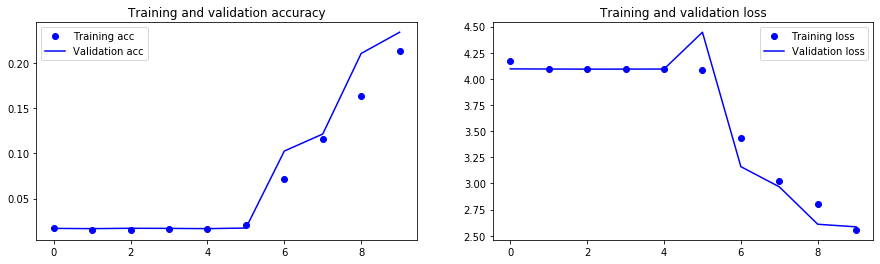

Test acc: 22.595 Val acc: 23.405 (At iteration 9) final training acc: 21.356

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-08 - 5.332 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


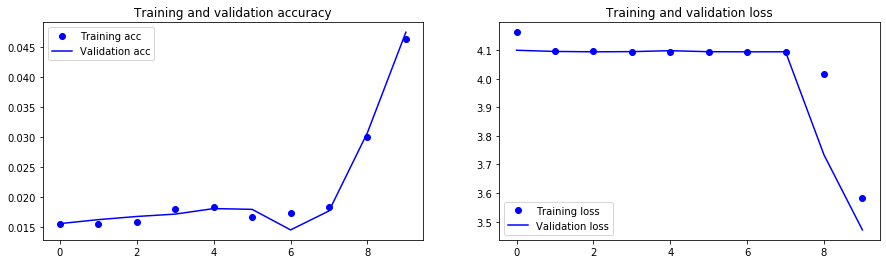

Test acc: 5.332 Val acc: 4.747 (At iteration 9) final training acc: 4.634

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-07 - 33.212 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


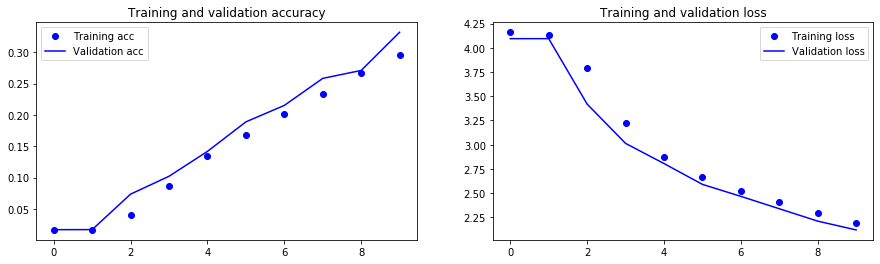

Test acc: 33.212 Val acc: 33.175 (At iteration 9) final training acc: 29.621

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-06 - 30.902 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


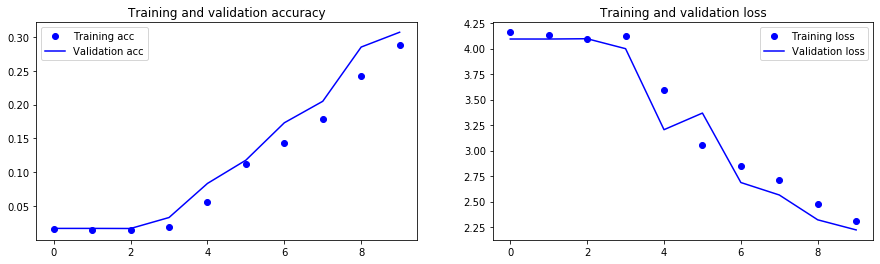

Test acc: 30.902 Val acc: 30.696 (At iteration 9) final training acc: 28.765

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-05 - 28.244 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


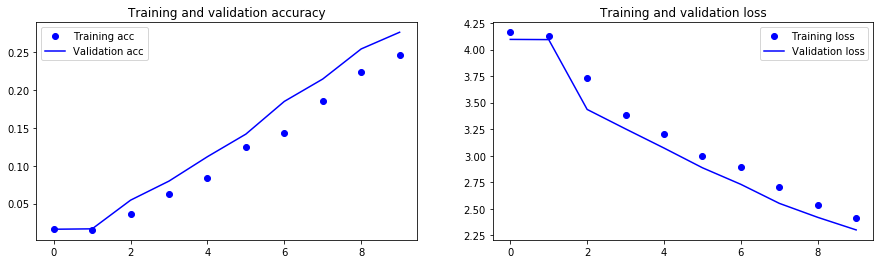

Test acc: 28.244 Val acc: 27.611 (At iteration 9) final training acc: 24.624

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-04 - 26.846 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


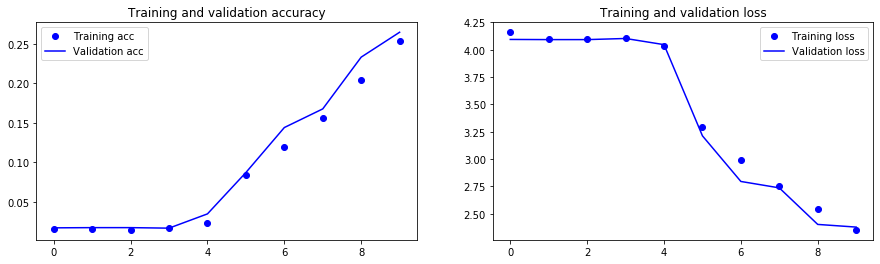

Test acc: 26.846 Val acc: 26.450 (At iteration 9) final training acc: 25.399

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-03 - 36.503 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


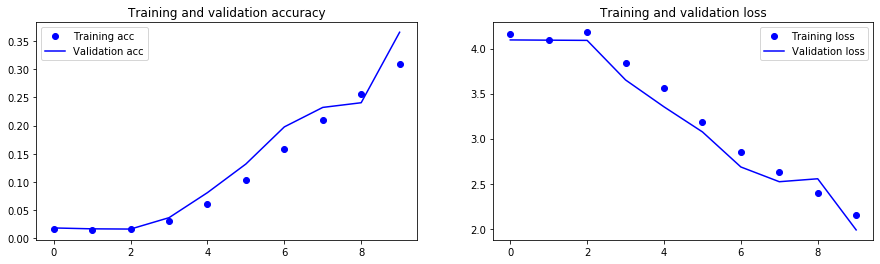

Test acc: 36.503 Val acc: 36.564 (At iteration 9) final training acc: 30.886

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-02 - 25.011 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


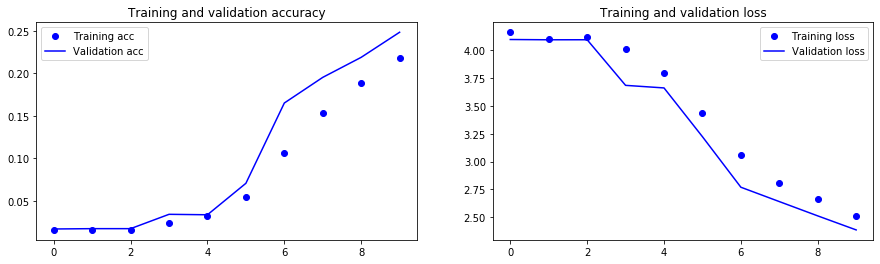

Test acc: 25.011 Val acc: 24.842 (At iteration 9) final training acc: 21.791

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-01 - 33.629 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


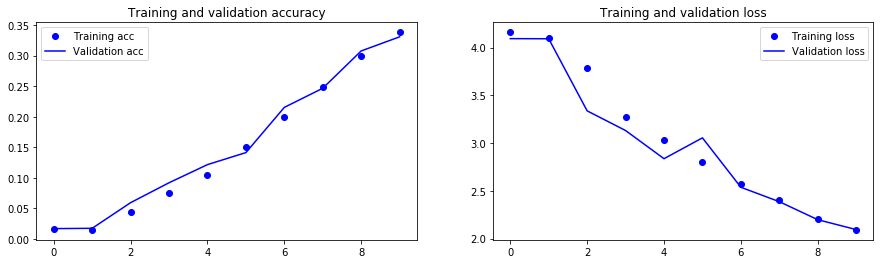

Test acc: 33.629 Val acc: 33.056 (At iteration 9) final training acc: 33.807

##################### det-3L-cuda-HU_64-LR_0,02-OFF_0-POW_0-rimoz_0-3BAR-norm-reg-00 - 30.190 ######################
--------------------- Cross_view_lrScan ---------------------------------------------


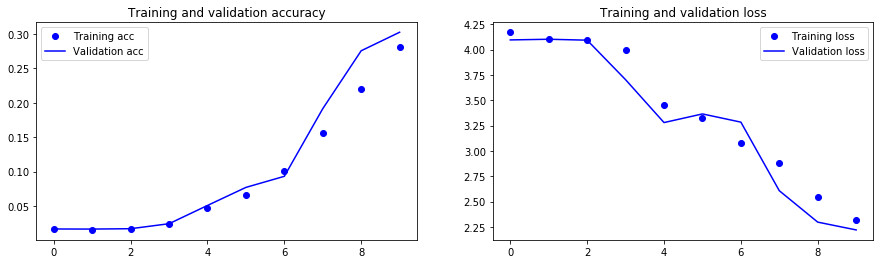

Test acc: 30.190 Val acc: 30.248 (At iteration 9) final training acc: 28.134



In [74]:
import matplotlib.pyplot as plt 
import pickle
from os import scandir
import numpy as np
from os.path import basename #, exists
from parse import parse

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/" 

################ FROM PREVIOUS GLOBAL RESULT ################
for result in globalResults[:10]:
    print("##################### {} - {:.3f} ######################".format(cleanForExcel(result["model_name"]),result["avg"]*100))
    
    
#     folder_name_format = "S{:3d}C{:3d}P{:3d}R{:3d}A{:3d}_rgb" #Setup-Camera-Performer-Replication-Action
#     def getConfigurationFromFolderPath(folderPath):
#     setup, camera, performer, replication, label = parse.parse(folder_name_format,basename(folderPath))
    
    foldersToShow = [parse("{}_test_acc",f) for f in list(result.keys()) if parse("{}_test_acc",f) != None]
    for folder in foldersToShow:
        folder = folder[0]
        
        if result[folder+"_test_acc"] == 0:
            continue
            
        print("---------------------",folder,"---------------------------------------------")
            
        historyPath = SAVED_MODEL_FOLDER+folder+"/"+result["model_name"]+".pickle"
        historyPath = historyPath.replace("-MIN_LOSS.pickle",".pickle")
        with open(historyPath,"rb") as file_in:
            r = pickle.load(file_in)

        model_history = r["history"]
        
        if isinstance(model_history, dict):
            acc = model_history['acc']
            val_acc = model_history['val_acc']
            loss = model_history['loss']
            val_loss = model_history['val_loss']
        else:
            acc = model_history.history['accuracy']
            val_acc = model_history.history['val_accuracy']
            loss = model_history.history['loss']
            val_loss = model_history.history['val_loss']


        epochs = range(len(acc))

        plt.figure(figsize = (15,4))
        ax1 = plt.subplot(1, 2, 1)
        ax1.plot(epochs, acc, 'bo', label='Training acc')
        ax1.plot(epochs, val_acc, 'b', label='Validation acc')
        plt.title('Training and validation accuracy')
        ax1.legend()

        #     plt.figure()
        ax2 = plt.subplot(1, 2, 2)
        ax2.plot(epochs, loss, 'bo', label='Training loss')
        ax2.plot(epochs, val_loss, 'b', label='Validation loss')
        plt.title('Training and validation loss')
        ax2.legend()

        plt.show()
        test_acc = result[folder+"_test_acc"]*100
        max_val_acc = max(val_acc)*100
        i_val_acc = np.argmax(val_acc)
        training_acc = max(acc)*100
        print("Test acc: {:.3f} Val acc: {:.3f} (At iteration {}) final training acc: {:.3f}".format(test_acc,max_val_acc,i_val_acc,training_acc))
        if "loaded_from" in r.keys():
            print("Loaded from:", cleanForExcel(r["loaded_from"]))
        print("")

In [ ]:
folder[0]

In [ ]:
list(globalResults[0].keys())[1:3]

In [ ]:
from parse import parse
result = globalResults[0]
[parse("{}_test_acc",f) for f in list(result.keys()) if parse("{}_test_acc",f) != None]
# [f for f in list(result.keys())[1:3]]

In [ ]:
historyPath

### Visualize missclassified

In [ ]:
import seaborn as sn
def plotConfusionMatrixes(conf_mat_val, conf_mat_test, labelString = None):
    plt.figure(figsize = (25,35))
    ax1 = plt.subplot(2, 1, 1)
    ax1 = sn.heatmap(conf_mat_val, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("VALIDATION SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15
    plt.ylabel('True', fontsize = 15) # y-axis label with fontsize 15
    
    ax2 = plt.subplot(2, 1, 2)
    
    ax2 = sn.heatmap(conf_mat_test, annot=True,xticklabels=labelString,yticklabels=labelString, fmt='g')
    plt.title("TEST SET", fontsize = 20) # title with fontsize 20
    plt.xlabel('Pred', fontsize = 15) # x-axis label with fontsize 15

    plt.show()

In [ ]:
import pickle
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# label_order = ['1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', 
#                '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', 
#                '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', 
#                '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', 
#                '5', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', 
#                '6', '60', '7', '8', '9']


SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_view/"
# SAVED_MODEL_FOLDER += "top+Senesi_Cross_subject/"
# SAVED_MODEL_FOLDER += "Cross_view_mini/"  
# SAVED_MODEL_FOLDER += "Cross_subject_mini/" 
SAVED_MODEL_FOLDER += "Cross_view/"  
# SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

loadedResults.sort(key=lambda x : x["test_acc"],reverse=True)
result = loadedResults[0]

y_val_pred = result["y_val_pred"]
y_val_true = result["y_val_true"]
y_test_pred = result["y_test_pred"]
y_test_true = result["y_test_true"]
val_acc = result["val_acc"]
test_acc = result["test_acc"]
print("Val acc:",val_acc)
print("Test acc:",test_acc)

# import pandas as pd
# y_actu_val = pd.Series(y_val_true, name='Actual')
# y_pred_val = pd.Series(y_val_pred, name='Predicted')
# conf_mat_val = pd.crosstab(y_actu_val, y_pred_val, rownames=['Actual'], colnames=['Predicted']
# #                            , margins=True
#                           )

# y_actu_test = pd.Series(y_test_true, name='Actual')
# y_pred_test = pd.Series(y_test_pred, name='Predicted')
# conf_mat_test = pd.crosstab(y_actu_test, y_pred_test, rownames=['Actual'], colnames=['Predicted']
# #                             , margins=True
#                            )

conf_mat_val= confusion_matrix(y_true=y_val_true, y_pred=y_val_pred)            
conf_mat_test = confusion_matrix(y_true=y_test_true, y_pred=y_test_pred)

# # normalize
# conf_mat_val = conf_mat_val / conf_mat_val.sum(axis=1)
# conf_mat_test = conf_mat_test / conf_mat_test.sum(axis=1)

labels = range(1,len(conf_mat_val[0])+1)
plotConfusionMatrixes(conf_mat_val,conf_mat_test,labelString=labels)

length = len(conf_mat_test)

till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [ ]:
#CROSS_SUBJECT
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [ ]:
#CROSS_VIEW
till = 21
mat_test = conf_mat_test.copy()
np.fill_diagonal(mat_test, 0)
np.argsort(mat_test.ravel())[::-1]
test_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_test.ravel())[::-1]]
print("TEST PAIR CONFUSED:\n", test_indexs[:till])
print("TEST TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(test_indexs[:till])))) # remove duplicates


mat_val = conf_mat_val.copy()
np.fill_diagonal(mat_val, 0)
np.argsort(mat_val.ravel())[::-1]
val_indexs = [[int(elem/length)+1,elem%length+1] for elem in np.argsort(mat_val.ravel())[::-1]]
print("\nVAL PAIR CONFUSED:\n", val_indexs[:till])
print("VAL TOPIC CONFUSED:\n", list(dict.fromkeys(np.concatenate(val_indexs[:till])))) # remove duplicates

commonPairs = [test_indexs[r] for r in range(till) if test_indexs[r] in val_indexs[:till]]
print("\nCOMMON MOST CONFUSED:\n", commonPairs)
commonTopic = list(dict.fromkeys(np.concatenate(commonPairs)))
print("COMMON TOPIC CONFUSED:\n", commonTopic)

print("lenght:" , len(commonTopic))


In [14]:
view = [34, 10, 30, 12, 29, 11, 53, 57, 17, 16, 49, 23] # toughest cross_view
subj = [12, 30, 10, 34, 11, 29, 31, 32, 17, 16, 53, 57] # toughest cross_subject
subj.sort()
view.sort()
print("subj =", subj)
print("view =", view)

subj = [10, 11, 12, 16, 17, 29, 30, 31, 32, 34, 53, 57]
view = [10, 11, 12, 16, 17, 23, 29, 30, 34, 49, 53, 57]


## Re-evaluating model

In [41]:
import dill
import pickle
import numpy as np
from keras import models,layers
from keras.layers import LSTM, CuDNNLSTM, Dropout, Concatenate , Dense
from keras.models import Model,load_model
from keras.regularizers import l2 #, l1
from keras.callbacks import EarlyStopping,ModelCheckpoint
from os import scandir
from os.path import exists
import shutil 

DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"
SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"

MODEL_NAME = "keypoint_rcnn_X_101_32x8d_FPN_3x"
fullModelNameToEvaluate = "keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0"

# folder_to_evaluate = "Cross_view/"  
folder_to_evaluate = "Cross_view_mini/"  
# folder_to_evaluate = "Cross_subject/"

completeFolderPath = SAVED_MODEL_FOLDER+folder_to_evaluate


assert exists(completeFolderPath+"summaryResults-Copy1.pickle")
print("Loading previous results...")
with open(completeFolderPath+"summaryResults-Copy1.pickle","rb") as handle:
    results = pickle.load(handle)

# results.sort(key=lambda x : x["test_acc"],reverse=True)

accessoriesPath = completeFolderPath+fullModelNameToEvaluate+".pickle"

print("Loading accessories:",accessoriesPath)
with open(accessoriesPath,"rb") as handle:
    accessories = pickle.load(handle)
            
print("Loading functions...")
loaded_specific_functions = [dill.loads(x) for x in accessories["spec_fun_DILL"]]

## SPECIFIC FUNCTIONS
specificFunctions = []
for elem in loaded_specific_functions:
    if callable(elem):
        specificFunctions.append(elem)
    elif not callable(elem):
        specificFunctions.append(elem[0])
                

if folder_to_evaluate.endswith("Cross_subject/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW-dataset.pickle"
if folder_to_evaluate.endswith("Cross_subject_mini/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_SUBJECT_MINI-dataset.pickle"           
elif folder_to_evaluate.endswith("Cross_view_mini/"):
    datasetName = DATASET_FOLDER+MODEL_NAME+"-CROSS_VIEW_MINI-dataset.pickle"
else:
    raise Exception("folder not recognised")
    
### LOADING DATASET ###
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

X_train, y_train, X_val, y_val, X_test, y_test, encodingLabels = preprocessData(train_set, 
                                                                               val_set, 
                                                                               test_set,  
                                                                               specificFunctions)
encodingLabels = [int(i) for i in encodingLabels]

model = load_model(completeFolderPath+fullModelNameToEvaluate+".h5")
### EVALUATING MODEL ###      
val_acc, test_acc, y_val_true, y_val_pred, y_test_true, y_test_pred = getValTestAccuracy(model,X_val,y_val,X_test,y_test, encodingLabels)
print("Model for MAX ACCURACY test_acc: {:.3f} val_acc: {:.3f}".format(test_acc*100,val_acc*100))


minLossModelName = "{}-min_val_loss.hdf5".format(completeFolderPath+fullModelNameToEvaluate)
model_minLoss = load_model(minLossModelName)
val_acc_minLoss, test_acc_minLoss, y_val_true, y_val_pred_minLoss, y_test_true, y_test_pred_minLoss = getValTestAccuracy(model_minLoss,X_val,y_val,X_test,y_test,encodingLabels)
print("Model for MIN LOSS test_acc: {:.3f} val_acc: {:.3f}".format(test_acc_minLoss*100,val_acc_minLoss*100))

### SAVING RESULTS ###
newEvaluation = {"val_acc": val_acc, 
                "test_acc": test_acc, 
                "model_name": fullModelNameToEvaluate, 
                "y_val_true": y_val_true,
                "y_val_pred": y_val_pred,
                "y_test_true": y_test_true,
                "y_test_pred": y_test_pred,

                "val_acc_minLoss": val_acc_minLoss, 
                "test_acc_minLoss": test_acc_minLoss, 
                "y_val_pred_minLoss": y_val_pred_minLoss,
                "y_test_pred_minLoss": y_test_pred_minLoss
               }

previousResult = [v for v in results
     if v["model_name"] == fullModelNameToEvaluate]
isPreviousResult = np.array(results) == previousResult
indexPreviousResult = np.array(range(len(results)))[isPreviousResult]
if len(indexPreviousResult) == 0:
    print("model evaluated for the first time")
    results.append(newEvaluation)
else:
    print("substituting evaluation for the model")
    results[indexPreviousResult[0]] = newEvaluation



print("Dumping results...")
with open(completeFolderPath+"summaryResults.pickle","wb") as handle:
    pickle.dump(results, handle)

print("DONE!")


Loading previous results...
Loading accessories: /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-HU_128-removeZerosFromDataset-relativeToVideoCenter-normalizeVideos-drop-0-reg-0.pickle
Loading functions...
#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/keypoint_rcnn_X_101_32x8d_FPN_3x-CROSS_VIEW_MINI-dataset.pickle
train_set shape: (4044,)
train_set zero elements: 20332/16346622 (0.12%)
val_set shape: (1012,)
val_set zero elements: 2618/4066196 (0.064%)
test_set shape: (2528,)
test_set zero elements: 11390/10189664 (0.11%)
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
classes order: ['10' '11' '12' '29' '30' '34' '53' '57']
removing zeros from dataset
removing zeros from dataset
removing zeros from dataset
Adapting the data to the CENTER of each VIDEO
Adapting the data to the CENTER of each VIDEO
Ada

/data/students_home/amoscatelli/.local/lib/python3.6/site-packages/ipykernel_launcher.py:101: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


### Visualize nextFrameResults

In [32]:
DATASET_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/"

model_name = "keypoint_rcnn_X_101_32x8d_FPN_3x"
# model_name = "PoseNet-101"
datasetName = DATASET_FOLDER+model_name+"-CROSS_SUBJECT_MINI-dataset.pickle"

train_set, val_set, test_set = getData(datasetName)

train_set[0] = removeZerosFromDataset(train_set[0])
# train_set[0] = relativeToNextFrameBuilder(11)(train_set[0])
# train_set[0] = relativeToUpperMiddleBottomCentersOfVideo(train_set[0])
train_set[0] = cumulativeDifferences(train_set[0])
# train_set[0] = normalizeVideosXYInpid(train_set[0])
train_set[0] = normalizeVideos(train_set[0])

# val_set[0] = removeZerosFromDataset(val_set[0])
# test_set[0] = removeZerosFromDataset(test_set[0])

# labels = ["train_set", "val_set", "test_set"]
# for i,dataset in enumerate([train_set, val_set, test_set]):
#     totalsize, zero_elements =  getZeroStatsForDataset(dataset[0])
#     print("{} shape: {}".format(labels[i], dataset[0].shape))
#     print("{} zero elements: {}/{} ({:.2}%)".format(labels[i],zero_elements,totalsize,zero_elements*100/totalsize))
        
print("DONE!")

train_set shape: (6451,)
train_set zero elements: 18496/19641018 (0.094%)
val_set shape: (1613,)
val_set zero elements: 6358/4906268 (0.13%)
test_set shape: (3312,)
test_set zero elements: 5032/10836820 (0.046%)
removing zeros from dataset
Adapting the data as the CUMULATIVE DIFFERENCES of consecutive frames
normalising EACH VIDEO, considering x and y TOGETHER
DONE!


In [34]:
from random import randint
video_ids = [randint(0,len(train_set[0])) for i in range(15)]

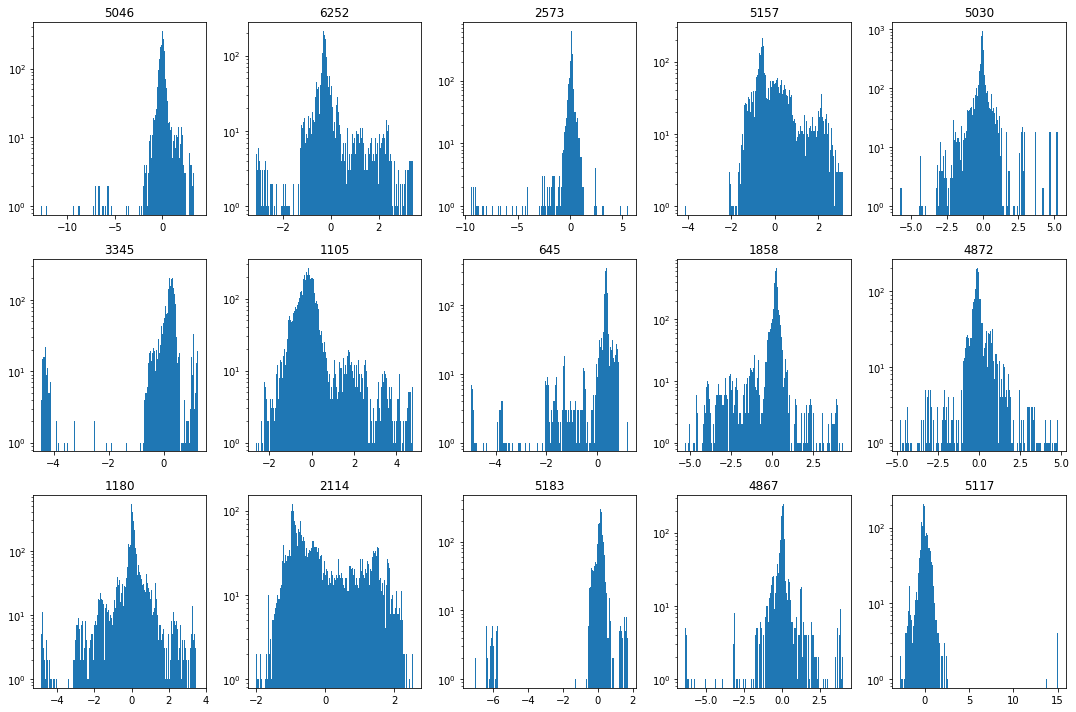

In [35]:
# CUMULATIVE DIFFERENCES
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

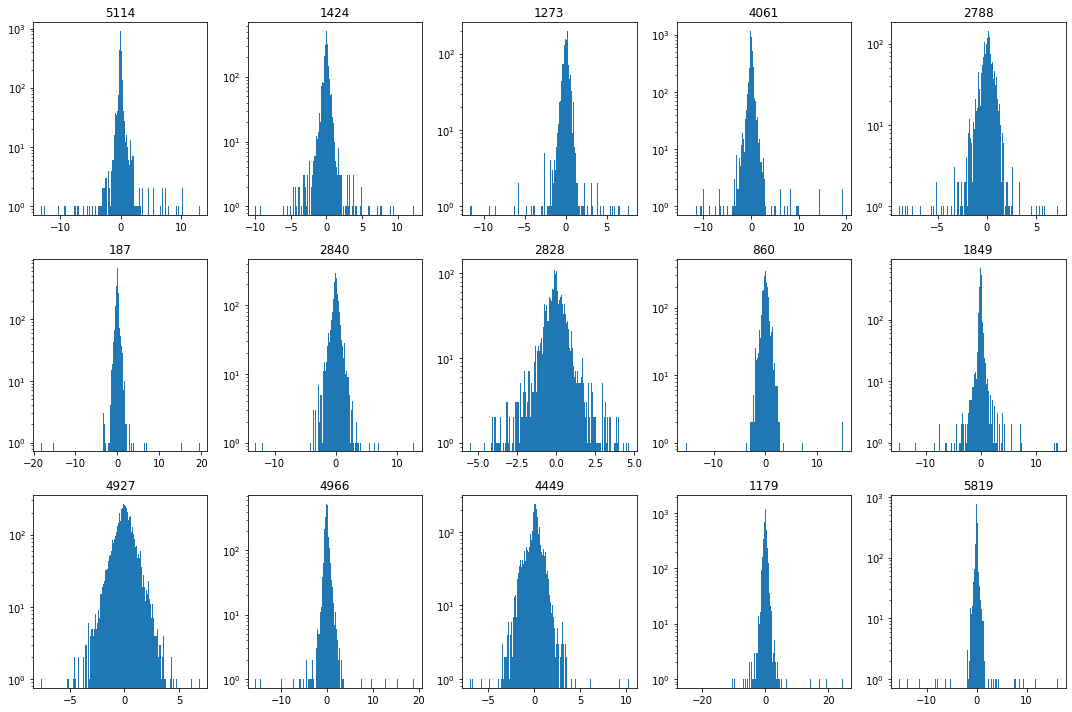

In [255]:
# NEXT FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

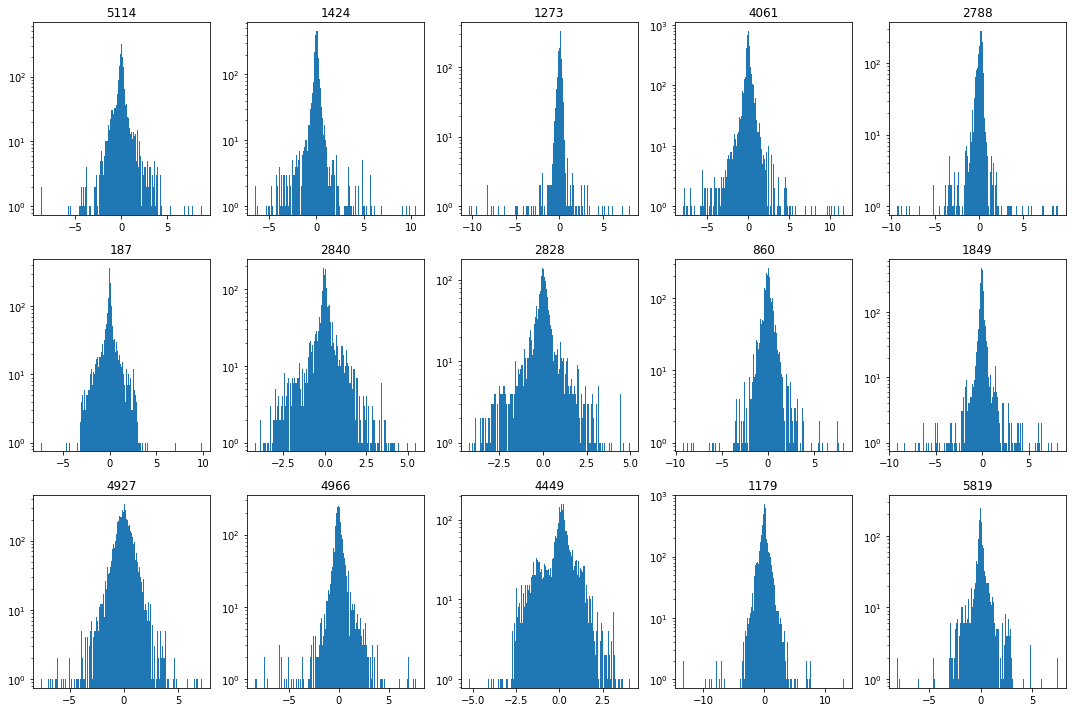

In [259]:
# NEXT 5 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

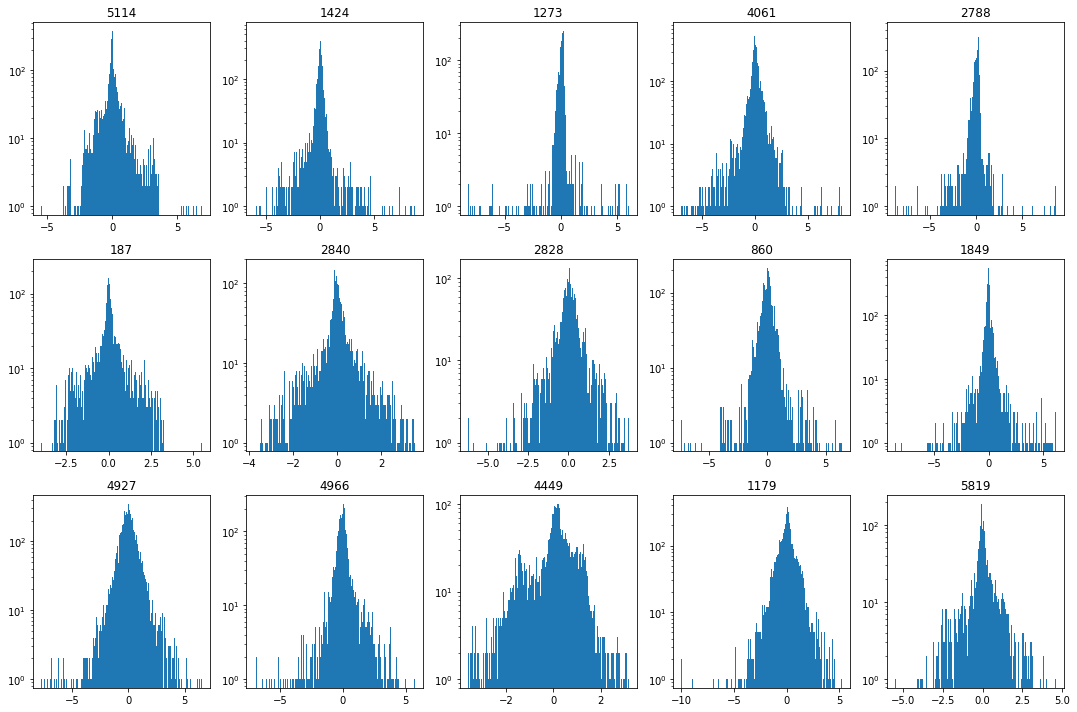

In [261]:
# NEXT 11 FRAME nomalizing INDIPENDENTLY
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

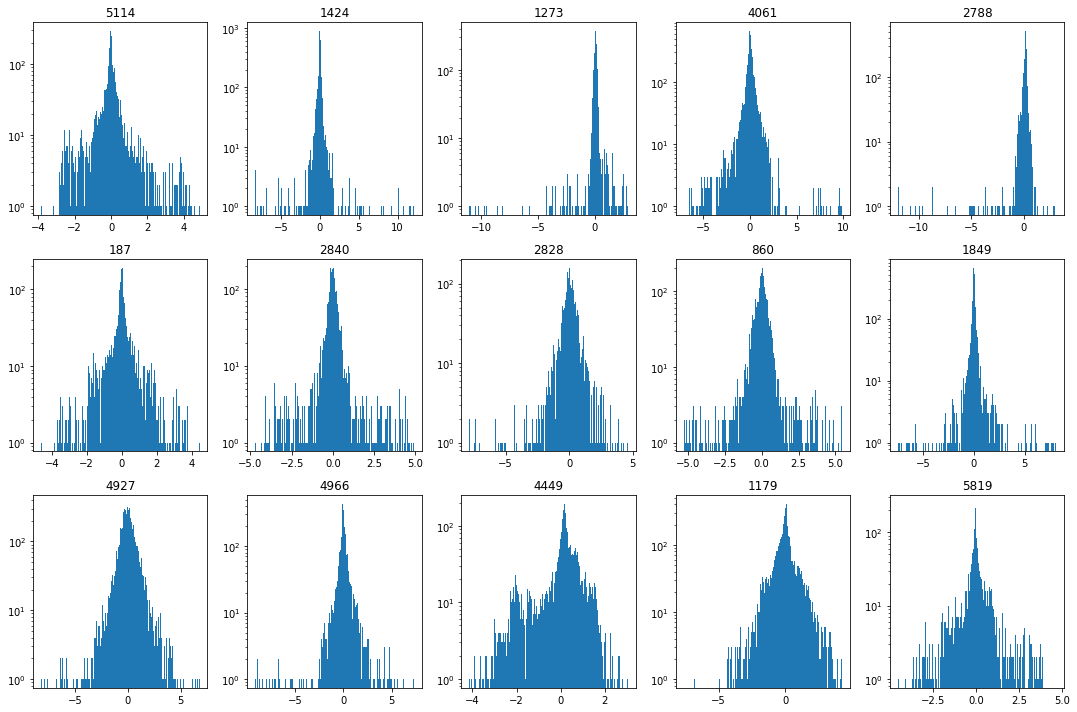

In [267]:
# NEXT 11 FRAME nomalizing TOGETHER
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

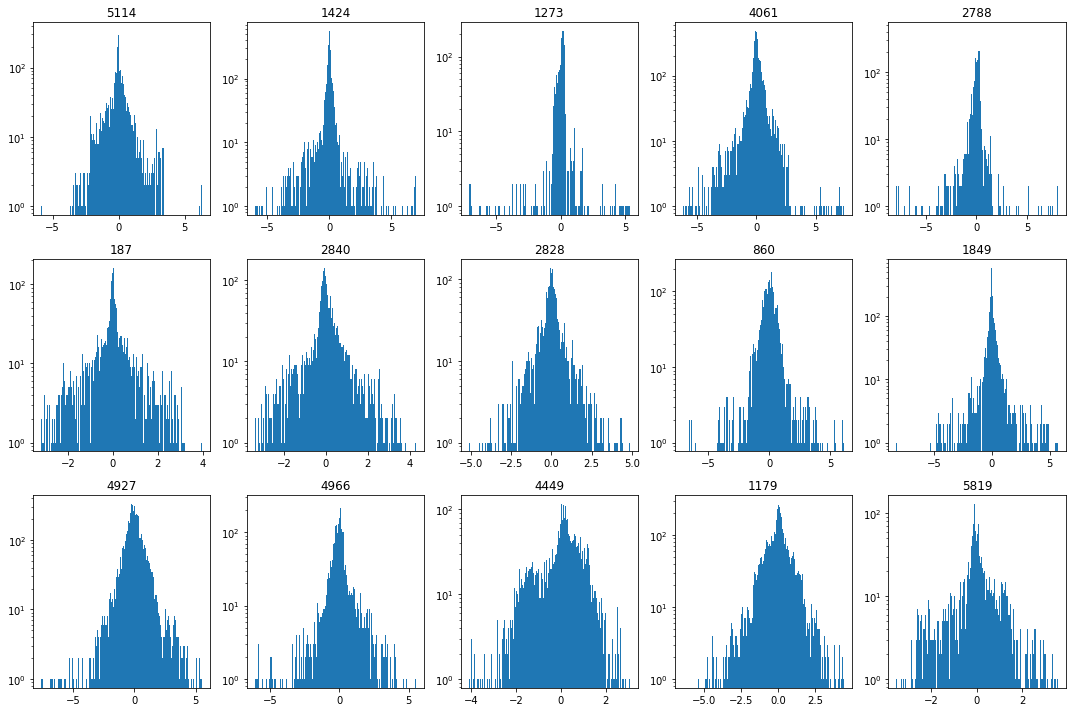

In [263]:
# NEXT 15 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

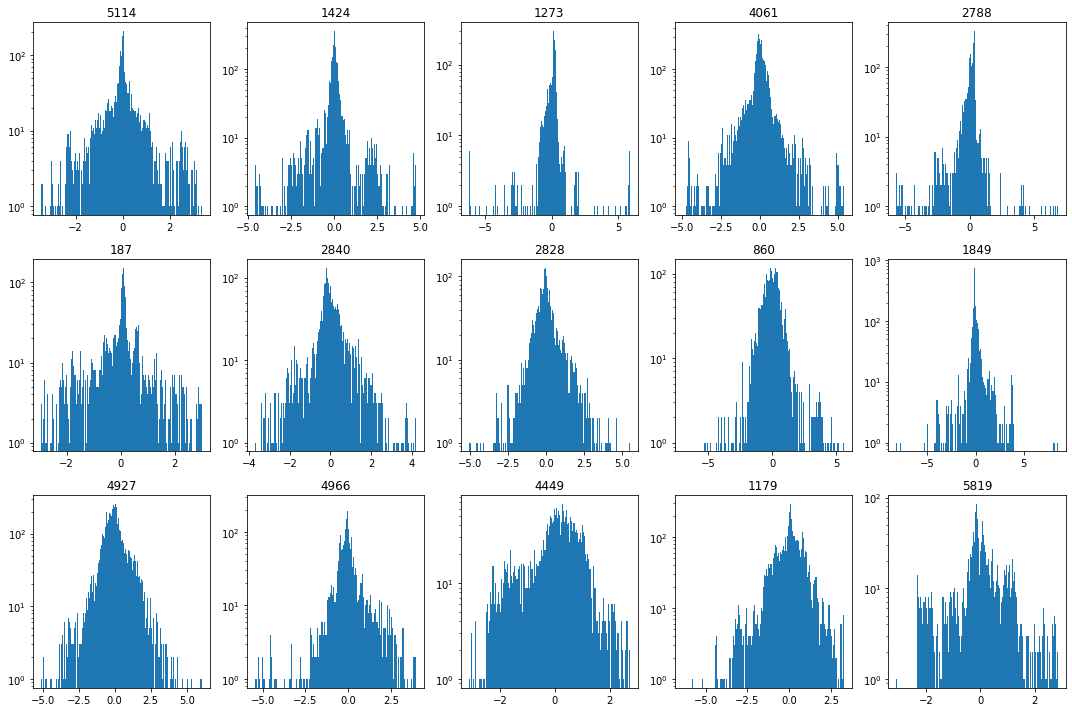

In [265]:
# NEXT 30 FRAME
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

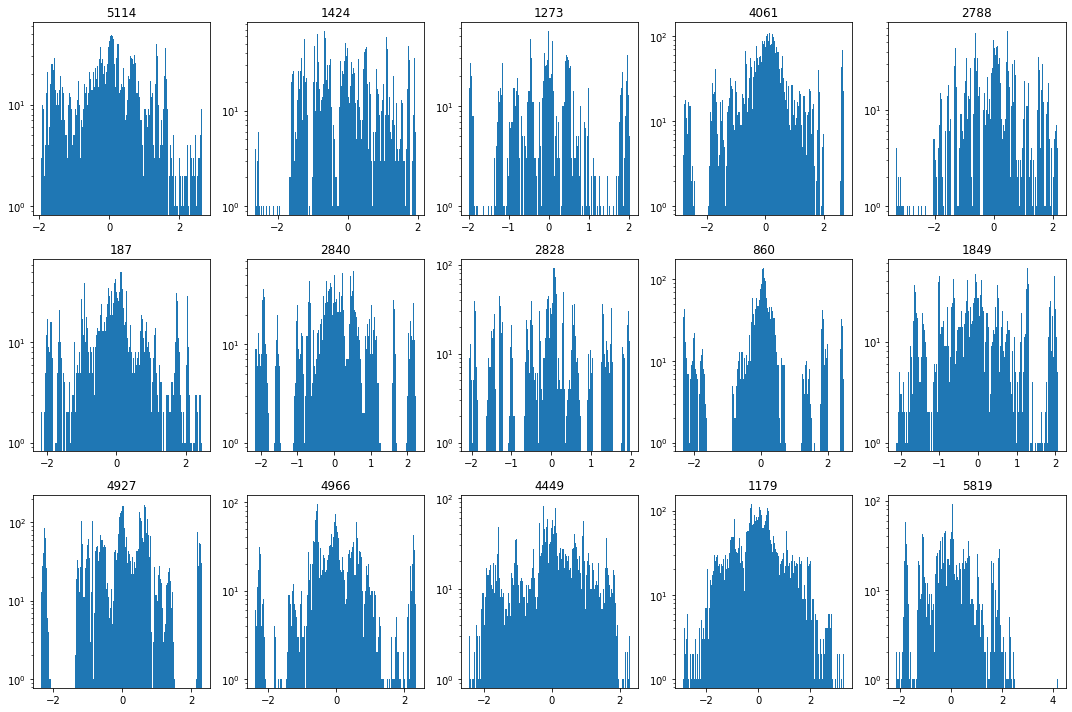

In [277]:
# 3BAR
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

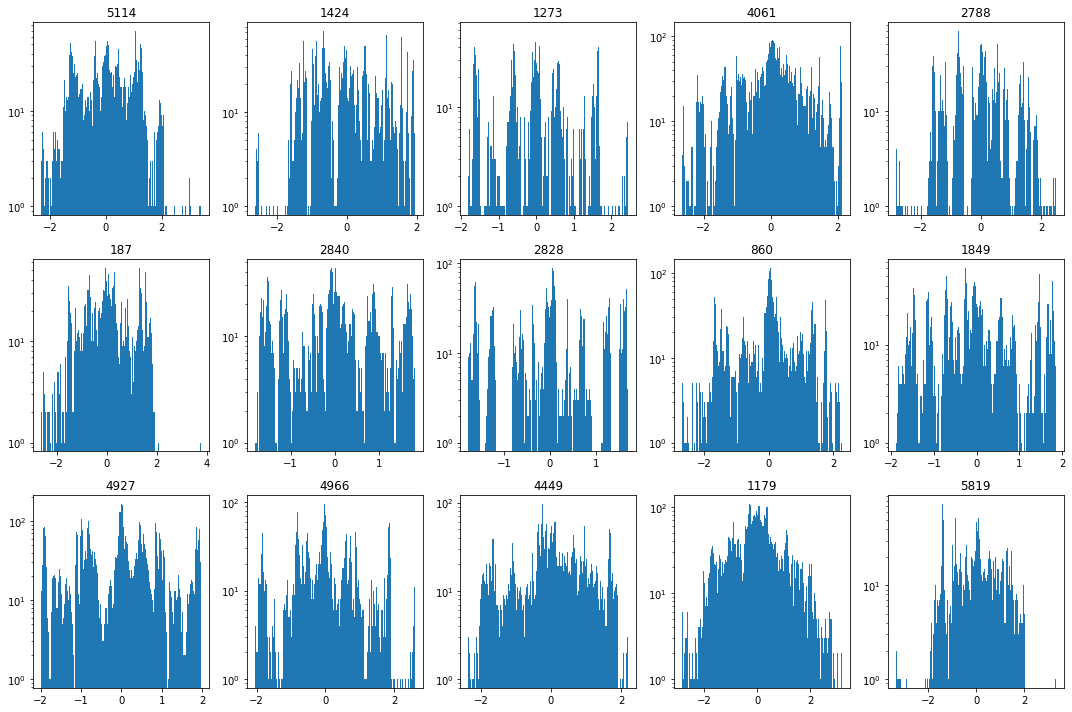

In [275]:
# 3BAR INDIP
import matplotlib.pyplot as plt
from random import randint


fig, axes = plt.subplots(nrows=3, ncols=5)
fig.set_size_inches(15,10)
counter = 0
for axes_row in axes:
    for ax in axes_row:
#         video_idx = randint(0,len(train_set[0]))
        video_idx = video_ids[counter]
        counter += 1
        videoToVisualize = train_set[0][video_idx]
        y = videoToVisualize.flatten()
        ax.hist(y, bins=200)
        ax.set_title(video_idx)
        ax.set_yscale('log')
fig.tight_layout()
plt.show()

## CLEAN Results

In [112]:
#remove last element of summary result

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
# SAVED_MODEL_FOLDER += "Cross_view/"
SAVED_MODEL_FOLDER += "Cross_subject/"

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)

print("Removing",loadedResults[-1]['model_name'])
print ("From",SAVED_MODEL_FOLDER+"summaryResults.pickle")

# loadedResults = loadedResults[:-1]
# with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","wb") as handle:
#             pickle.dump(loadedResults, handle)

Removing keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeTo5CentersNTURGBofVideo-drop-0.1-rec_drop-0.1-norm
From /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Senesi/summaryResults.pickle


## Removing accessories file for low results

In [5]:
from os.path import isfile, isdir, join, exists,getsize,basename
from os import scandir
import pickle

NUMBER_OF_BEST_MODEL_TO_SAVE = 20

SAVED_MODEL_FOLDER = "/data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/"
# SAVED_MODEL_FOLDER += "Senesi/"
# SAVED_MODEL_FOLDER += "top-models/"
SAVED_MODEL_FOLDER += "Cross_view_mini/"
# SAVED_MODEL_FOLDER += "Cross_subject_mini/"


accessoryFileList = [f.path for f in scandir(SAVED_MODEL_FOLDER) 
                       if f.path.endswith(".pickle") 
                       and "summaryResult" not in basename(f)]

with open(SAVED_MODEL_FOLDER+"summaryResults.pickle","rb") as handle:
        loadedResults = pickle.load(handle)
        
loadedResults.sort(key=lambda x : x["test_acc"], reverse=True)
assert NUMBER_OF_BEST_MODEL_TO_SAVE > 10
bestModels = [r['model_name'] for r in loadedResults[:NUMBER_OF_BEST_MODEL_TO_SAVE]]

for accessoryFile in accessoryFileList:
    modelNameToCheck = basename(accessoryFile).replace(".pickle","")
    if modelNameToCheck not in bestModels:
        print("Removing",accessoryFile)
        !rm $accessoryFile

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0.5-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.5-reg-0.001.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.05-rec_drop-0.05.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideosXYInpid-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-normalizeVideos-drop-0-rec_drop-0.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-

Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToUpperMiddleBottomCentersOfVideo-normalizeVideos-drop-0.1-reg-1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-removeZerosFromDataset-normalizeVideos-drop-0.1-rec_drop-0.1.pickle
Removing /data/students_home/amoscatelli/Desktop/actionAnalysis/savedModels/Cross_view_mini/keypoint_rcnn_X_101_32x8d_FPN_3x-2L-CuDNNLSTM-removeZerosFromDataset-relativeToNextFrame-normalizeVideos-drop-0.1-reg-0.pickle


# AREA TEST

## Testing relativeToNextFrameFunction

## Smoothing test

In [35]:
MODEL_NAME = "PoseNet-101"
datasetName = DATASET_FOLDER+MODEL_NAME+"-SPLIT-dataset.pickle"
print("#### Loading dataset: ", datasetName)
train_set, val_set, test_set = getData(datasetName)

#### Loading dataset:  /data/students_home/amoscatelli/Desktop/actionAnalysis/datasets/PoseNet-101-SPLIT-dataset.pickle
train_set shape: (5460,)
train_set zero elements: 58106/13984574 (0.42%)
val_set shape: (1365,)
val_set zero elements: 15980/3509310 (0.46%)
test_set shape: (759,)
test_set zero elements: 9588/1973564 (0.49%)


doing video 0
doing video 1


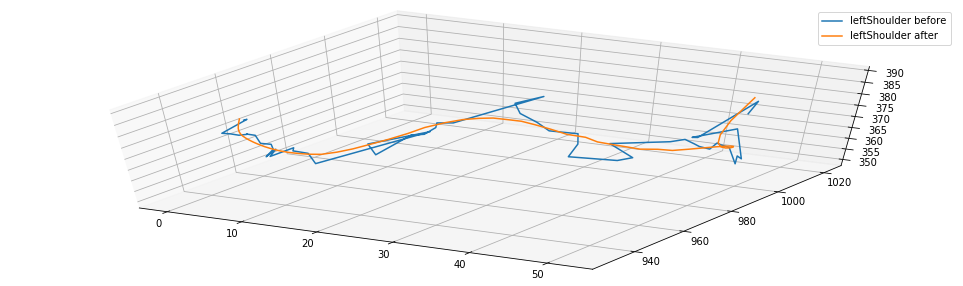

In [36]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p]+" before")
    
    smoothingPoints(29,5)[0](train_set[0])
    
    x2, y2 = zip(*[(f[p][0], f[p][1]) for f in train_set[0][0]])
    z2 = np.arange(len(x))
    ax.plot(z2,y2,x2,label=legend[p]+" after")
    
    ax.legend()

plt.show()
  

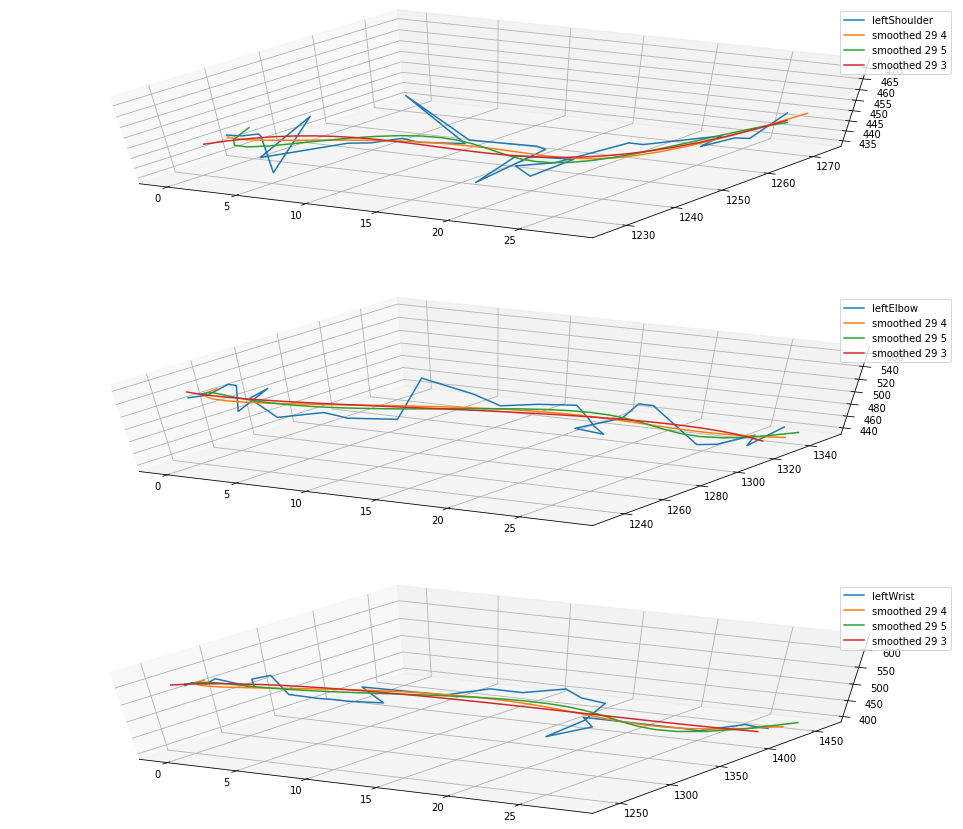

In [91]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
window = 29
order = 5
# listOfPoints = list(range(17))
listOfPoints = [5
#                 ,7,9
               ]

fig = plt.figure()
fig.set_size_inches( (17, len(listOfPoints)*5) )
for i, p in enumerate(listOfPoints):
    
    ax = fig.add_subplot(len(listOfPoints), 1, i+1, projection='3d')
    
    ax.view_init(50, -60)
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    z = np.arange(len(x))
    ax.plot(z,y,x,label=legend[p])
    
    smooth_y=signal.savgol_filter(y, window, order) 
    smooth_x=signal.savgol_filter(x, window, order)
    ax.plot(z,smooth_y,smooth_x,label="smoothed {} {}".format(window,order))
    
    
    ax.legend()

plt.show()
  

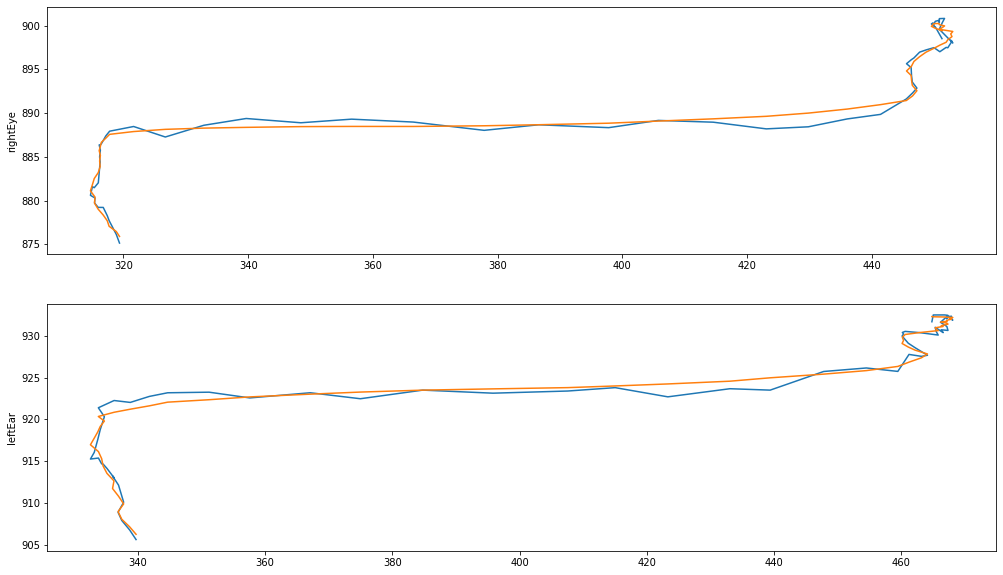

In [302]:
from pandas import Series #read_csv, ,date_range
# from pandas import DataFrame
# from pandas import Grouper
# from numpy import random
# from numpy.random import randn

from scipy import signal
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


legend = ["nose", "leftEye", "rightEye", "leftEar", "rightEar",
          "leftShoulder", "rightShoulder", "leftElbow", "rightElbow", "leftWrist", "rightWrist",
          "leftHip", "rightHip", "leftKnee", "rightKnee", "leftAnkle", "rightAnkle"]
listOfPoints = [2,3]
fig, axes = plt.subplots(nrows=len(listOfPoints), ncols=1)
fig.set_size_inches((17,len(listOfPoints)*5))
for i, p in enumerate(listOfPoints):
    axes[i].set_ylabel(legend[p])
    x, y = zip(*[(f[p][0], f[p][1]) for f in randomVideo])
    # series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
    ts = Series(y, index=x)
    # ts = ts.cumsum()
    ts.plot(ax=axes[i])
    
    smooth_y=signal.savgol_filter(ts.get_values(),
                           29, # window size used for filtering
                           3), # order of fitted polynomial

    ts2 = Series(smooth_y[0], index=x)

    ts2.plot(ax=axes[i])

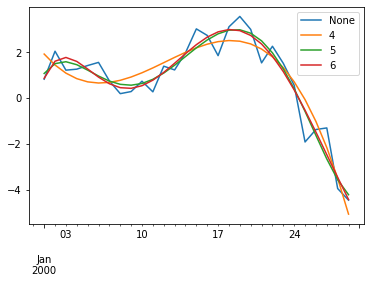

In [115]:
from pandas import read_csv, Series,date_range
from pandas import DataFrame
from pandas import Grouper
from matplotlib import pyplot
from numpy import random
from numpy.random import randn
from scipy import signal


# series = read_csv('daily-minimum-temperatures.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
ts = Series(randn(29), index=date_range('1/1/2000', periods=29))
ts = ts.cumsum()
ts.plot()

y1=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       4) # order of fitted polynomial  
ts2 = Series(y1, index=date_range('1/1/2000', periods=29))
ts2.plot(label="4")


y2=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       5) # order of fitted polynomial
ts3 = Series(y2, index=date_range('1/1/2000', periods=29))
ts3.plot(label="5")


y3=signal.savgol_filter(ts.get_values(),
                       29, # window size used for filtering
                       6) # order of fitted polynomial
ts4 = Series(y3, index=date_range('1/1/2000', periods=29))

ts4.plot(label="6")
plt.legend()